# Experiment 6: Static Pose MLP (Front vs Side - Multi-Run)

Robust comparison of front-view vs side-view pose-based models using **30-run aggregated statistics** with config-based training.

**Key Features:**
- Subject-wise stratified train/val/test splits (no subject leakage)
- Separate config files for front and side views
- 30 runs per view with different random seeds
- Comprehensive statistical analysis and visualization
- Hyperparameters saved with results for reproducibility

## Execution Plan

1. **Setup:** Import dependencies and configure paths
2. **Data:** Load and inspect front/side static pose features
3. **Multi-Run Training:** Execute 30 runs for both front and side views
4. **Statistical Analysis:** Compare aggregated results with mean ± std
5. **Visualization:** 
   - Multi-run distributions (box plots, histograms)
   - Best vs worst run comparisons
   - Run progression analysis
   - Aggregated confusion matrices
   - Cross-model statistical comparison

### Overview
- **Data:** Static pose features (45-dim: 9 angles × 5 statistics) from MediaPipe landmarks
- **Files:** `pose_data_front_static.npz` and `pose_data_side_static.npz`
- **Subjects:** 49 volunteers across 15 exercises
- **Splits:** Subject-wise stratified train/val/test (no subject leakage)
- **Models:** Two separate MLPs - one for front view, one for side view
- **Deployment scenario:** Single-view inference (front OR side camera, not both)
- **Metrics:** Accuracy, macro F1, per-class F1, confusion matrix

In [1]:
from pathlib import Path
import json
import sys
import numpy as np

PROJECT_ROOT = Path('..').resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Force reload modules to pick up latest changes
import importlib
import src.data.data_loader
import src.data.dataset_builder
import src.scripts.experiment_6
importlib.reload(src.data.data_loader)
importlib.reload(src.data.dataset_builder)
importlib.reload(src.scripts.experiment_6)

from src.data import load_pose_data
from src.scripts.experiment_6 import train_experiment_6_multi_run

In [2]:
importlib.reload(src.utils.visualization)

from src.utils.visualization import (
    plot_confusion_matrix_from_metrics,
    plot_per_class_f1_scores,
    sort_labels_by_numeric_prefix,
    display_multi_run_summary,
    plot_multi_run_distributions,
    plot_best_worst_comparison,
    plot_aggregated_confusion_matrix,
    plot_dual_training_history,
    compare_multi_run_stats,
)
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Define paths to static pose NPZ files
front_static_npz = PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_front_static.npz'
side_static_npz = PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_side_static.npz'

# Load and summarize front-view data
front_dataset, front_summary = load_pose_data(str(front_static_npz))
print("Front-view static features:")
print(f"  Samples: {front_summary['count']}")
print(f"  Subjects: {front_summary['unique_subjects']}")
print(f"  Classes: {front_summary['unique_classes']}")
print(f"  Feature shape: (N, 45) - 9 angles × 5 statistics")

# Load and summarize side-view data
side_dataset, side_summary = load_pose_data(str(side_static_npz))
print("\nSide-view static features:")
print(f"  Samples: {side_summary['count']}")
print(f"  Subjects: {side_summary['unique_subjects']}")
print(f"  Classes: {side_summary['unique_classes']}")
print(f"  Feature shape: (N, 45) - 9 angles × 5 statistics")

INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view


Front-view static features:
  Samples: 1574
  Subjects: 49
  Classes: 15
  Feature shape: (N, 45) - 9 angles × 5 statistics

Side-view static features:
  Samples: 1571
  Subjects: 49
  Classes: 15
  Feature shape: (N, 45) - 9 angles × 5 statistics


---

## Multi-Run Training: Front View (30 Runs)

Execute 30 training runs with different random seeds using `config/experiment_6_static_front.yaml`.

**Configuration:**
- Hyperparameters loaded from YAML config
- Results saved to `experiments/exer_recog/results/exp_06_pose_mlp_static/front/`
- Each run uses subject-wise stratified splits
- Early stopping with patience=10 on validation loss

In [4]:
# Train front-view model with multi-run (30 runs)
print("=" * 80)
print("MULTI-RUN TRAINING: FRONT VIEW (30 RUNS)")
print("=" * 80)

config_path_front = PROJECT_ROOT / 'config' / 'experiment_6_static_front.yaml'

multi_run_results_front, aggregated_stats_front = train_experiment_6_multi_run(
    npz_path=str(front_static_npz),
    config_path=str(config_path_front)
)

print("\n✅ Front-view multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats_front['test_accuracy']['mean']:.4f} ± {aggregated_stats_front['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats_front['test_macro_f1']['mean']:.4f} ± {aggregated_stats_front['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/front/multi_run_003
INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=900, val=207, test=467, classes=15


MULTI-RUN TRAINING: FRONT VIEW (30 RUNS)


I0000 00:00:1767687570.682136  275755 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
INFO - Datasets built with feature_dim=45


Epoch 1/150
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0898 - loss: 3.0082 

I0000 00:00:1767687575.312776  300861 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.0933 - loss: 2.9393 - val_accuracy: 0.1787 - val_loss: 2.8753
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1033 - loss: 2.8739 - val_accuracy: 0.2126 - val_loss: 2.7645
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1333 - loss: 2.7708 - val_accuracy: 0.2222 - val_loss: 2.6688
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1378 - loss: 2.7141 - val_accuracy: 0.2464 - val_loss: 2.5866
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1556 - loss: 2.6068 - val_accuracy: 0.2995 - val_loss: 2.5136
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1767 - loss: 2.5634 - val_accuracy: 0.3430 - val_loss: 2.4442
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1944 - loss: 2.4953 - val_accuracy: 0.4251 - val_loss: 2.3715
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2056 - loss: 2.4615 - val_accuracy: 0.4928 - val_loss: 2

INFO - Experiment 6 (static) complete. Test acc=0.7345, macro F1=0.7263
INFO - Run 1 complete: acc=0.7345, macro_f1=0.7263
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=835, val=210, test=529, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.0683 - loss: 3.0617 - val_accuracy: 0.0476 - val_loss: 2.8072
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0838 - loss: 2.9424 - val_accuracy: 0.0905 - val_loss: 2.7228
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0766 - loss: 2.9187 - val_accuracy: 0.1952 - val_loss: 2.6445
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1162 - loss: 2.8153 - val_accuracy: 0.3048 - val_loss: 2.5784
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1365 - loss: 2.7431 - val_accuracy: 0.4095 - val_loss: 2.5149
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1677 - loss: 2.6509 - val_accuracy: 0.4619 - val_loss: 2.4560
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1749 - loss: 2.6184 - val_accuracy: 0.4714 - val_loss: 2.4027
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1964 - loss: 2.5415 - val_accuracy: 0.4810 -

INFO - Experiment 6 (static) complete. Test acc=0.6333, macro F1=0.6093
INFO - Run 2 complete: acc=0.6333, macro_f1=0.6093
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=818, val=207, test=549, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.0611 - loss: 2.9797 - val_accuracy: 0.1159 - val_loss: 2.9974
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0917 - loss: 2.9425 - val_accuracy: 0.1594 - val_loss: 2.9182
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0905 - loss: 2.8733 - val_accuracy: 0.1836 - val_loss: 2.8438
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1198 - loss: 2.7621 - val_accuracy: 0.1836 - val_loss: 2.7746
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1381 - loss: 2.7150 - val_accuracy: 0.2126 - val_loss: 2.7092
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1553 - loss: 2.6397 - val_accuracy: 0.2319 - val_loss: 2.6456
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1687 - loss: 2.6123 - val_accuracy: 0.2464 - val_loss: 2.5853
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2115 - loss: 2.5062 - val_accuracy: 0.3140 - 

INFO - Experiment 6 (static) complete. Test acc=0.6685, macro F1=0.6755
INFO - Run 3 complete: acc=0.6685, macro_f1=0.6755
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=876, val=255, test=443, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.0616 - loss: 3.0425 - val_accuracy: 0.0902 - val_loss: 3.0436
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0879 - loss: 2.8885 - val_accuracy: 0.1137 - val_loss: 2.9593
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1107 - loss: 2.8428 - val_accuracy: 0.1882 - val_loss: 2.8809
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1221 - loss: 2.7478 - val_accuracy: 0.2392 - val_loss: 2.8090
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1393 - loss: 2.6636 - val_accuracy: 0.2549 - val_loss: 2.7480
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1575 - loss: 2.5876 - val_accuracy: 0.2667 - val_loss: 2.6914
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1792 - loss: 2.5592 - val_accuracy: 0.2667 - val_loss: 2.6369
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1918 - loss: 2.5334 - val_accuracy: 0.2667 - 

INFO - Experiment 6 (static) complete. Test acc=0.6095, macro F1=0.5929
INFO - Run 4 complete: acc=0.6095, macro_f1=0.5929
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=865, val=272, test=437, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.0566 - loss: 2.9792 - val_accuracy: 0.0993 - val_loss: 2.7057
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0832 - loss: 2.8818 - val_accuracy: 0.1029 - val_loss: 2.6386
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0832 - loss: 2.8227 - val_accuracy: 0.1471 - val_loss: 2.5762
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0960 - loss: 2.7492 - val_accuracy: 0.2316 - val_loss: 2.5185
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1237 - loss: 2.6696 - val_accuracy: 0.2574 - val_loss: 2.4646
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1353 - loss: 2.6249 - val_accuracy: 0.2978 - val_loss: 2.4132
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1699 - loss: 2.5382 - val_accuracy: 0.3713 - val_loss: 2.3646
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1965 - loss: 2.4803 - val_accuracy: 0.3934 - 

INFO - Experiment 6 (static) complete. Test acc=0.8032, macro F1=0.7928
INFO - Run 5 complete: acc=0.8032, macro_f1=0.7928
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=934, val=242, test=398, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.0557 - loss: 3.0255 - val_accuracy: 0.1198 - val_loss: 2.6715
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0760 - loss: 2.9320 - val_accuracy: 0.1198 - val_loss: 2.6070
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0953 - loss: 2.7890 - val_accuracy: 0.1198 - val_loss: 2.5496
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1092 - loss: 2.7069 - val_accuracy: 0.1405 - val_loss: 2.4975
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1392 - loss: 2.6506 - val_accuracy: 0.1777 - val_loss: 2.4535
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1638 - loss: 2.5746 - val_accuracy: 0.2934 - val_loss: 2.4128
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1649 - loss: 2.5179 - val_accuracy: 0.3388 - val_loss: 2.3788
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2120 - loss: 2.4384 - val_accuracy: 0.3512 -

INFO - Experiment 6 (static) complete. Test acc=0.6935, macro F1=0.6622
INFO - Run 6 complete: acc=0.6935, macro_f1=0.6622
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=871, val=242, test=461, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.0666 - loss: 3.0383 - val_accuracy: 0.1033 - val_loss: 2.8224
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0769 - loss: 2.9169 - val_accuracy: 0.1405 - val_loss: 2.7284
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1286 - loss: 2.7895 - val_accuracy: 0.1405 - val_loss: 2.6421
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1251 - loss: 2.7176 - val_accuracy: 0.1529 - val_loss: 2.5629
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1435 - loss: 2.6768 - val_accuracy: 0.1901 - val_loss: 2.4887
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1515 - loss: 2.6189 - val_accuracy: 0.1983 - val_loss: 2.4164
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1711 - loss: 2.5094 - val_accuracy: 0.2769 - val_loss: 2.3511
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1711 - loss: 2.4767 - val_accuracy: 0.2934 - 

INFO - Experiment 6 (static) complete. Test acc=0.6486, macro F1=0.6651
INFO - Run 7 complete: acc=0.6486, macro_f1=0.6651
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=905, val=275, test=394, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.0597 - loss: 3.0637 - val_accuracy: 0.1127 - val_loss: 2.7875
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0619 - loss: 3.0456 - val_accuracy: 0.1127 - val_loss: 2.7250
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0818 - loss: 2.8663 - val_accuracy: 0.1200 - val_loss: 2.6654
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0917 - loss: 2.8141 - val_accuracy: 0.1200 - val_loss: 2.6124
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1348 - loss: 2.7586 - val_accuracy: 0.1200 - val_loss: 2.5629
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1227 - loss: 2.6740 - val_accuracy: 0.1236 - val_loss: 2.5130
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1425 - loss: 2.6160 - val_accuracy: 0.1418 - val_loss: 2.4691
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1536 - loss: 2.5774 - val_accuracy: 0.1855 - 

INFO - Experiment 6 (static) complete. Test acc=0.7183, macro F1=0.6822
INFO - Run 8 complete: acc=0.7183, macro_f1=0.6822
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=849, val=199, test=526, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.0966 - loss: 2.9191 - val_accuracy: 0.0804 - val_loss: 2.7858
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0907 - loss: 2.8393 - val_accuracy: 0.1508 - val_loss: 2.7201
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1060 - loss: 2.7678 - val_accuracy: 0.1608 - val_loss: 2.6624
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1131 - loss: 2.7619 - val_accuracy: 0.1709 - val_loss: 2.6094
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1425 - loss: 2.6809 - val_accuracy: 0.1910 - val_loss: 2.5563
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1696 - loss: 2.5662 - val_accuracy: 0.2161 - val_loss: 2.5079
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1991 - loss: 2.5228 - val_accuracy: 0.2312 - val_loss: 2.4634
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2061 - loss: 2.4711 - val_accuracy: 0.2362 - 

INFO - Experiment 6 (static) complete. Test acc=0.6255, macro F1=0.6263
INFO - Run 9 complete: acc=0.6255, macro_f1=0.6263
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
WARNING - Val split missing classes: ['Lateral Raises', 'Deadlift', 'Calf raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=875, val=167, test=532, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.0709 - loss: 3.1232 - val_accuracy: 0.0599 - val_loss: 3.0389
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1051 - loss: 2.9434 - val_accuracy: 0.0599 - val_loss: 2.9424
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1246 - loss: 2.8761 - val_accuracy: 0.0659 - val_loss: 2.8600
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1131 - loss: 2.8421 - val_accuracy: 0.0659 - val_loss: 2.7828
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1257 - loss: 2.7666 - val_accuracy: 0.0659 - val_loss: 2.7146
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1406 - loss: 2.6807 - val_accuracy: 0.1078 - val_loss: 2.6517
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1589 - loss: 2.6466 - val_accuracy: 0.1796 - val_loss: 2.5953
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1669 - loss: 2.5903 - val_accuracy: 0.2275 -

INFO - Experiment 6 (static) complete. Test acc=0.6447, macro F1=0.6555
INFO - Run 10 complete: acc=0.6447, macro_f1=0.6555
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=926, val=272, test=376, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.0864 - loss: 2.8901 - val_accuracy: 0.1066 - val_loss: 2.9374
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1145 - loss: 2.7946 - val_accuracy: 0.1581 - val_loss: 2.8512
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1296 - loss: 2.7003 - val_accuracy: 0.1691 - val_loss: 2.7712
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1447 - loss: 2.6178 - val_accuracy: 0.2096 - val_loss: 2.7006
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1911 - loss: 2.5445 - val_accuracy: 0.2353 - val_loss: 2.6336
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2063 - loss: 2.4645 - val_accuracy: 0.2537 - val_loss: 2.5686
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1998 - loss: 2.4360 - val_accuracy: 0.2610 - val_loss: 2.5064
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2441 - loss: 2.3544 - val_accuracy: 0.2868 - 

INFO - Experiment 6 (static) complete. Test acc=0.6915, macro F1=0.6686
INFO - Run 11 complete: acc=0.6915, macro_f1=0.6686
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=930, val=185, test=459, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.0796 - loss: 3.0845 - val_accuracy: 0.1297 - val_loss: 3.0363
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1118 - loss: 2.9728 - val_accuracy: 0.1405 - val_loss: 2.9257
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1097 - loss: 2.8744 - val_accuracy: 0.1405 - val_loss: 2.8264
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1312 - loss: 2.7885 - val_accuracy: 0.1405 - val_loss: 2.7421
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1484 - loss: 2.6806 - val_accuracy: 0.1459 - val_loss: 2.6661
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1806 - loss: 2.6244 - val_accuracy: 0.1892 - val_loss: 2.5968
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1785 - loss: 2.5755 - val_accuracy: 0.2595 - val_loss: 2.5314
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2075 - loss: 2.4825 - val_accuracy: 0.2757 -

INFO - Experiment 6 (static) complete. Test acc=0.5708, macro F1=0.5849
INFO - Run 12 complete: acc=0.5708, macro_f1=0.5849
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=945, val=283, test=346, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.0540 - loss: 2.9633 - val_accuracy: 0.0530 - val_loss: 2.7276
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0974 - loss: 2.8206 - val_accuracy: 0.1378 - val_loss: 2.6584
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0931 - loss: 2.7659 - val_accuracy: 0.1908 - val_loss: 2.5976
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1164 - loss: 2.6553 - val_accuracy: 0.2686 - val_loss: 2.5429
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1492 - loss: 2.6384 - val_accuracy: 0.3110 - val_loss: 2.4867
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1788 - loss: 2.5270 - val_accuracy: 0.3710 - val_loss: 2.4367
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1820 - loss: 2.4922 - val_accuracy: 0.3887 - val_loss: 2.3861
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2381 - loss: 2.4012 - val_accuracy: 0.3993 - 

INFO - Experiment 6 (static) complete. Test acc=0.6532, macro F1=0.6470
INFO - Run 13 complete: acc=0.6532, macro_f1=0.6470
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=897, val=251, test=426, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0903 - loss: 2.9177 - val_accuracy: 0.0677 - val_loss: 2.7005
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1182 - loss: 2.8168 - val_accuracy: 0.0956 - val_loss: 2.6361
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1271 - loss: 2.7121 - val_accuracy: 0.1434 - val_loss: 2.5763
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1449 - loss: 2.5917 - val_accuracy: 0.1633 - val_loss: 2.5210
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1683 - loss: 2.5890 - val_accuracy: 0.2271 - val_loss: 2.4682
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1895 - loss: 2.5074 - val_accuracy: 0.2590 - val_loss: 2.4207
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2230 - loss: 2.4499 - val_accuracy: 0.2948 - val_loss: 2.3752
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2441 - loss: 2.3832 - val_accuracy: 0.3147 - 

INFO - Experiment 6 (static) complete. Test acc=0.5986, macro F1=0.6104
INFO - Run 14 complete: acc=0.5986, macro_f1=0.6104
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=897, val=170, test=507, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.0836 - loss: 2.9639 - val_accuracy: 0.1235 - val_loss: 3.0475
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0892 - loss: 2.9113 - val_accuracy: 0.1059 - val_loss: 2.9501
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1014 - loss: 2.8051 - val_accuracy: 0.0824 - val_loss: 2.8684
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1182 - loss: 2.7271 - val_accuracy: 0.1471 - val_loss: 2.7849
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1427 - loss: 2.6396 - val_accuracy: 0.1765 - val_loss: 2.7120
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1494 - loss: 2.5654 - val_accuracy: 0.2059 - val_loss: 2.6452
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1862 - loss: 2.4939 - val_accuracy: 0.2176 - val_loss: 2.5790
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2040 - loss: 2.4506 - val_accuracy: 0.2176 - 

INFO - Experiment 6 (static) complete. Test acc=0.6134, macro F1=0.6240
INFO - Run 15 complete: acc=0.6134, macro_f1=0.6240
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=824, val=214, test=536, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.1117 - loss: 2.8181 - val_accuracy: 0.2383 - val_loss: 2.5301
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1274 - loss: 2.7299 - val_accuracy: 0.2944 - val_loss: 2.4681
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1383 - loss: 2.6444 - val_accuracy: 0.3131 - val_loss: 2.4107
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1748 - loss: 2.5847 - val_accuracy: 0.3131 - val_loss: 2.3580
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1930 - loss: 2.5732 - val_accuracy: 0.3131 - val_loss: 2.3105
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2124 - loss: 2.4689 - val_accuracy: 0.3131 - val_loss: 2.2680
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2561 - loss: 2.4133 - val_accuracy: 0.3131 - val_loss: 2.2273
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2451 - loss: 2.3851 - val_accuracy: 0.3364 - 

INFO - Experiment 6 (static) complete. Test acc=0.6604, macro F1=0.6597
INFO - Run 16 complete: acc=0.6604, macro_f1=0.6597
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=942, val=197, test=435, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.1083 - loss: 2.9407 - val_accuracy: 0.1421 - val_loss: 2.6345
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1348 - loss: 2.7381 - val_accuracy: 0.1980 - val_loss: 2.5607
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1454 - loss: 2.6725 - val_accuracy: 0.2132 - val_loss: 2.4931
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1943 - loss: 2.6067 - val_accuracy: 0.2335 - val_loss: 2.4377
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2006 - loss: 2.5232 - val_accuracy: 0.2944 - val_loss: 2.3811
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2282 - loss: 2.4515 - val_accuracy: 0.3553 - val_loss: 2.3288
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2611 - loss: 2.3803 - val_accuracy: 0.3604 - val_loss: 2.2803
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2781 - loss: 2.3195 - val_accuracy: 0.3604 - 

INFO - Experiment 6 (static) complete. Test acc=0.5287, macro F1=0.5485
INFO - Run 17 complete: acc=0.5287, macro_f1=0.5485
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=843, val=288, test=443, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1163 - loss: 2.7514 - val_accuracy: 0.1389 - val_loss: 2.6862
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1210 - loss: 2.6962 - val_accuracy: 0.1667 - val_loss: 2.6251
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1613 - loss: 2.5982 - val_accuracy: 0.1632 - val_loss: 2.5694
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1732 - loss: 2.5854 - val_accuracy: 0.1528 - val_loss: 2.5187
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1862 - loss: 2.5436 - val_accuracy: 0.1910 - val_loss: 2.4727
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2064 - loss: 2.4513 - val_accuracy: 0.2535 - val_loss: 2.4289
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2206 - loss: 2.4276 - val_accuracy: 0.2986 - val_loss: 2.3862
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2337 - loss: 2.3720 - val_accuracy: 0.3160 - 

INFO - Experiment 6 (static) complete. Test acc=0.6862, macro F1=0.6425
INFO - Run 18 complete: acc=0.6862, macro_f1=0.6425
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=920, val=258, test=396, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.0685 - loss: 3.0644 - val_accuracy: 0.0388 - val_loss: 2.7788
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0641 - loss: 2.9509 - val_accuracy: 0.0504 - val_loss: 2.6936
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0967 - loss: 2.8497 - val_accuracy: 0.0620 - val_loss: 2.6181
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1120 - loss: 2.7583 - val_accuracy: 0.0853 - val_loss: 2.5474
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1348 - loss: 2.6732 - val_accuracy: 0.1047 - val_loss: 2.4851
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1413 - loss: 2.6430 - val_accuracy: 0.1395 - val_loss: 2.4276
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1685 - loss: 2.5499 - val_accuracy: 0.2132 - val_loss: 2.3696
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1957 - loss: 2.4976 - val_accuracy: 0.2287 - 

INFO - Experiment 6 (static) complete. Test acc=0.6263, macro F1=0.6377
INFO - Run 19 complete: acc=0.6263, macro_f1=0.6377
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=915, val=194, test=465, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1082 - loss: 2.9347 - val_accuracy: 0.1546 - val_loss: 2.6165
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1082 - loss: 2.8285 - val_accuracy: 0.1495 - val_loss: 2.5418
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1202 - loss: 2.7665 - val_accuracy: 0.1443 - val_loss: 2.4739
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1410 - loss: 2.6610 - val_accuracy: 0.1701 - val_loss: 2.4111
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1486 - loss: 2.5566 - val_accuracy: 0.1959 - val_loss: 2.3550
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2011 - loss: 2.5019 - val_accuracy: 0.2268 - val_loss: 2.3002
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2142 - loss: 2.4471 - val_accuracy: 0.2320 - val_loss: 2.2524
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2197 - loss: 2.4030 - val_accuracy: 0.2526 - 

INFO - Experiment 6 (static) complete. Test acc=0.7118, macro F1=0.7185
INFO - Run 20 complete: acc=0.7118, macro_f1=0.7185
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=824, val=202, test=548, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.0995 - loss: 2.8852 - val_accuracy: 0.1782 - val_loss: 2.7577
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0886 - loss: 2.8514 - val_accuracy: 0.1881 - val_loss: 2.6945
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1019 - loss: 2.7591 - val_accuracy: 0.2327 - val_loss: 2.6335
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1129 - loss: 2.7121 - val_accuracy: 0.2921 - val_loss: 2.5754
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1420 - loss: 2.6506 - val_accuracy: 0.3465 - val_loss: 2.5202
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1893 - loss: 2.5517 - val_accuracy: 0.3515 - val_loss: 2.4705
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1881 - loss: 2.5373 - val_accuracy: 0.3713 - val_loss: 2.4206
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2124 - loss: 2.4833 - val_accuracy: 0.3861 - 

INFO - Experiment 6 (static) complete. Test acc=0.6606, macro F1=0.6643
INFO - Run 21 complete: acc=0.6606, macro_f1=0.6643
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=830, val=249, test=495, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.0651 - loss: 2.9718 - val_accuracy: 0.0040 - val_loss: 2.8294
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0964 - loss: 2.8778 - val_accuracy: 0.0602 - val_loss: 2.7460
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1012 - loss: 2.8192 - val_accuracy: 0.1004 - val_loss: 2.6714
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1157 - loss: 2.7412 - val_accuracy: 0.1365 - val_loss: 2.6023
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1361 - loss: 2.6344 - val_accuracy: 0.1687 - val_loss: 2.5437
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1494 - loss: 2.6024 - val_accuracy: 0.1928 - val_loss: 2.4900
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1578 - loss: 2.5947 - val_accuracy: 0.2530 - val_loss: 2.4370
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1819 - loss: 2.5385 - val_accuracy: 0.2972 - 

INFO - Experiment 6 (static) complete. Test acc=0.6061, macro F1=0.6048
INFO - Run 22 complete: acc=0.6061, macro_f1=0.6048
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=847, val=247, test=480, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0732 - loss: 2.8938 - val_accuracy: 0.0850 - val_loss: 2.8363
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0850 - loss: 2.7995 - val_accuracy: 0.0972 - val_loss: 2.7648
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1098 - loss: 2.7260 - val_accuracy: 0.1457 - val_loss: 2.6978
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1334 - loss: 2.6695 - val_accuracy: 0.1903 - val_loss: 2.6370
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1381 - loss: 2.6138 - val_accuracy: 0.2024 - val_loss: 2.5836
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1700 - loss: 2.5385 - val_accuracy: 0.2186 - val_loss: 2.5315
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1948 - loss: 2.4789 - val_accuracy: 0.2429 - val_loss: 2.4820
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2043 - loss: 2.4443 - val_accuracy: 0.2996 - 

INFO - Experiment 6 (static) complete. Test acc=0.7333, macro F1=0.7252
INFO - Run 23 complete: acc=0.7333, macro_f1=0.7252
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=838, val=235, test=501, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.0644 - loss: 3.0486 - val_accuracy: 0.0638 - val_loss: 2.8178
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0764 - loss: 2.9431 - val_accuracy: 0.0723 - val_loss: 2.7373
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1002 - loss: 2.8079 - val_accuracy: 0.0851 - val_loss: 2.6648
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1337 - loss: 2.7404 - val_accuracy: 0.1404 - val_loss: 2.6003
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1420 - loss: 2.7040 - val_accuracy: 0.2085 - val_loss: 2.5437
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1802 - loss: 2.6270 - val_accuracy: 0.2340 - val_loss: 2.4875
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2017 - loss: 2.5289 - val_accuracy: 0.2936 - val_loss: 2.4415
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1993 - loss: 2.4729 - val_accuracy: 0.3489 - 

INFO - Experiment 6 (static) complete. Test acc=0.5988, macro F1=0.5867
INFO - Run 24 complete: acc=0.5988, macro_f1=0.5867
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=833, val=310, test=431, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.0768 - loss: 3.1082 - val_accuracy: 0.0355 - val_loss: 2.9190
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0828 - loss: 2.9781 - val_accuracy: 0.0355 - val_loss: 2.8332
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1140 - loss: 2.8863 - val_accuracy: 0.0355 - val_loss: 2.7567
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1104 - loss: 2.8040 - val_accuracy: 0.0645 - val_loss: 2.6871
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1188 - loss: 2.7188 - val_accuracy: 0.1065 - val_loss: 2.6271
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1345 - loss: 2.6633 - val_accuracy: 0.1774 - val_loss: 2.5670
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1477 - loss: 2.6290 - val_accuracy: 0.2065 - val_loss: 2.5110
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1813 - loss: 2.5462 - val_accuracy: 0.2355 - 

INFO - Experiment 6 (static) complete. Test acc=0.6357, macro F1=0.6307
INFO - Run 25 complete: acc=0.6357, macro_f1=0.6307
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=875, val=306, test=393, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.0731 - loss: 2.9064 - val_accuracy: 0.1046 - val_loss: 2.9535
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0926 - loss: 2.8431 - val_accuracy: 0.1634 - val_loss: 2.8676
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1211 - loss: 2.7474 - val_accuracy: 0.1667 - val_loss: 2.7894
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1074 - loss: 2.6706 - val_accuracy: 0.2320 - val_loss: 2.7173
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1737 - loss: 2.5855 - val_accuracy: 0.2614 - val_loss: 2.6513
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1760 - loss: 2.5047 - val_accuracy: 0.2908 - val_loss: 2.5911
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2160 - loss: 2.4308 - val_accuracy: 0.2843 - val_loss: 2.5293
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2091 - loss: 2.3888 - val_accuracy: 0.3399 - 

INFO - Experiment 6 (static) complete. Test acc=0.6387, macro F1=0.6265
INFO - Run 26 complete: acc=0.6387, macro_f1=0.6265
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=860, val=249, test=465, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.0756 - loss: 2.9282 - val_accuracy: 0.0924 - val_loss: 2.8792
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0849 - loss: 2.8706 - val_accuracy: 0.1084 - val_loss: 2.8084
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0988 - loss: 2.7938 - val_accuracy: 0.1165 - val_loss: 2.7463
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1151 - loss: 2.7207 - val_accuracy: 0.1245 - val_loss: 2.6854
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1209 - loss: 2.6573 - val_accuracy: 0.1205 - val_loss: 2.6318
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1686 - loss: 2.6143 - val_accuracy: 0.1526 - val_loss: 2.5807
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2081 - loss: 2.5515 - val_accuracy: 0.1566 - val_loss: 2.5343
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1826 - loss: 2.4941 - val_accuracy: 0.2129 -

INFO - Experiment 6 (static) complete. Test acc=0.6409, macro F1=0.6395
INFO - Run 27 complete: acc=0.6409, macro_f1=0.6395
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
WARNING - Val split missing classes: ['Deadlift', 'Calf raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=809, val=203, test=562, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.0853 - loss: 2.9147 - val_accuracy: 0.0394 - val_loss: 2.9826
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1187 - loss: 2.8658 - val_accuracy: 0.0443 - val_loss: 2.9183
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1150 - loss: 2.7910 - val_accuracy: 0.0690 - val_loss: 2.8561
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1409 - loss: 2.7492 - val_accuracy: 0.1133 - val_loss: 2.8025
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1508 - loss: 2.6499 - val_accuracy: 0.1182 - val_loss: 2.7469
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1731 - loss: 2.5947 - val_accuracy: 0.1182 - val_loss: 2.6952
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1854 - loss: 2.5559 - val_accuracy: 0.1281 - val_loss: 2.6409
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1965 - loss: 2.4932 - val_accuracy: 0.1379 - 

INFO - Experiment 6 (static) complete. Test acc=0.6673, macro F1=0.6632
INFO - Run 28 complete: acc=0.6673, macro_f1=0.6632
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=967, val=238, test=369, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.0579 - loss: 2.9511 - val_accuracy: 0.0966 - val_loss: 2.7113
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0951 - loss: 2.8322 - val_accuracy: 0.1008 - val_loss: 2.6519
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1158 - loss: 2.7720 - val_accuracy: 0.1134 - val_loss: 2.5999
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1448 - loss: 2.6640 - val_accuracy: 0.2311 - val_loss: 2.5518
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1758 - loss: 2.5988 - val_accuracy: 0.2731 - val_loss: 2.5062
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1737 - loss: 2.5714 - val_accuracy: 0.2941 - val_loss: 2.4635
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1975 - loss: 2.5245 - val_accuracy: 0.3193 - val_loss: 2.4251
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2337 - loss: 2.4500 - val_accuracy: 0.3193 - 

INFO - Experiment 6 (static) complete. Test acc=0.5935, macro F1=0.6397
INFO - Run 29 complete: acc=0.5935, macro_f1=0.6397
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_data] Loaded 1574 samples (49 subjects, 15 classes) from front view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=915, val=165, test=494, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.0776 - loss: 2.9376 - val_accuracy: 0.0121 - val_loss: 2.7106
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0743 - loss: 2.8093 - val_accuracy: 0.0606 - val_loss: 2.6323
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1005 - loss: 2.7752 - val_accuracy: 0.0667 - val_loss: 2.5608
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1093 - loss: 2.6765 - val_accuracy: 0.1152 - val_loss: 2.4961
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1322 - loss: 2.5892 - val_accuracy: 0.1818 - val_loss: 2.4446
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1694 - loss: 2.5578 - val_accuracy: 0.2303 - val_loss: 2.3944
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1781 - loss: 2.4607 - val_accuracy: 0.2606 - val_loss: 2.3525
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1967 - loss: 2.4163 - val_accuracy: 0.3030 - 

INFO - Experiment 6 (static) complete. Test acc=0.6194, macro F1=0.6230
INFO - Run 30 complete: acc=0.6194, macro_f1=0.6230
INFO - 
INFO - Computing aggregated statistics across 30 runs
INFO - ================================================================================
INFO - Saved aggregated stats to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/front/multi_run_003/aggregated_stats.json
INFO - Saved summary to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/front/multi_run_003/aggregated_summary.txt
INFO - Saved all run results to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/front/multi_run_003/all_runs.json
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.6505 ± 0.0545
INFO - Test Macro F1: 0.6478 ± 0.0482
INFO - Results s


✅ Front-view multi-run training complete!
Mean Test Accuracy: 0.6505 ± 0.0545
Mean Test Macro F1: 0.6478 ± 0.0482


## Multi-Run Training: Side View (30 Runs)

Execute 30 training runs for side-view model using `config/experiment_6_static_side.yaml`.

In [5]:
# Train side-view model with multi-run (30 runs)
print("=" * 80)
print("MULTI-RUN TRAINING: SIDE VIEW (30 RUNS)")
print("=" * 80)

config_path_side = PROJECT_ROOT / 'config' / 'experiment_6_static_side.yaml'

multi_run_results_side, aggregated_stats_side = train_experiment_6_multi_run(
    npz_path=str(side_static_npz),
    config_path=str(config_path_side)
)

print("\n✅ Side-view multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats_side['test_accuracy']['mean']:.4f} ± {aggregated_stats_side['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats_side['test_macro_f1']['mean']:.4f} ± {aggregated_stats_side['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/side/multi_run_003


INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=864, val=213, test=494, classes=15
INFO - Datasets built with feature_dim=45


MULTI-RUN TRAINING: SIDE VIEW (30 RUNS)
Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0914 - loss: 2.7954 - val_accuracy: 0.1268 - val_loss: 2.6539
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1574 - loss: 2.5887 - val_accuracy: 0.2629 - val_loss: 2.4609
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2153 - loss: 2.4290 - val_accuracy: 0.3709 - val_loss: 2.3045
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2940 - loss: 2.2627 - val_accuracy: 0.4319 - val_loss: 2.1590
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3449 - loss: 2.1232 - val_accuracy: 0.4742 - val_loss: 2.0210
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3924 - loss: 1.9878 - val_accuracy: 0.4930 - val_loss: 1.8885
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4606 - loss: 1.8594 - val_accuracy: 0.5023 - val_loss: 1.7620
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5012 

INFO - Experiment 6 (static) complete. Test acc=0.8279, macro F1=0.8175
INFO - Run 1 complete: acc=0.8279, macro_f1=0.8175
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=834, val=213, test=524, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.0995 - loss: 2.8150 - val_accuracy: 0.1596 - val_loss: 2.5717
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1463 - loss: 2.6192 - val_accuracy: 0.2770 - val_loss: 2.4134
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2314 - loss: 2.4176 - val_accuracy: 0.3897 - val_loss: 2.2740
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2818 - loss: 2.3057 - val_accuracy: 0.4742 - val_loss: 2.1378
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3537 - loss: 2.1377 - val_accuracy: 0.5493 - val_loss: 2.0077
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4173 - loss: 2.0269 - val_accuracy: 0.6009 - val_loss: 1.8834
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4916 - loss: 1.8711 - val_accuracy: 0.6103 - val_loss: 1.7711
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5264 - loss: 1.7648 - val_accuracy: 0.6291 - 

INFO - Experiment 6 (static) complete. Test acc=0.8225, macro F1=0.8046
INFO - Run 2 complete: acc=0.8225, macro_f1=0.8046
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=922, val=153, test=496, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.1117 - loss: 2.7376 - val_accuracy: 0.1961 - val_loss: 2.5385
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1909 - loss: 2.4827 - val_accuracy: 0.3464 - val_loss: 2.3737
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2863 - loss: 2.2841 - val_accuracy: 0.3922 - val_loss: 2.2244
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3601 - loss: 2.1279 - val_accuracy: 0.4314 - val_loss: 2.0967
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4252 - loss: 1.9971 - val_accuracy: 0.4575 - val_loss: 1.9748
Epoch 6/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4436 - loss: 1.8840 - val_accuracy: 0.4837 - val_loss: 1.8621
Epoch 7/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4913 - loss: 1.7533 - val_accuracy: 0.4902 - val_loss: 1.7681
Epoch 8/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5152 - loss: 1.6359 - val_accuracy: 0.5033 - 

INFO - Experiment 6 (static) complete. Test acc=0.8952, macro F1=0.8825
INFO - Run 3 complete: acc=0.8952, macro_f1=0.8825
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=835, val=278, test=458, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.0743 - loss: 2.8073 - val_accuracy: 0.0612 - val_loss: 2.6408
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1078 - loss: 2.6137 - val_accuracy: 0.1403 - val_loss: 2.4568
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2084 - loss: 2.3998 - val_accuracy: 0.3129 - val_loss: 2.2949
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2826 - loss: 2.2344 - val_accuracy: 0.4173 - val_loss: 2.1469
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3401 - loss: 2.0886 - val_accuracy: 0.4568 - val_loss: 2.0061
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4323 - loss: 1.9368 - val_accuracy: 0.4820 - val_loss: 1.8783
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4778 - loss: 1.8257 - val_accuracy: 0.5180 - val_loss: 1.7607
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5389 - loss: 1.6805 - val_accuracy: 0.5432 - 

INFO - Experiment 6 (static) complete. Test acc=0.7795, macro F1=0.7488
INFO - Run 4 complete: acc=0.7795, macro_f1=0.7488
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=863, val=255, test=453, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.0869 - loss: 2.7630 - val_accuracy: 0.0824 - val_loss: 2.5597
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1460 - loss: 2.5918 - val_accuracy: 0.2941 - val_loss: 2.3593
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2039 - loss: 2.3990 - val_accuracy: 0.4000 - val_loss: 2.1904
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3105 - loss: 2.2547 - val_accuracy: 0.4824 - val_loss: 2.0315
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3511 - loss: 2.1288 - val_accuracy: 0.5569 - val_loss: 1.8853
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4079 - loss: 1.9900 - val_accuracy: 0.6000 - val_loss: 1.7469
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4623 - loss: 1.8422 - val_accuracy: 0.6353 - val_loss: 1.6202
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5156 - loss: 1.7400 - val_accuracy: 0.6667 - 

INFO - Experiment 6 (static) complete. Test acc=0.8366, macro F1=0.8193
INFO - Run 5 complete: acc=0.8366, macro_f1=0.8193
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=868, val=243, test=460, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.1025 - loss: 2.7591 - val_accuracy: 0.1811 - val_loss: 2.5363
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1590 - loss: 2.5585 - val_accuracy: 0.3086 - val_loss: 2.3673
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2419 - loss: 2.3735 - val_accuracy: 0.3745 - val_loss: 2.2107
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2972 - loss: 2.2278 - val_accuracy: 0.4362 - val_loss: 2.0594
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3698 - loss: 2.0757 - val_accuracy: 0.4979 - val_loss: 1.9169
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4574 - loss: 1.9016 - val_accuracy: 0.5226 - val_loss: 1.7780
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5115 - loss: 1.7775 - val_accuracy: 0.5432 - val_loss: 1.6473
Epoch 8/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5461 - loss: 1.6879 - val_accuracy: 0.5844 - 

INFO - Experiment 6 (static) complete. Test acc=0.8065, macro F1=0.7869
INFO - Run 6 complete: acc=0.8065, macro_f1=0.7869
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=874, val=199, test=498, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.0606 - loss: 2.7531 - val_accuracy: 0.0553 - val_loss: 2.6826
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1327 - loss: 2.5867 - val_accuracy: 0.2211 - val_loss: 2.4869
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2357 - loss: 2.3700 - val_accuracy: 0.3568 - val_loss: 2.3115
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3513 - loss: 2.1542 - val_accuracy: 0.4221 - val_loss: 2.1530
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4348 - loss: 2.0041 - val_accuracy: 0.4472 - val_loss: 2.0110
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4737 - loss: 1.8841 - val_accuracy: 0.5126 - val_loss: 1.8845
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5275 - loss: 1.7188 - val_accuracy: 0.5578 - val_loss: 1.7605
Epoch 8/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5755 - loss: 1.6183 - val_accuracy: 0.6281 - 

INFO - Experiment 6 (static) complete. Test acc=0.8454, macro F1=0.8167
INFO - Run 7 complete: acc=0.8454, macro_f1=0.8167
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=813, val=290, test=468, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1046 - loss: 2.8833 - val_accuracy: 0.1034 - val_loss: 2.7175
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1242 - loss: 2.7170 - val_accuracy: 0.1621 - val_loss: 2.5396
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2030 - loss: 2.5056 - val_accuracy: 0.2621 - val_loss: 2.3779
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2608 - loss: 2.3536 - val_accuracy: 0.3345 - val_loss: 2.2281
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3567 - loss: 2.1738 - val_accuracy: 0.4069 - val_loss: 2.0798
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4219 - loss: 2.0519 - val_accuracy: 0.4759 - val_loss: 1.9436
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4600 - loss: 1.9136 - val_accuracy: 0.4759 - val_loss: 1.8065
Epoch 8/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5055 - loss: 1.7871 - val_accuracy: 0.4931 - 

INFO - Experiment 6 (static) complete. Test acc=0.7842, macro F1=0.7603
INFO - Run 8 complete: acc=0.7842, macro_f1=0.7603
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=852, val=196, test=523, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1056 - loss: 2.8644 - val_accuracy: 0.1071 - val_loss: 2.6912
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1303 - loss: 2.6504 - val_accuracy: 0.1582 - val_loss: 2.4930
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1631 - loss: 2.4762 - val_accuracy: 0.3010 - val_loss: 2.3187
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2359 - loss: 2.2796 - val_accuracy: 0.3724 - val_loss: 2.1584
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3427 - loss: 2.0872 - val_accuracy: 0.4439 - val_loss: 2.0069
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3979 - loss: 1.9663 - val_accuracy: 0.5255 - val_loss: 1.8675
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4718 - loss: 1.8309 - val_accuracy: 0.6276 - val_loss: 1.7497
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5188 - loss: 1.7401 - val_accuracy: 0.6531 - 

INFO - Experiment 6 (static) complete. Test acc=0.8107, macro F1=0.8075
INFO - Run 9 complete: acc=0.8107, macro_f1=0.8075
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=858, val=189, test=524, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1166 - loss: 2.7640 - val_accuracy: 0.1958 - val_loss: 2.6319
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1597 - loss: 2.5782 - val_accuracy: 0.2275 - val_loss: 2.4347
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2203 - loss: 2.4096 - val_accuracy: 0.3069 - val_loss: 2.2736
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3054 - loss: 2.2411 - val_accuracy: 0.3280 - val_loss: 2.1356
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3485 - loss: 2.1330 - val_accuracy: 0.4286 - val_loss: 1.9930
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4044 - loss: 1.9942 - val_accuracy: 0.4815 - val_loss: 1.8793
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4674 - loss: 1.8671 - val_accuracy: 0.5132 - val_loss: 1.7699
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4988 - loss: 1.7469 - val_accuracy: 0.5132 - 

INFO - Experiment 6 (static) complete. Test acc=0.8664, macro F1=0.8516
INFO - Run 10 complete: acc=0.8664, macro_f1=0.8516
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=883, val=228, test=460, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1099 - loss: 2.6884 - val_accuracy: 0.2588 - val_loss: 2.4948
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1823 - loss: 2.4754 - val_accuracy: 0.4167 - val_loss: 2.3123
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2469 - loss: 2.2890 - val_accuracy: 0.5263 - val_loss: 2.1471
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2888 - loss: 2.1306 - val_accuracy: 0.5614 - val_loss: 1.9940
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3975 - loss: 1.9469 - val_accuracy: 0.5526 - val_loss: 1.8589
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4564 - loss: 1.8255 - val_accuracy: 0.5702 - val_loss: 1.7290
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5051 - loss: 1.7018 - val_accuracy: 0.6228 - val_loss: 1.6124
Epoch 8/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5311 - loss: 1.5701 - val_accuracy: 0.6579 - 

INFO - Experiment 6 (static) complete. Test acc=0.8087, macro F1=0.8050
INFO - Run 11 complete: acc=0.8087, macro_f1=0.8050
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=882, val=216, test=473, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1111 - loss: 2.6739 - val_accuracy: 0.1806 - val_loss: 2.5432
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1712 - loss: 2.5219 - val_accuracy: 0.2870 - val_loss: 2.3945
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2245 - loss: 2.3601 - val_accuracy: 0.3380 - val_loss: 2.2638
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2891 - loss: 2.2177 - val_accuracy: 0.3981 - val_loss: 2.1384
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3435 - loss: 2.0911 - val_accuracy: 0.4074 - val_loss: 2.0162
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3991 - loss: 1.9610 - val_accuracy: 0.4167 - val_loss: 1.8909
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4717 - loss: 1.8316 - val_accuracy: 0.4537 - val_loss: 1.7714
Epoch 8/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4830 - loss: 1.7416 - val_accuracy: 0.4954 - 

INFO - Experiment 6 (static) complete. Test acc=0.8605, macro F1=0.8369
INFO - Run 12 complete: acc=0.8605, macro_f1=0.8369
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=940, val=264, test=367, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.0840 - loss: 2.8136 - val_accuracy: 0.2652 - val_loss: 2.5252
Epoch 2/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1628 - loss: 2.5507 - val_accuracy: 0.3106 - val_loss: 2.3145
Epoch 3/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2532 - loss: 2.3638 - val_accuracy: 0.4129 - val_loss: 2.1339
Epoch 4/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3372 - loss: 2.1652 - val_accuracy: 0.5265 - val_loss: 1.9616
Epoch 5/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4372 - loss: 1.9537 - val_accuracy: 0.5795 - val_loss: 1.8075
Epoch 6/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4723 - loss: 1.8071 - val_accuracy: 0.6250 - val_loss: 1.6683
Epoch 7/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5319 - loss: 1.6788 - val_accuracy: 0.6439 - val_loss: 1.5569
Epoch 8/150
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5628 - loss: 1.5617 - val_accuracy: 0.6780 - 

INFO - Experiment 6 (static) complete. Test acc=0.8392, macro F1=0.8238
INFO - Run 13 complete: acc=0.8392, macro_f1=0.8238
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=886, val=273, test=412, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.0813 - loss: 2.7288 - val_accuracy: 0.2015 - val_loss: 2.5257
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1862 - loss: 2.5187 - val_accuracy: 0.3370 - val_loss: 2.3545
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2494 - loss: 2.3606 - val_accuracy: 0.5201 - val_loss: 2.1967
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3341 - loss: 2.1781 - val_accuracy: 0.5641 - val_loss: 2.0555
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3826 - loss: 2.0631 - val_accuracy: 0.6190 - val_loss: 1.9212
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4661 - loss: 1.8905 - val_accuracy: 0.6630 - val_loss: 1.7948
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5169 - loss: 1.7529 - val_accuracy: 0.6996 - val_loss: 1.6772
Epoch 8/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5519 - loss: 1.6450 - val_accuracy: 0.7179 - 

INFO - Experiment 6 (static) complete. Test acc=0.8665, macro F1=0.8482
INFO - Run 14 complete: acc=0.8665, macro_f1=0.8482
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=899, val=168, test=504, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0957 - loss: 2.8240 - val_accuracy: 0.2202 - val_loss: 2.6278
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1568 - loss: 2.6354 - val_accuracy: 0.3333 - val_loss: 2.4658
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2503 - loss: 2.3873 - val_accuracy: 0.4167 - val_loss: 2.3146
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3359 - loss: 2.2230 - val_accuracy: 0.5060 - val_loss: 2.1723
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3882 - loss: 2.0749 - val_accuracy: 0.5714 - val_loss: 2.0366
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4472 - loss: 1.9183 - val_accuracy: 0.5833 - val_loss: 1.9098
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5184 - loss: 1.7676 - val_accuracy: 0.5952 - val_loss: 1.7953
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5484 - loss: 1.6346 - val_accuracy: 0.6012 - 

INFO - Experiment 6 (static) complete. Test acc=0.8274, macro F1=0.8150
INFO - Run 15 complete: acc=0.8274, macro_f1=0.8150
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=830, val=215, test=526, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.0663 - loss: 2.7924 - val_accuracy: 0.0372 - val_loss: 2.7196
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1133 - loss: 2.6063 - val_accuracy: 0.2093 - val_loss: 2.5314
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2133 - loss: 2.4294 - val_accuracy: 0.3163 - val_loss: 2.3626
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2687 - loss: 2.3318 - val_accuracy: 0.3907 - val_loss: 2.1993
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3169 - loss: 2.1730 - val_accuracy: 0.4419 - val_loss: 2.0558
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4036 - loss: 2.0375 - val_accuracy: 0.5070 - val_loss: 1.9213
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4289 - loss: 1.9220 - val_accuracy: 0.5674 - val_loss: 1.7918
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4663 - loss: 1.8241 - val_accuracy: 0.6465 - 

INFO - Experiment 6 (static) complete. Test acc=0.8422, macro F1=0.8187
INFO - Run 16 complete: acc=0.8422, macro_f1=0.8187
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
WARNING - Val split missing classes: ['Deadlift']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=950, val=179, test=442, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1147 - loss: 2.8641 - val_accuracy: 0.2291 - val_loss: 2.5950
Epoch 2/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1663 - loss: 2.6228 - val_accuracy: 0.2793 - val_loss: 2.4413
Epoch 3/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2505 - loss: 2.4356 - val_accuracy: 0.3855 - val_loss: 2.3006
Epoch 4/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3168 - loss: 2.2513 - val_accuracy: 0.5251 - val_loss: 2.1623
Epoch 5/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3947 - loss: 2.0822 - val_accuracy: 0.5587 - val_loss: 2.0329
Epoch 6/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4411 - loss: 1.9787 - val_accuracy: 0.5978 - val_loss: 1.9047
Epoch 7/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4916 - loss: 1.8416 - val_accuracy: 0.5978 - val_loss: 1.7920
Epoch 8/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5484 - loss: 1.6848 - val_accuracy: 0.6201 - 

INFO - Experiment 6 (static) complete. Test acc=0.8733, macro F1=0.8479
INFO - Run 17 complete: acc=0.8733, macro_f1=0.8479
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=863, val=265, test=443, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.0857 - loss: 2.7795 - val_accuracy: 0.0906 - val_loss: 2.5438
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1437 - loss: 2.5583 - val_accuracy: 0.2189 - val_loss: 2.3525
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2202 - loss: 2.4101 - val_accuracy: 0.3057 - val_loss: 2.1888
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2677 - loss: 2.2545 - val_accuracy: 0.3472 - val_loss: 2.0360
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3523 - loss: 2.1125 - val_accuracy: 0.4717 - val_loss: 1.8912
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4160 - loss: 1.9476 - val_accuracy: 0.5698 - val_loss: 1.7610
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4461 - loss: 1.8190 - val_accuracy: 0.5925 - val_loss: 1.6369
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4855 - loss: 1.7131 - val_accuracy: 0.6038 - 

INFO - Experiment 6 (static) complete. Test acc=0.7991, macro F1=0.7709
INFO - Run 18 complete: acc=0.7991, macro_f1=0.7709
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=891, val=234, test=446, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.0752 - loss: 2.7395 - val_accuracy: 0.1538 - val_loss: 2.4415
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1392 - loss: 2.5475 - val_accuracy: 0.3974 - val_loss: 2.2587
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2267 - loss: 2.3636 - val_accuracy: 0.4701 - val_loss: 2.1053
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3311 - loss: 2.2159 - val_accuracy: 0.5342 - val_loss: 1.9525
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3928 - loss: 2.0584 - val_accuracy: 0.5513 - val_loss: 1.8093
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5028 - loss: 1.9236 - val_accuracy: 0.5684 - val_loss: 1.6694
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4905 - loss: 1.8017 - val_accuracy: 0.6111 - val_loss: 1.5350
Epoch 8/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5320 - loss: 1.6880 - val_accuracy: 0.6197 - 

INFO - Experiment 6 (static) complete. Test acc=0.8027, macro F1=0.7976
INFO - Run 19 complete: acc=0.8027, macro_f1=0.7976
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=905, val=194, test=472, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.0972 - loss: 2.7435 - val_accuracy: 0.1856 - val_loss: 2.5489
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1602 - loss: 2.5257 - val_accuracy: 0.3144 - val_loss: 2.3666
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2365 - loss: 2.3648 - val_accuracy: 0.3505 - val_loss: 2.1984
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3061 - loss: 2.2195 - val_accuracy: 0.4227 - val_loss: 2.0506
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3569 - loss: 2.0732 - val_accuracy: 0.4691 - val_loss: 1.9171
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4276 - loss: 1.9413 - val_accuracy: 0.5258 - val_loss: 1.7846
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5028 - loss: 1.7734 - val_accuracy: 0.5619 - val_loss: 1.6596
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 1.6809 - val_accuracy: 0.5928 - 

INFO - Experiment 6 (static) complete. Test acc=0.7754, macro F1=0.7635
INFO - Run 20 complete: acc=0.7754, macro_f1=0.7635
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=850, val=165, test=556, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0482 - loss: 2.9268 - val_accuracy: 0.1273 - val_loss: 2.6910
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0859 - loss: 2.7007 - val_accuracy: 0.2121 - val_loss: 2.5188
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1329 - loss: 2.5285 - val_accuracy: 0.2788 - val_loss: 2.3666
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2318 - loss: 2.3554 - val_accuracy: 0.3758 - val_loss: 2.2269
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3341 - loss: 2.1619 - val_accuracy: 0.4424 - val_loss: 2.0926
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4047 - loss: 2.0201 - val_accuracy: 0.5515 - val_loss: 1.9609
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4294 - loss: 1.9114 - val_accuracy: 0.6242 - val_loss: 1.8384
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5118 - loss: 1.7336 - val_accuracy: 0.6606 - 

INFO - Experiment 6 (static) complete. Test acc=0.7896, macro F1=0.7719
INFO - Run 21 complete: acc=0.7896, macro_f1=0.7719
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=836, val=229, test=506, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.0861 - loss: 2.8318 - val_accuracy: 0.1223 - val_loss: 2.6117
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1364 - loss: 2.6450 - val_accuracy: 0.2227 - val_loss: 2.4569
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2069 - loss: 2.4946 - val_accuracy: 0.2882 - val_loss: 2.3189
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2907 - loss: 2.2974 - val_accuracy: 0.3406 - val_loss: 2.1859
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3553 - loss: 2.1495 - val_accuracy: 0.3712 - val_loss: 2.0661
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3971 - loss: 2.0263 - val_accuracy: 0.4410 - val_loss: 1.9421
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4844 - loss: 1.8702 - val_accuracy: 0.5415 - val_loss: 1.8257
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5072 - loss: 1.7372 - val_accuracy: 0.6070 - 

INFO - Experiment 6 (static) complete. Test acc=0.8538, macro F1=0.8265
INFO - Run 22 complete: acc=0.8538, macro_f1=0.8265
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=775, val=302, test=494, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.0619 - loss: 2.7835 - val_accuracy: 0.0430 - val_loss: 2.5964
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1174 - loss: 2.6138 - val_accuracy: 0.1788 - val_loss: 2.4485
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1794 - loss: 2.4500 - val_accuracy: 0.2517 - val_loss: 2.3163
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2452 - loss: 2.3167 - val_accuracy: 0.3709 - val_loss: 2.1875
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3768 - loss: 2.1339 - val_accuracy: 0.4834 - val_loss: 2.0610
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3871 - loss: 2.0342 - val_accuracy: 0.5695 - val_loss: 1.9409
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4723 - loss: 1.8862 - val_accuracy: 0.5894 - val_loss: 1.8192
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4710 - loss: 1.7989 - val_accuracy: 0.5894 - 

INFO - Experiment 6 (static) complete. Test acc=0.7794, macro F1=0.7536
INFO - Run 23 complete: acc=0.7794, macro_f1=0.7536
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=848, val=243, test=480, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1215 - loss: 2.7800 - val_accuracy: 0.1029 - val_loss: 2.6491
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2028 - loss: 2.5325 - val_accuracy: 0.1646 - val_loss: 2.4574
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2559 - loss: 2.3600 - val_accuracy: 0.2099 - val_loss: 2.3004
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3196 - loss: 2.1949 - val_accuracy: 0.3004 - val_loss: 2.1503
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3844 - loss: 2.0476 - val_accuracy: 0.3704 - val_loss: 2.0158
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4233 - loss: 1.9084 - val_accuracy: 0.4280 - val_loss: 1.8938
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4953 - loss: 1.7547 - val_accuracy: 0.4527 - val_loss: 1.7790
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5460 - loss: 1.6176 - val_accuracy: 0.4897 - 

INFO - Experiment 6 (static) complete. Test acc=0.8417, macro F1=0.8095
INFO - Run 24 complete: acc=0.8417, macro_f1=0.8095
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=855, val=277, test=439, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.0842 - loss: 2.7617 - val_accuracy: 0.1300 - val_loss: 2.6297
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1322 - loss: 2.5745 - val_accuracy: 0.2635 - val_loss: 2.4247
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2140 - loss: 2.3861 - val_accuracy: 0.3032 - val_loss: 2.2465
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2865 - loss: 2.2551 - val_accuracy: 0.4260 - val_loss: 2.0773
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3368 - loss: 2.1090 - val_accuracy: 0.5018 - val_loss: 1.9283
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4480 - loss: 1.9175 - val_accuracy: 0.5921 - val_loss: 1.7792
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4480 - loss: 1.8378 - val_accuracy: 0.6245 - val_loss: 1.6529
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4936 - loss: 1.7406 - val_accuracy: 0.6426 - 

INFO - Experiment 6 (static) complete. Test acc=0.8087, macro F1=0.7955
INFO - Run 25 complete: acc=0.8087, macro_f1=0.7955
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=853, val=309, test=409, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.0727 - loss: 2.8275 - val_accuracy: 0.0939 - val_loss: 2.5803
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1313 - loss: 2.5928 - val_accuracy: 0.2880 - val_loss: 2.3858
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2016 - loss: 2.3930 - val_accuracy: 0.4595 - val_loss: 2.2175
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2696 - loss: 2.2622 - val_accuracy: 0.5405 - val_loss: 2.0526
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3587 - loss: 2.1036 - val_accuracy: 0.5793 - val_loss: 1.9027
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3974 - loss: 1.9535 - val_accuracy: 0.6408 - val_loss: 1.7604
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4279 - loss: 1.8627 - val_accuracy: 0.6828 - val_loss: 1.6331
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4607 - loss: 1.7532 - val_accuracy: 0.6861 - 

INFO - Experiment 6 (static) complete. Test acc=0.8337, macro F1=0.8297
INFO - Run 26 complete: acc=0.8337, macro_f1=0.8297
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=867, val=232, test=472, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0854 - loss: 2.8485 - val_accuracy: 0.1293 - val_loss: 2.5521
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1453 - loss: 2.6529 - val_accuracy: 0.2629 - val_loss: 2.3897
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1961 - loss: 2.4573 - val_accuracy: 0.3017 - val_loss: 2.2501
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2791 - loss: 2.3036 - val_accuracy: 0.3578 - val_loss: 2.1196
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3276 - loss: 2.1777 - val_accuracy: 0.4526 - val_loss: 1.9917
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3945 - loss: 2.0441 - val_accuracy: 0.4871 - val_loss: 1.8754
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4660 - loss: 1.9450 - val_accuracy: 0.5302 - val_loss: 1.7617
Epoch 8/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4764 - loss: 1.8244 - val_accuracy: 0.6164 - 

INFO - Experiment 6 (static) complete. Test acc=0.7966, macro F1=0.7911
INFO - Run 27 complete: acc=0.7966, macro_f1=0.7911
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
WARNING - Val split missing classes: ['Deadlift']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=839, val=214, test=518, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.0620 - loss: 2.9337 - val_accuracy: 0.1402 - val_loss: 2.7561
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1168 - loss: 2.7148 - val_accuracy: 0.2523 - val_loss: 2.5664
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1681 - loss: 2.5353 - val_accuracy: 0.3084 - val_loss: 2.3938
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2193 - loss: 2.3974 - val_accuracy: 0.4206 - val_loss: 2.2357
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3123 - loss: 2.2315 - val_accuracy: 0.4720 - val_loss: 2.0861
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3754 - loss: 2.0808 - val_accuracy: 0.5794 - val_loss: 1.9359
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3969 - loss: 1.9876 - val_accuracy: 0.6168 - val_loss: 1.7990
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4803 - loss: 1.8492 - val_accuracy: 0.6776 - 

INFO - Experiment 6 (static) complete. Test acc=0.8340, macro F1=0.8118
INFO - Run 28 complete: acc=0.8340, macro_f1=0.8118
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=822, val=269, test=480, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0827 - loss: 2.8568 - val_accuracy: 0.0855 - val_loss: 2.7157
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1095 - loss: 2.6712 - val_accuracy: 0.1673 - val_loss: 2.5432
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1983 - loss: 2.4992 - val_accuracy: 0.3011 - val_loss: 2.3891
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2409 - loss: 2.3397 - val_accuracy: 0.4424 - val_loss: 2.2472
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3041 - loss: 2.2123 - val_accuracy: 0.5130 - val_loss: 2.1045
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3747 - loss: 2.0802 - val_accuracy: 0.5093 - val_loss: 1.9754
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4440 - loss: 1.9380 - val_accuracy: 0.5390 - val_loss: 1.8540
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4696 - loss: 1.8331 - val_accuracy: 0.5539 - 

INFO - Experiment 6 (static) complete. Test acc=0.8250, macro F1=0.8182
INFO - Run 29 complete: acc=0.8250, macro_f1=0.8182
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_data] Loaded 1571 samples (49 subjects, 15 classes) from side view
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=884, val=141, test=546, classes=15
INFO - Datasets built with feature_dim=45


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0645 - loss: 2.8716 - val_accuracy: 0.2411 - val_loss: 2.5489
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1256 - loss: 2.6059 - val_accuracy: 0.2908 - val_loss: 2.3949
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1855 - loss: 2.4494 - val_accuracy: 0.3617 - val_loss: 2.2636
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2964 - loss: 2.2448 - val_accuracy: 0.3546 - val_loss: 2.1416
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3473 - loss: 2.1055 - val_accuracy: 0.4113 - val_loss: 2.0232
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4627 - loss: 1.9408 - val_accuracy: 0.4468 - val_loss: 1.9174
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4785 - loss: 1.8205 - val_accuracy: 0.5035 - val_loss: 1.8124
Epoch 8/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5079 - loss: 1.6993 - val_accuracy: 0.6028 - 

INFO - Experiment 6 (static) complete. Test acc=0.8791, macro F1=0.8640
INFO - Run 30 complete: acc=0.8791, macro_f1=0.8640
INFO - 
INFO - Computing aggregated statistics across 30 runs
INFO - ================================================================================
INFO - Saved aggregated stats to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/side/multi_run_003/aggregated_stats.json
INFO - Saved summary to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/side/multi_run_003/aggregated_summary.txt
INFO - Saved all run results to /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_static/side/multi_run_003/all_runs.json
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.8270 ± 0.0315
INFO - Test Macro F1: 0.8098 ± 0.0319
INFO - Results save


✅ Side-view multi-run training complete!
Mean Test Accuracy: 0.8270 ± 0.0315
Mean Test Macro F1: 0.8098 ± 0.0319


---

## Statistical Comparison: Front vs Side

Compare aggregated statistics from 30 runs per view.

In [6]:
# Compare front vs side multi-run statistics
comparison_df = compare_multi_run_stats(
    aggregated_stats_front,
    aggregated_stats_side,
    model_names=['Front View', 'Side View']
)

MULTI-RUN STATISTICAL COMPARISON: Front View vs Side View

       Metric      Front View       Side View
Test Accuracy 0.6505 ± 0.0545 0.8270 ± 0.0315
Test Macro F1 0.6478 ± 0.0482 0.8098 ± 0.0319




## Front View: Multi-Run Analysis

Detailed analysis of 30 runs for front-view model.

In [7]:
# Display summary table for front-view runs
print("=" * 80)
print("FRONT VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df_front = display_multi_run_summary(multi_run_results_front, aggregated_stats_front)

FRONT VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.6505 ± 0.0545
  Min: 0.5287
  Max: 0.8032

Test Macro F1:  0.6478 ± 0.0482
  Min: 0.5485
  Max: 0.7928


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min     max
Class                                
0      0.6994  0.1068  0.4583  0.8571
1      0.1163  0.2137  0.0000  0.7600
2      0.6724  0.1235  0.3922  0.8235
3      0.6100  0.2384  0.0000  0.8736
4      0.9348  0.1205  0.5091  1.0000
5      0.7934  0.1373  0.4638  1.0000
6      0.3716  0.2178  0.0000  0.8312
7      0.9246  0.0852  0.7470  1.0000
8      0.8372  0.1230  0.5263  1.0000
9      0.3861  0.1818  0.0417  0.7792
10     0.9140  0.0941  0.6857  1.0000
11     0.4312  0.1238  0.2857  0.7500
12     0.7939  0.1156  0.3922  0.9687
13     0.2674  0.1992  0.0000  0.5926
14     0.9645  0.0687  0.6667  1.0000


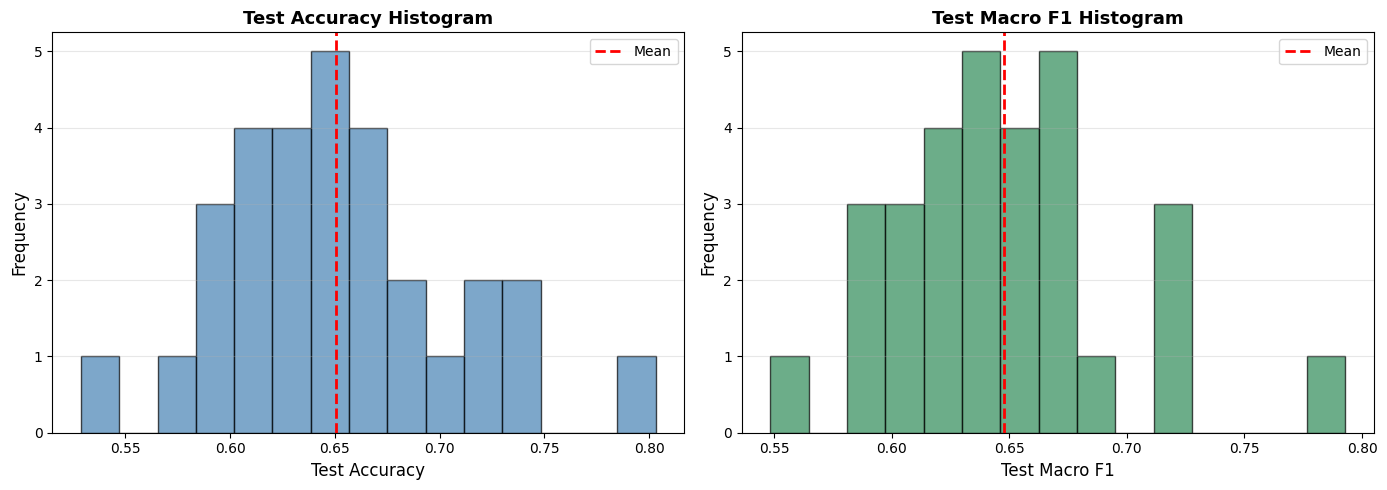

In [8]:
# Plot distributions for front-view runs
plot_multi_run_distributions(multi_run_results_front, aggregated_stats_front)


FRONT VIEW: BEST vs WORST RUN COMPARISON
Best Run:  #5 (seed=47) - Acc: 0.8032, F1: 0.7928
Worst Run: #17 (seed=59) - Acc: 0.5287, F1: 0.5485


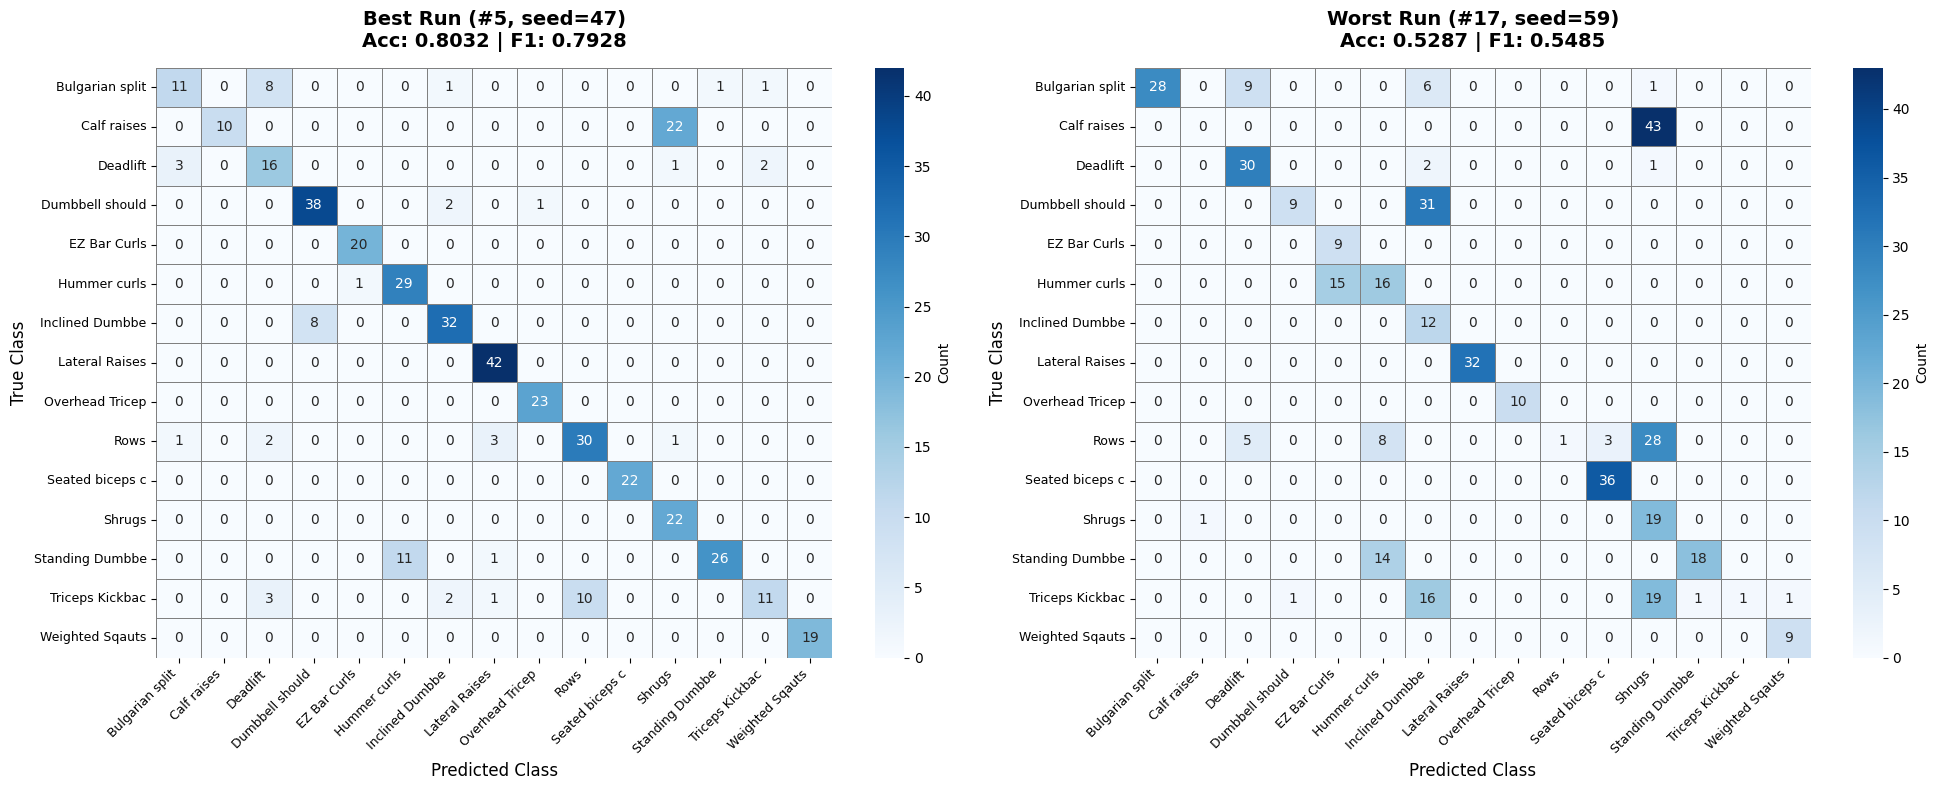


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.5946     0.7778     -0.1832
1        0.4762     0.0000      0.4762
2        0.6275     0.7792     -0.1518
3        0.8736     0.3600      0.5136
4        0.9756     0.5455      0.4302
5        0.8286     0.4638      0.3648
6        0.8312     0.3038      0.5274
7        0.9438     1.0000     -0.0562
8        0.9787     1.0000     -0.0213
9        0.7792     0.0435      0.7357
10       1.0000     0.9600      0.0400
11       0.6471     0.2901      0.3570
12       0.8000     0.7059      0.0941
13       0.5366     0.0500      0.4866
14       1.0000     0.9474      0.0526


In [9]:
# Best vs worst run comparison for front-view
label_names = sorted(multi_run_results_front[0]['label_to_int'].keys())
ordered_labels = sort_labels_by_numeric_prefix(label_names)

print("\n" + "=" * 80)
print("FRONT VIEW: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df_front = plot_best_worst_comparison(multi_run_results_front, ordered_labels)

## Side View: Multi-Run Analysis

Detailed analysis of 30 runs for side-view model.

In [10]:
# Display summary table for side-view runs
print("=" * 80)
print("SIDE VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df_side = display_multi_run_summary(multi_run_results_side, aggregated_stats_side)

SIDE VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.8270 ± 0.0315
  Min: 0.7754
  Max: 0.8952

Test Macro F1:  0.8098 ± 0.0319
  Min: 0.7488
  Max: 0.8825


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min     max
Class                                
0      0.8084  0.0785  0.5714  0.9011
1      0.9027  0.0606  0.7089  1.0000
2      0.8816  0.0660  0.7692  0.9890
3      0.7242  0.1416  0.2692  0.9250
4      0.8825  0.1146  0.4706  1.0000
5      0.8664  0.1006  0.6250  1.0000
6      0.8834  0.0739  0.7407  1.0000
7      0.7100  0.1416  0.3571  0.9600
8      0.6865  0.1054  0.4528  0.9524
9      0.9304  0.0688  0.7111  1.0000
10     0.9795  0.0268  0.9000  1.0000
11     0.4367  0.2224  0.0000  0.8500
12     0.7211  0.1559  0.3103  0.9841
13     0.9068  0.0765  0.6494  1.0000
14     0.8276  0.1003  0.5161  1.0000


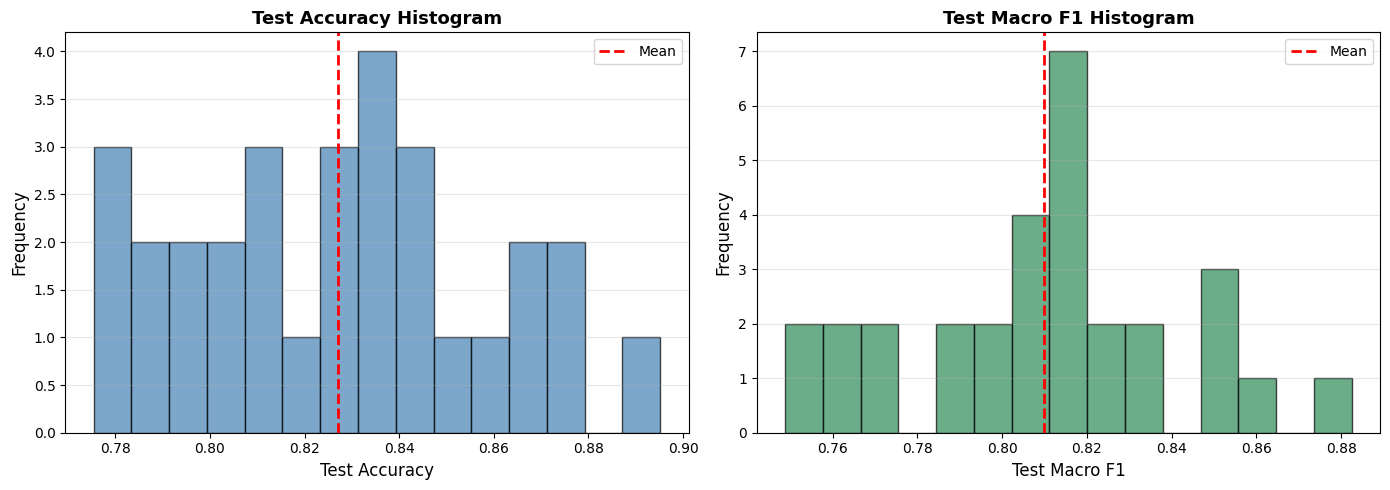

In [11]:
# Plot distributions for side-view runs
plot_multi_run_distributions(multi_run_results_side, aggregated_stats_side)


SIDE VIEW: BEST vs WORST RUN COMPARISON
Best Run:  #3 (seed=45) - Acc: 0.8952, F1: 0.8825
Worst Run: #20 (seed=62) - Acc: 0.7754, F1: 0.7635


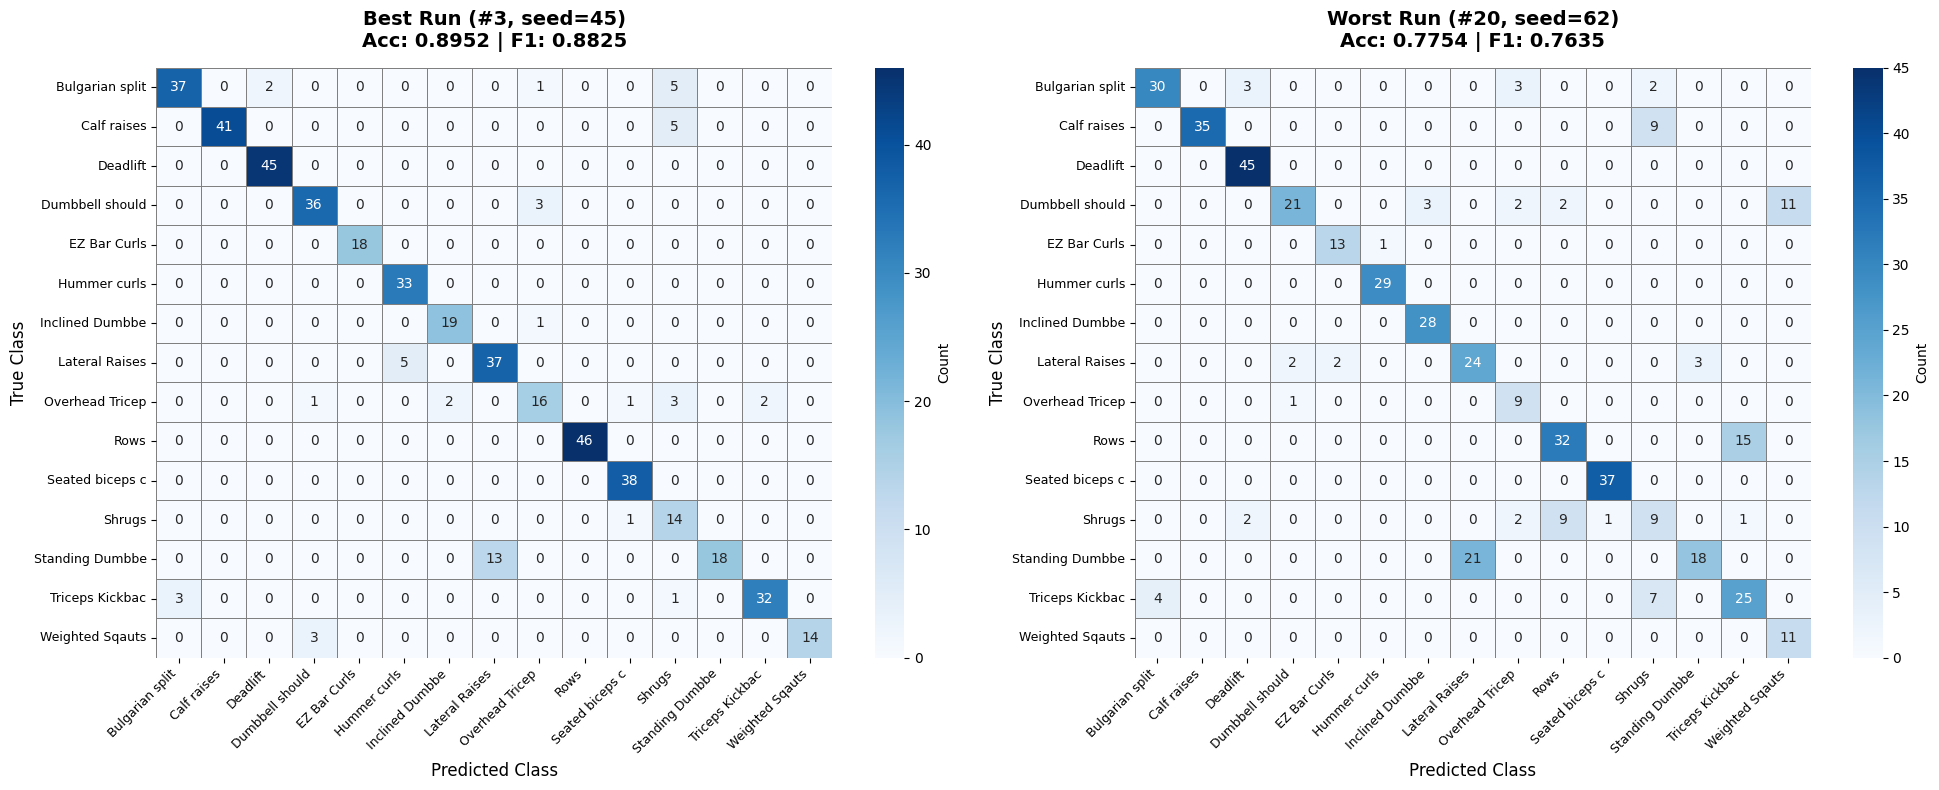


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.8706     0.8333      0.0373
1        0.9425     0.8861      0.0565
2        0.9783     0.9474      0.0309
3        0.9114     0.6667      0.2447
4        1.0000     0.8966      0.1034
5        0.9296     0.9831     -0.0535
6        0.9268     0.9492     -0.0223
7        0.8043     0.6316      0.1728
8        0.6957     0.6923      0.0033
9        1.0000     0.7111      0.2889
10       0.9744     0.9867     -0.0123
11       0.6512     0.3529      0.2982
12       0.7347     0.6000      0.1347
13       0.9143     0.6494      0.2649
14       0.9032     0.6667      0.2366


In [12]:
# Best vs worst run comparison for side-view
print("\n" + "=" * 80)
print("SIDE VIEW: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df_side = plot_best_worst_comparison(multi_run_results_side, ordered_labels)

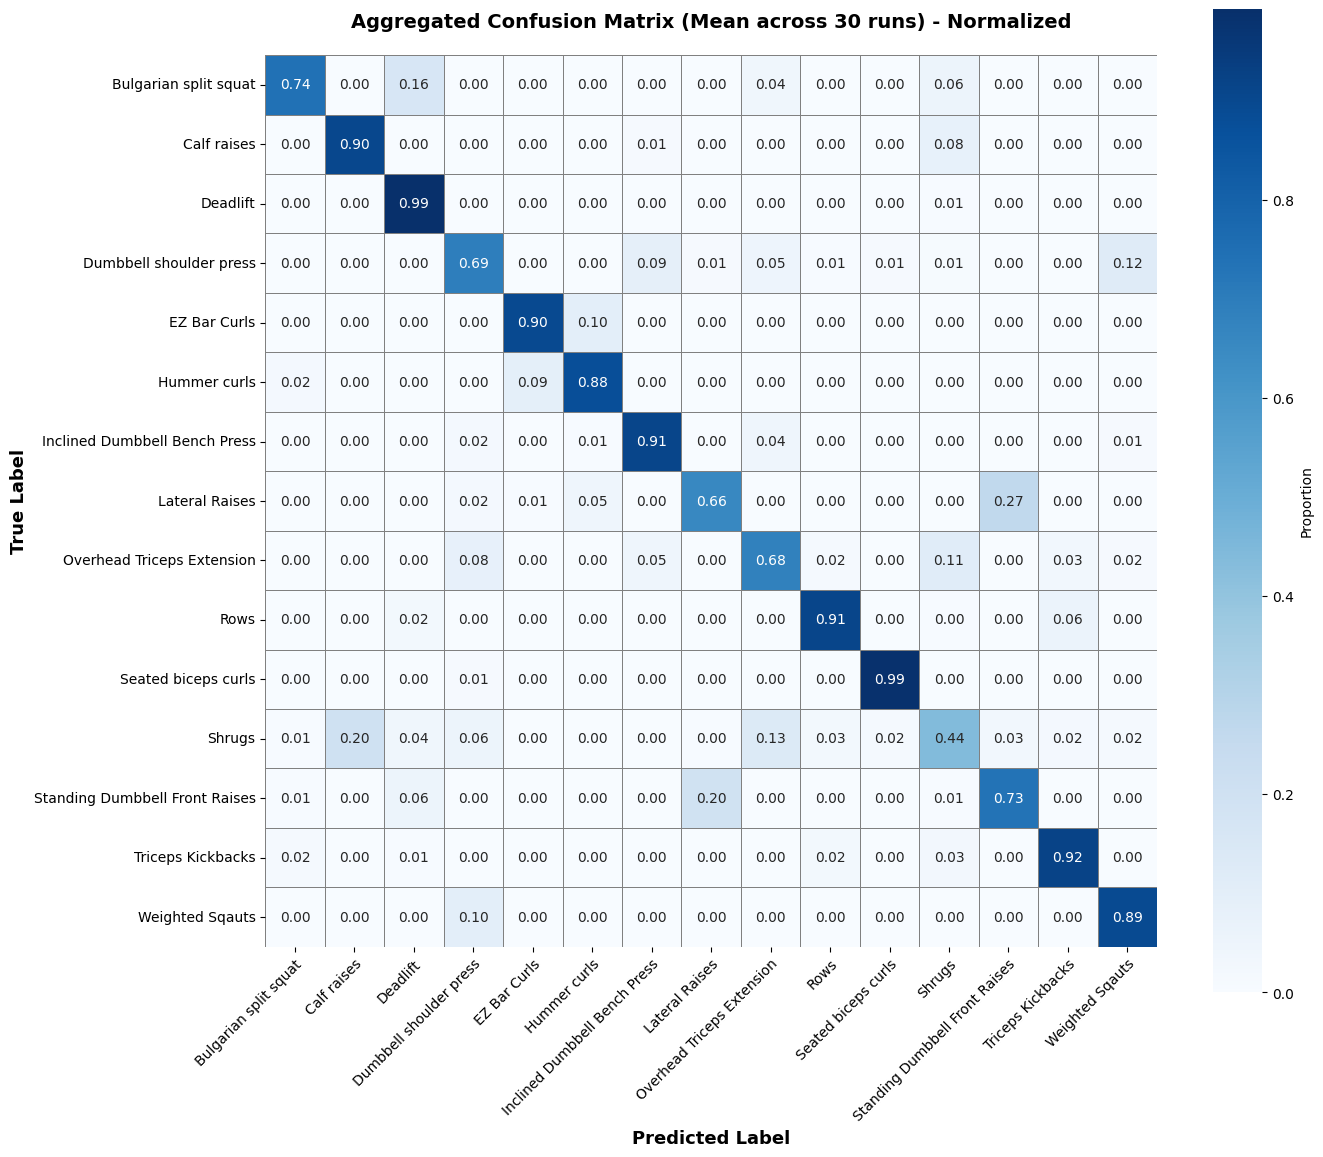

array([[2.44000000e+01, 0.00000000e+00, 5.23333333e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.30000000e+00, 0.00000000e+00, 0.00000000e+00, 1.83333333e+00,
        0.00000000e+00, 6.66666667e-02, 0.00000000e+00],
       [0.00000000e+00, 3.57666667e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.33333333e-01, 0.00000000e+00,
        1.00000000e-01, 0.00000000e+00, 0.00000000e+00, 3.10000000e+00,
        0.00000000e+00, 3.33333333e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.57333333e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.66666667e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.66666667e-02, 2.66000000e+01,
        0.00000000e+00, 0.00000000e+00, 3.43333333e+00, 4.66666667e-01,
        1.93333333e+00, 2.33333333e-0

In [13]:
# Aggregated confusion matrix for side-view
plot_aggregated_confusion_matrix(
    multi_run_results_side,
    label_names=ordered_labels,
    desired_class_order=ordered_labels,
    normalize=True
)

---

## Cross-Model Visualizations: Front vs Side

Side-by-side comparisons of best runs from each view.

In [14]:
# Get best runs from each view for detailed comparison
best_run_front = max(multi_run_results_front, key=lambda x: x['test_metrics']['macro_f1'])
best_run_side = max(multi_run_results_side, key=lambda x: x['test_metrics']['macro_f1'])

print("Best Run Performance:")
print(f"  Front View - Accuracy: {best_run_front['test_metrics']['accuracy']:.4f}, Macro F1: {best_run_front['test_metrics']['macro_f1']:.4f}")
print(f"  Side View  - Accuracy: {best_run_side['test_metrics']['accuracy']:.4f}, Macro F1: {best_run_side['test_metrics']['macro_f1']:.4f}")

Best Run Performance:
  Front View - Accuracy: 0.8032, Macro F1: 0.7928
  Side View  - Accuracy: 0.8952, Macro F1: 0.8825


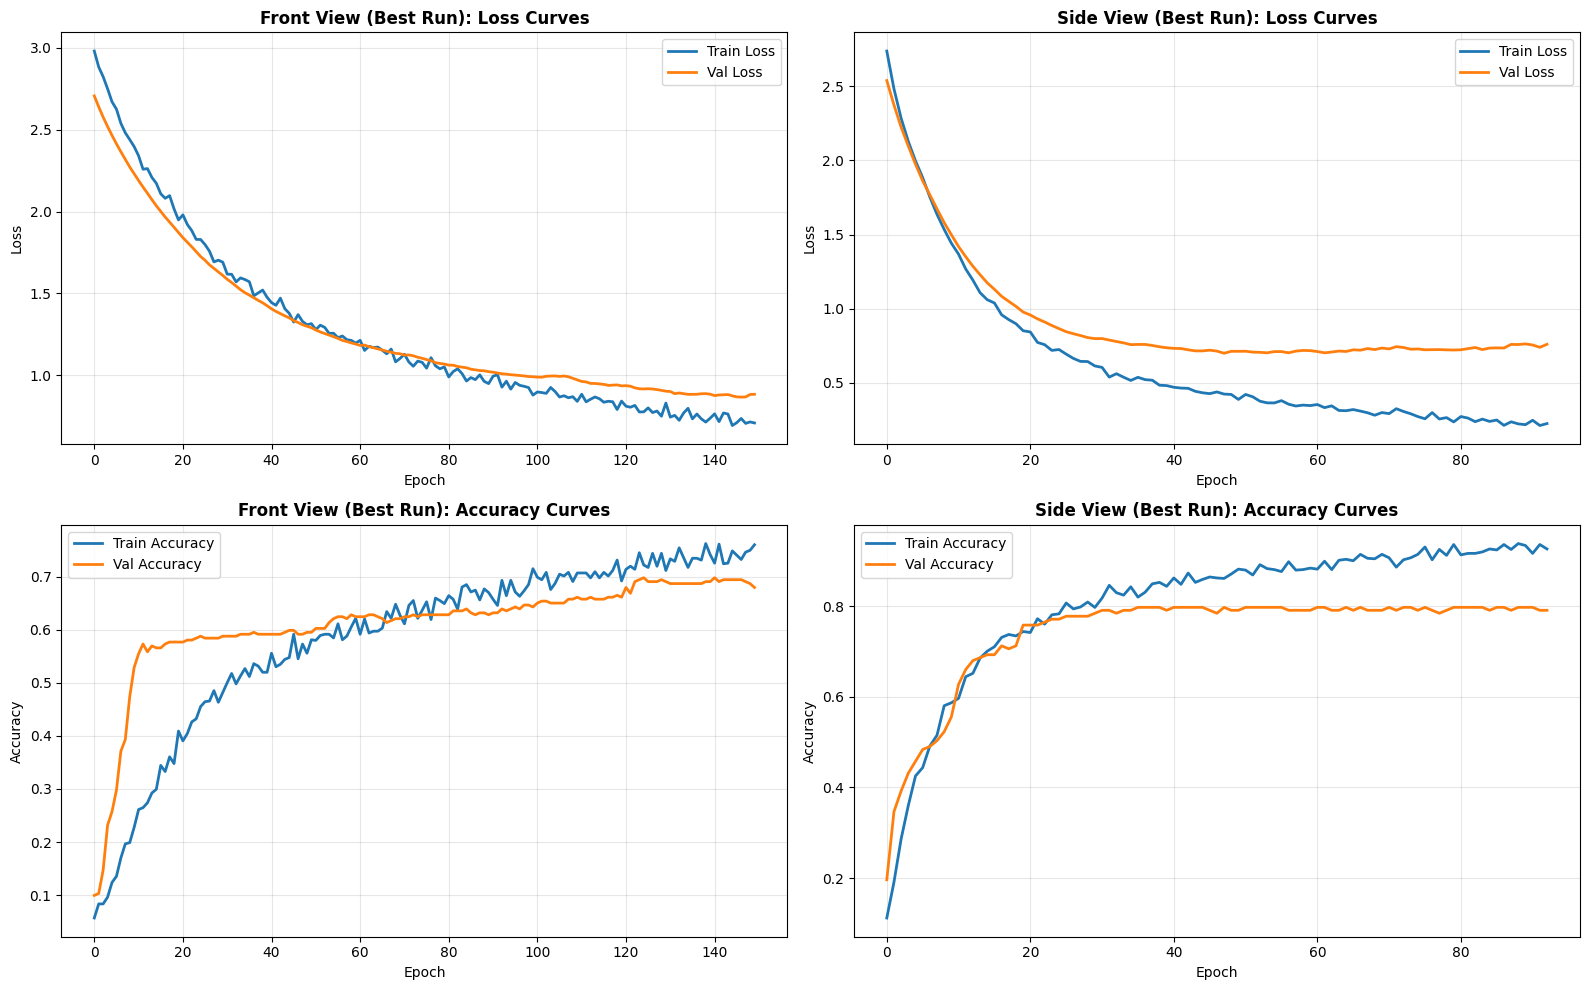

Front View (Best Run) training: 150 epochs
Side View (Best Run) training: 93 epochs


In [15]:
# Plot training curves for best runs side-by-side
plot_dual_training_history(
    best_run_front['history'],
    best_run_side['history'],
    model_names=['Front View (Best Run)', 'Side View (Best Run)']
)

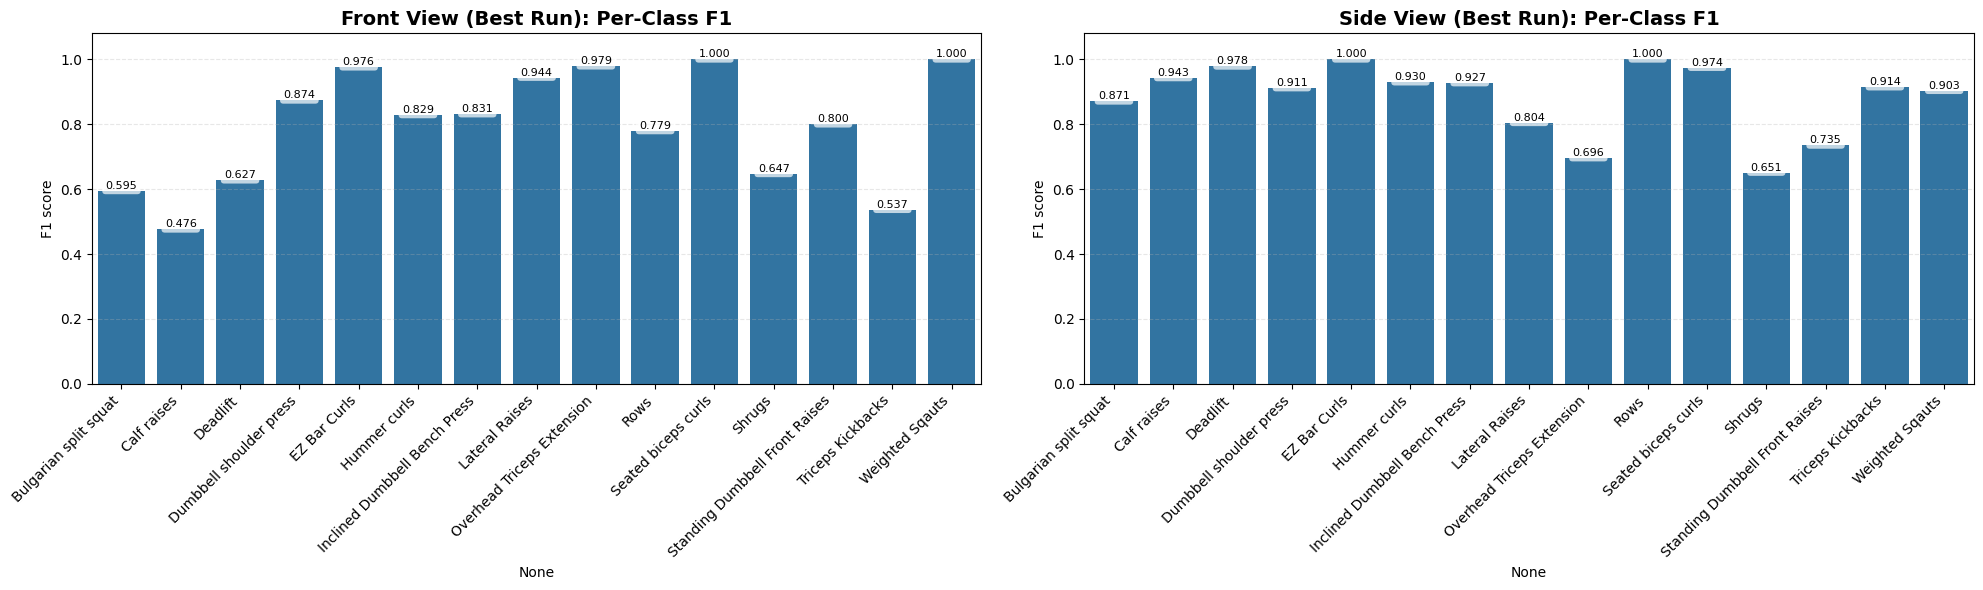

In [16]:
# Side-by-side per-class F1 comparison (best runs)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

idx_to_label = {int(k): v for k, v in best_run_front['int_to_label'].items()}

per_class_f1_front = plot_per_class_f1_scores(
    best_run_front['test_metrics']['per_class_f1'],
    idx_to_label,
    desired_class_order=ordered_labels,
    ax=axes[0]
)
axes[0].set_title('Front View (Best Run): Per-Class F1', fontsize=14, fontweight='bold')

per_class_f1_side = plot_per_class_f1_scores(
    best_run_side['test_metrics']['per_class_f1'],
    idx_to_label,
    desired_class_order=ordered_labels,
    ax=axes[1]
)
axes[1].set_title('Side View (Best Run): Per-Class F1', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

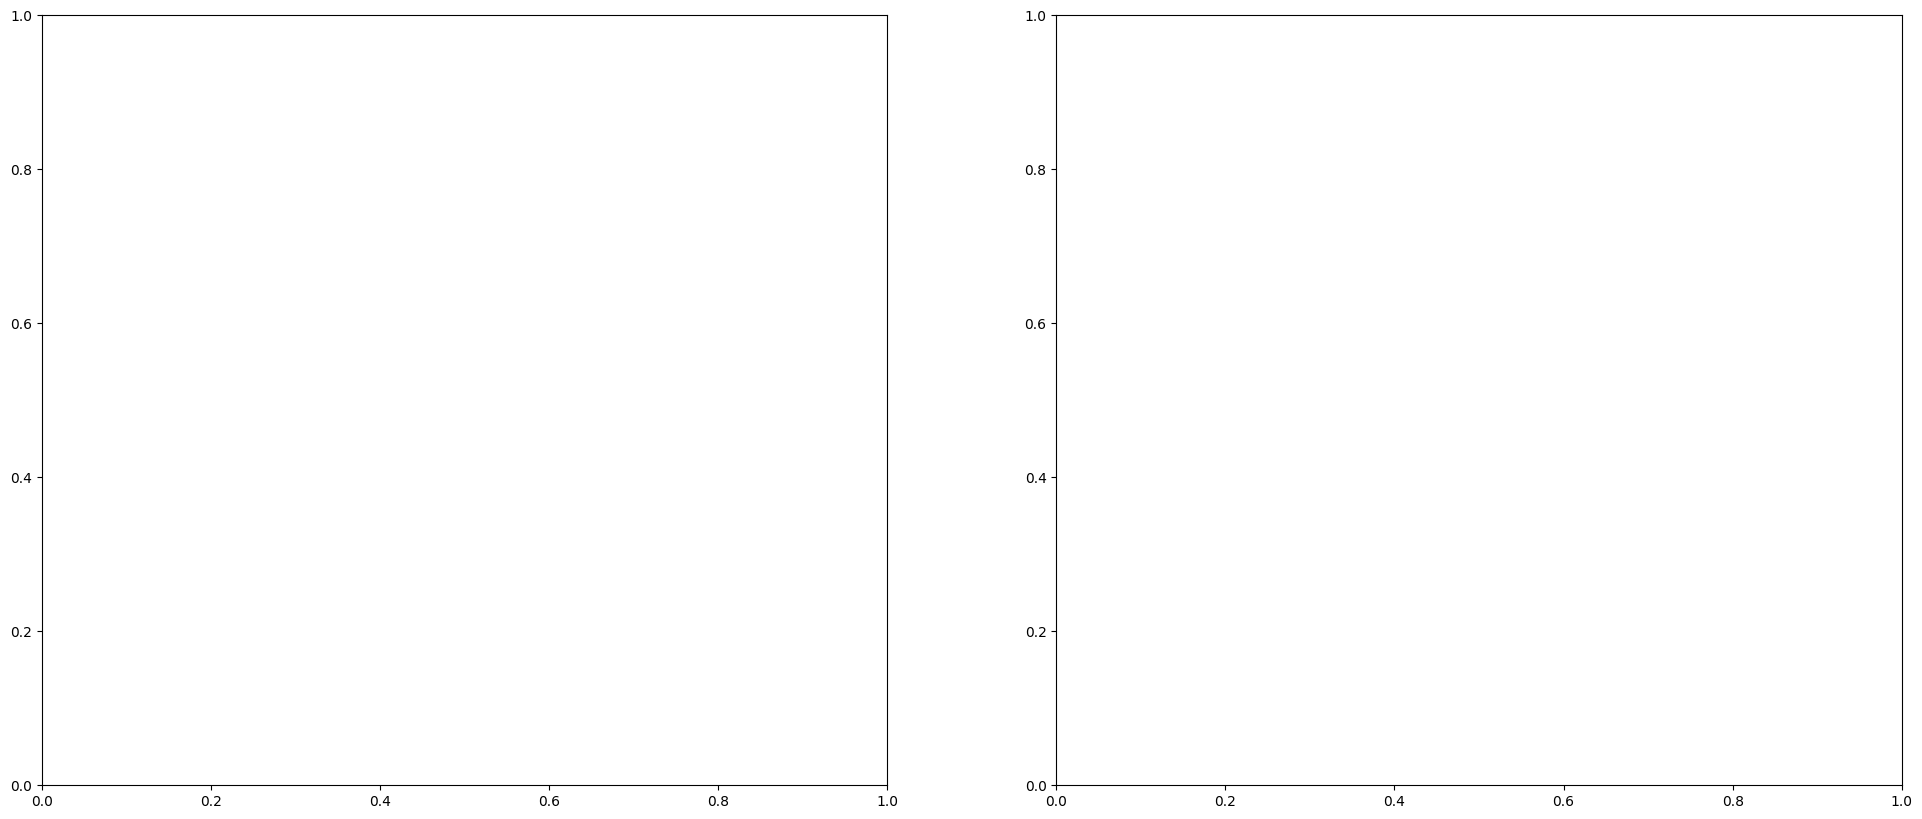

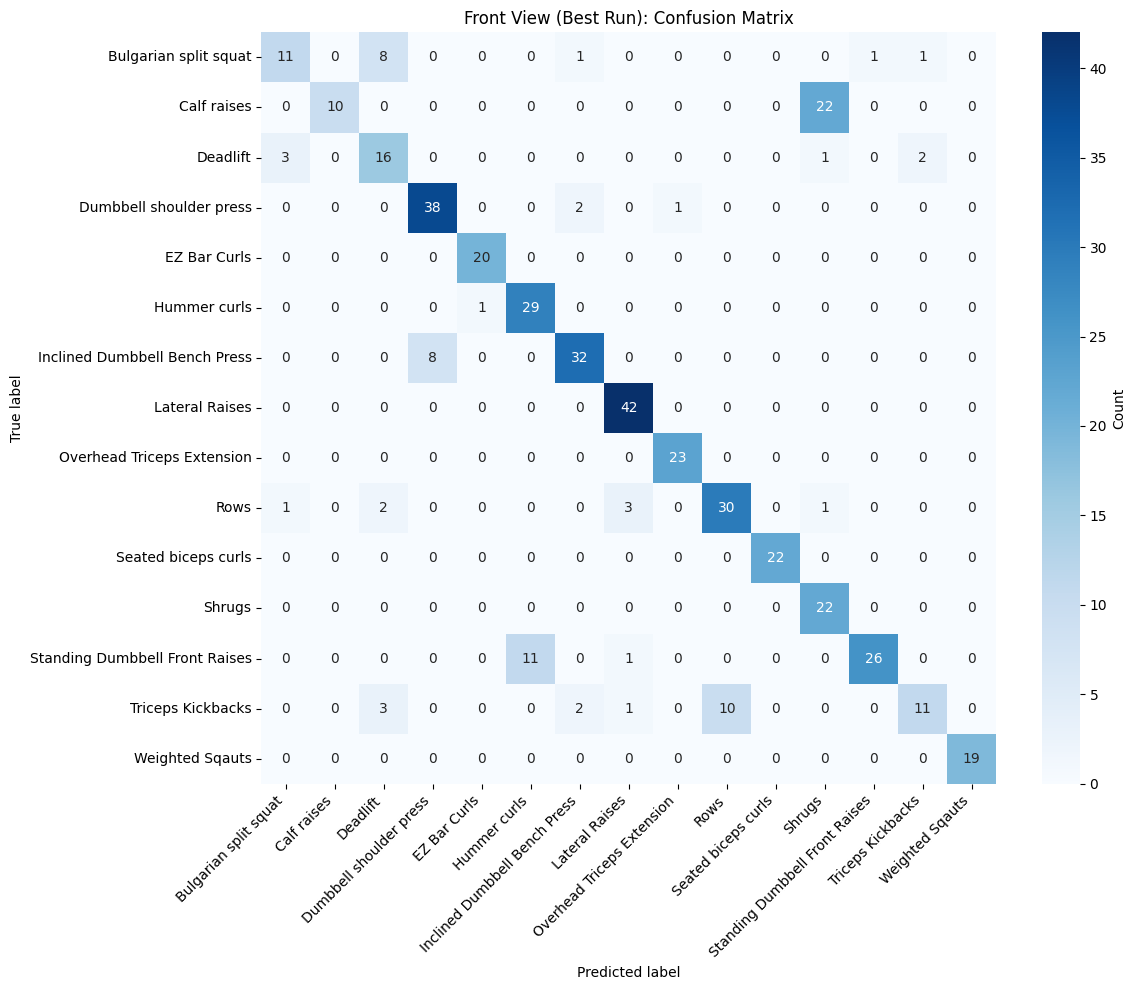

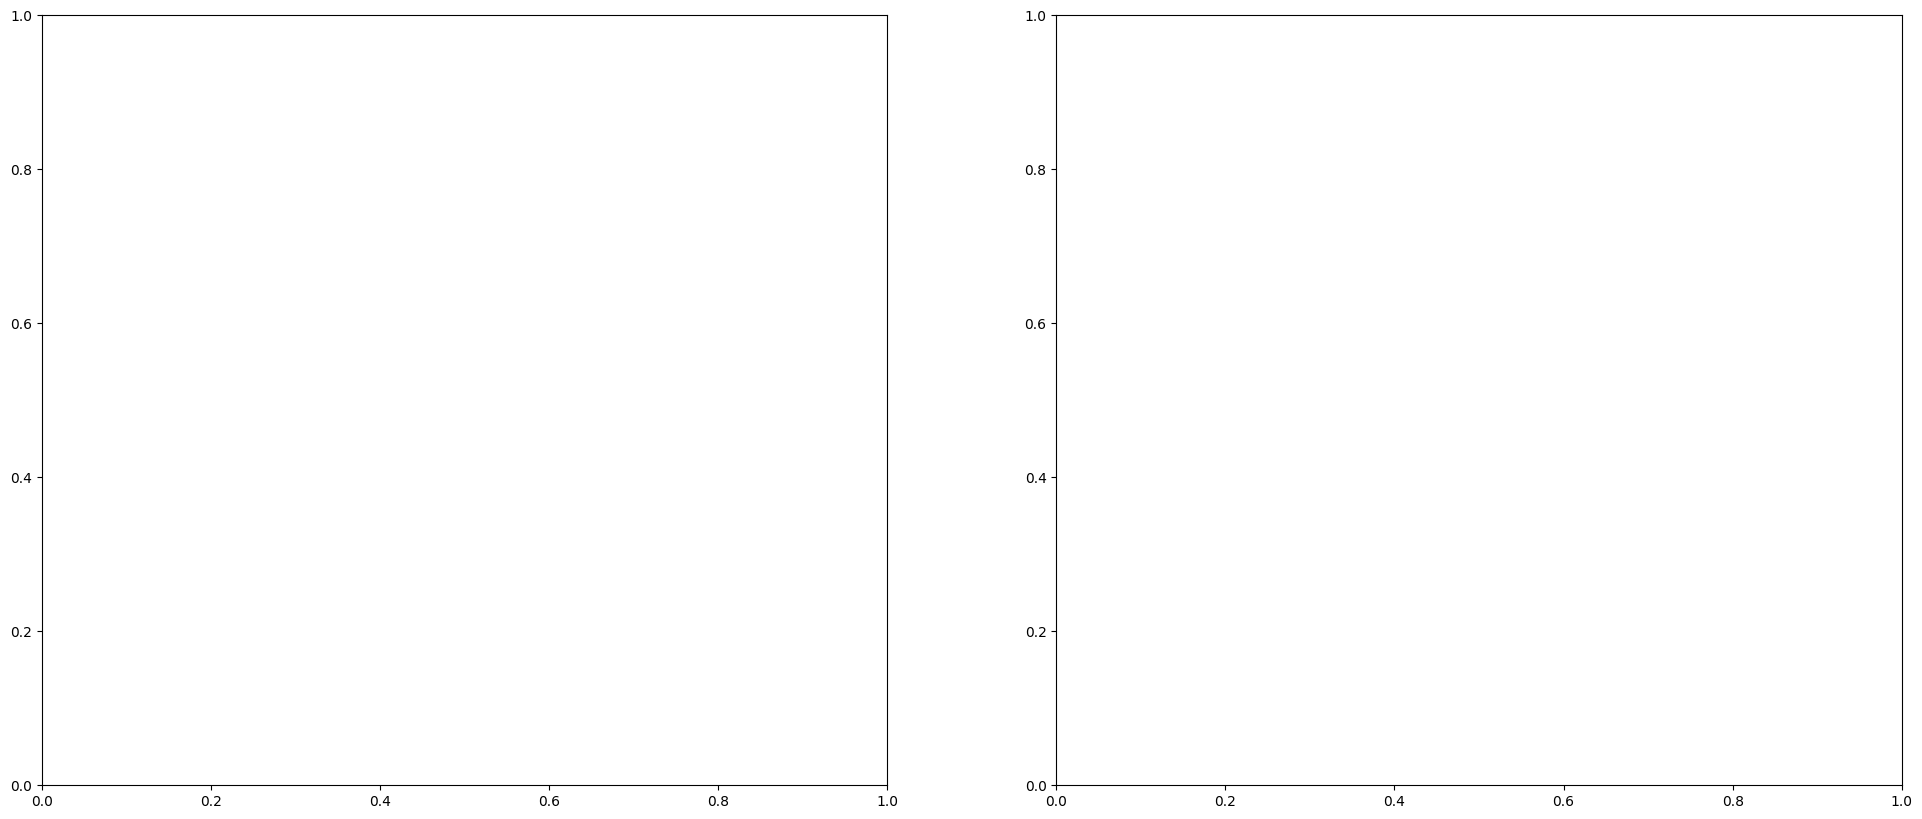

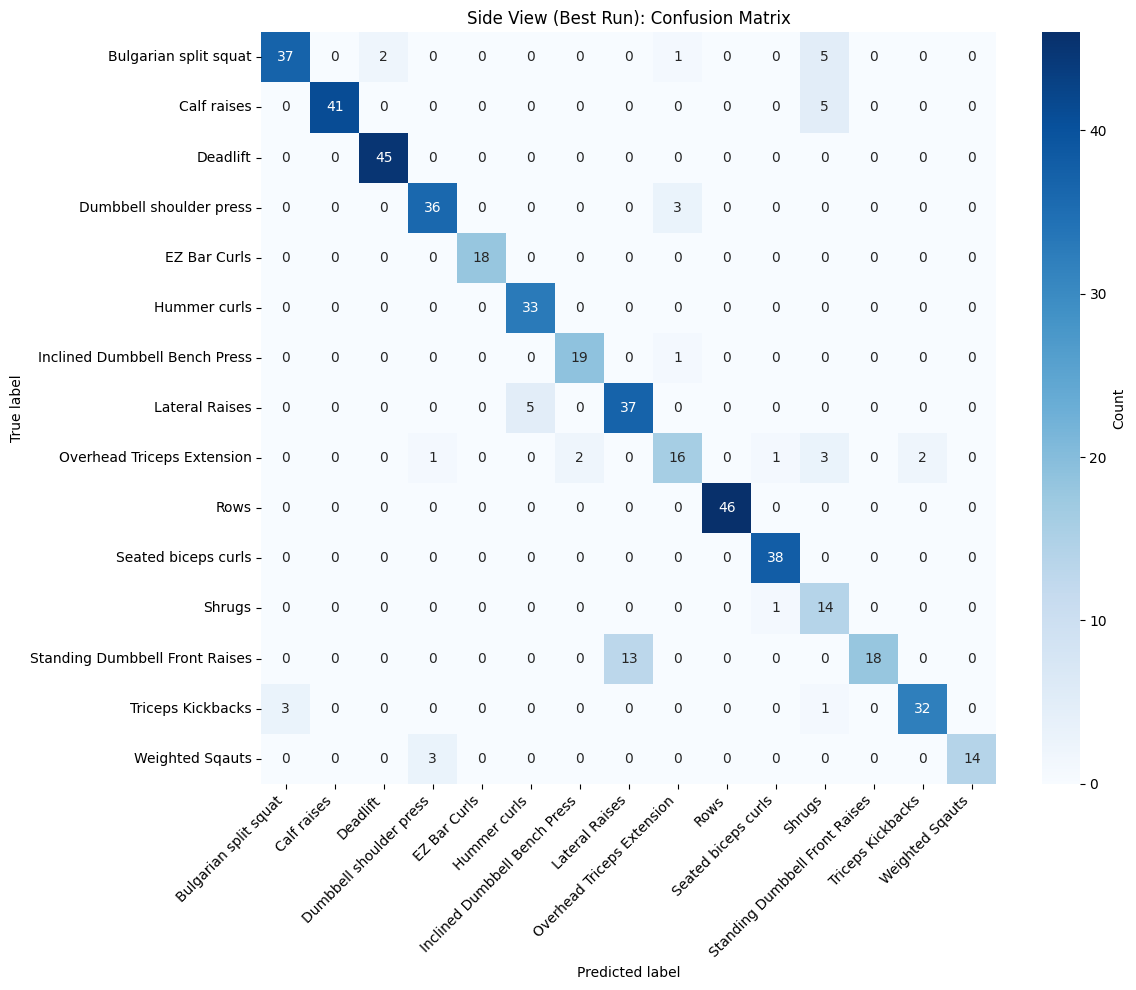

<Figure size 640x480 with 0 Axes>

In [17]:
# Side-by-side confusion matrices (best runs)
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

conf_matrix_front = np.array(best_run_front['test_metrics']['confusion_matrix'])
plt.sca(axes[0])
plot_confusion_matrix_from_metrics(
    conf_matrix_front,
    current_class_order=label_names,
    desired_class_order=ordered_labels,
    normalize=False,
    title='Front View (Best Run): Confusion Matrix'
)

conf_matrix_side = np.array(best_run_side['test_metrics']['confusion_matrix'])
plt.sca(axes[1])
plot_confusion_matrix_from_metrics(
    conf_matrix_side,
    current_class_order=label_names,
    desired_class_order=ordered_labels,
    normalize=False,
    title='Side View (Best Run): Confusion Matrix'
)

plt.tight_layout()
plt.show()

# Experiment 6: Temporal Pose MLP (Front vs Side - Multi-Run)

---

## Part 2: Temporal Features Baseline

This section compares **temporal pose sequences (flattened)** vs the static statistical features above.

**Key Differences from Static:**
- **Data:** Temporal sequences (50 timesteps × angles) flattened to 1D vectors
- **Files:** `pose_data_front_temporal.npz` and `pose_data_side_temporal.npz`
- **Feature Engineering:** Raw temporal sequences (350-450 dims) vs hand-crafted statistics (35-45 dims)
- **Goal:** Test if raw temporal data contains more discriminative information than statistics
- **Architecture:** Same MLP architecture (fair comparison, temporal order not exploited)
- **Future Work:** LSTM/1D-CNN architectures will leverage temporal ordering

**Feature Dimensionality:**
- **Front Temporal:** 8 selected angles × 50 timesteps = 400 features
- **Side Temporal:** 7 selected angles × 50 timesteps = 350 features
- **Static (for comparison):** 8-9 angles × 5 statistics = 40-45 features

In [18]:
# Reload modules to pick up temporal training functions
importlib.reload(src.data.data_loader)
importlib.reload(src.scripts.experiment_6)

from src.data.data_loader import load_pose_temporal_data
from src.scripts.experiment_6 import train_experiment_6_temporal_multi_run

In [19]:
# Define paths to temporal pose NPZ files
front_temporal_npz = PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_front_temporal.npz'
side_temporal_npz = PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_side_temporal.npz'

# Load and summarize front-view temporal data
front_temporal_dataset, front_temporal_summary = load_pose_temporal_data(str(front_temporal_npz))
print("Front-view temporal features:")
print(f"  Samples: {front_temporal_summary['count']}")
print(f"  Subjects: {front_temporal_summary['unique_subjects']}")
print(f"  Classes: {front_temporal_summary['unique_classes']}")
print(f"  Temporal shape: {front_temporal_summary['temporal_shape']} (timesteps × angles)")
print(f"  Flattened to: {front_temporal_summary['temporal_shape'][0] * front_temporal_summary['temporal_shape'][1]} features per sample")

# Load and summarize side-view temporal data
side_temporal_dataset, side_temporal_summary = load_pose_temporal_data(str(side_temporal_npz))
print("\nSide-view temporal features:")
print(f"  Samples: {side_temporal_summary['count']}")
print(f"  Subjects: {side_temporal_summary['unique_subjects']}")
print(f"  Classes: {side_temporal_summary['unique_classes']}")
print(f"  Temporal shape: {side_temporal_summary['temporal_shape']} (timesteps × angles)")
print(f"  Flattened to: {side_temporal_summary['temporal_shape'][0] * side_temporal_summary['temporal_shape'][1]} features per sample")

INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)


Front-view temporal features:
  Samples: 1574
  Subjects: 49
  Classes: 15
  Temporal shape: (50, 9) (timesteps × angles)
  Flattened to: 450 features per sample

Side-view temporal features:
  Samples: 1571
  Subjects: 49
  Classes: 15
  Temporal shape: (50, 9) (timesteps × angles)
  Flattened to: 450 features per sample


---

## Multi-Run Training: Temporal Front View (30 Runs)

Execute 30 training runs with different random seeds using `config/experiment_6_temporal_front.yaml`.

**Configuration:**
- Temporal sequences flattened to 1D vectors (8 angles × 50 timesteps = 400 features)
- Results saved to `experiments/exer_recog/results/exp_06_pose_mlp_temporal/front/`
- Same MLP architecture as static (256 → 128 hidden layers)
- Early stopping with patience=30 on validation loss

In [20]:
# Train temporal front-view model with multi-run (30 runs)
print("=" * 80)
print("MULTI-RUN TRAINING: TEMPORAL FRONT VIEW (30 RUNS)")
print("=" * 80)

config_path_temporal_front = PROJECT_ROOT / 'config' / 'experiment_6_temporal_front.yaml'

multi_run_results_temporal_front, aggregated_stats_temporal_front = train_experiment_6_temporal_multi_run(
    npz_path=str(front_temporal_npz),
    config_path=str(config_path_temporal_front)
)

print("\n✅ Temporal front-view multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats_temporal_front['test_accuracy']['mean']:.4f} ± {aggregated_stats_temporal_front['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats_temporal_front['test_macro_f1']['mean']:.4f} ± {aggregated_stats_temporal_front['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_temporal/front/multi_run_003
INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=900, val=207, test=467, classes=15
INFO - Datasets built with feature_dim=450


MULTI-RUN TRAINING: TEMPORAL FRONT VIEW (30 RUNS)
Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1767 - loss: 2.7365 - val_accuracy: 0.6377 - val_loss: 1.9855 - learning_rate: 8.0000e-05
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2978 - loss: 2.1705 - val_accuracy: 0.6522 - val_loss: 1.6318 - learning_rate: 8.0000e-05
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4144 - loss: 1.8229 - val_accuracy: 0.6570 - val_loss: 1.3748 - learning_rate: 8.0000e-05
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5156 - loss: 1.5357 - val_accuracy: 0.6522 - val_loss: 1.2521 - learning_rate: 8.0000e-05
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6078 - loss: 1.3031 - val_accuracy: 0.7343 - val_loss: 1.1098 - learning_rate: 8.0000e-05
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6378 - loss: 1.1742 - val_accuracy: 0.7729 - val_loss: 1.0864 - learning_rate: 8.0000e-05
Epoch 7/150
75/75 ━

INFO - Experiment 6 (temporal) complete. Test acc=0.7559, macro F1=0.7514
INFO - Run 1 complete: acc=0.7559, macro_f1=0.7514
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=835, val=210, test=529, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1760 - loss: 2.6370 - val_accuracy: 0.5333 - val_loss: 1.7738 - learning_rate: 8.0000e-05
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3521 - loss: 2.0685 - val_accuracy: 0.6762 - val_loss: 1.4277 - learning_rate: 8.0000e-05
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4563 - loss: 1.6711 - val_accuracy: 0.7333 - val_loss: 1.1958 - learning_rate: 8.0000e-05
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5437 - loss: 1.4430 - val_accuracy: 0.7524 - val_loss: 1.0737 - learning_rate: 8.0000e-05
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6060 - loss: 1.2858 - val_accuracy: 0.7619 - val_loss: 0.9169 - learning_rate: 8.0000e-05
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6958 - loss: 1.1156 - val_accuracy: 0.7762 - val_loss: 0.8966 - learning_rate: 8.0000e-05
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6731

INFO - Experiment 6 (temporal) complete. Test acc=0.7146, macro F1=0.7043
INFO - Run 2 complete: acc=0.7146, macro_f1=0.7043
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=818, val=207, test=549, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1601 - loss: 2.7939 - val_accuracy: 0.3140 - val_loss: 2.2459 - learning_rate: 8.0000e-05
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3337 - loss: 2.0810 - val_accuracy: 0.5507 - val_loss: 1.8750 - learning_rate: 8.0000e-05
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4511 - loss: 1.7509 - val_accuracy: 0.5894 - val_loss: 1.6222 - learning_rate: 8.0000e-05
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5110 - loss: 1.5462 - val_accuracy: 0.6473 - val_loss: 1.3795 - learning_rate: 8.0000e-05
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6027 - loss: 1.3334 - val_accuracy: 0.6329 - val_loss: 1.2536 - learning_rate: 8.0000e-05
Epoch 6/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6418 - loss: 1.1654 - val_accuracy: 0.7053 - val_loss: 1.2127 - learning_rate: 8.0000e-05
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760

INFO - Experiment 6 (temporal) complete. Test acc=0.6995, macro F1=0.7009
INFO - Run 3 complete: acc=0.6995, macro_f1=0.7009
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=876, val=255, test=443, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1587 - loss: 2.7480 - val_accuracy: 0.3059 - val_loss: 2.3124 - learning_rate: 8.0000e-05
Epoch 2/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3265 - loss: 2.0929 - val_accuracy: 0.3686 - val_loss: 2.0275 - learning_rate: 8.0000e-05
Epoch 3/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4692 - loss: 1.7262 - val_accuracy: 0.4275 - val_loss: 1.8680 - learning_rate: 8.0000e-05
Epoch 4/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5457 - loss: 1.4580 - val_accuracy: 0.4353 - val_loss: 1.6878 - learning_rate: 8.0000e-05
Epoch 5/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6096 - loss: 1.3013 - val_accuracy: 0.5020 - val_loss: 1.5392 - learning_rate: 8.0000e-05
Epoch 6/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6747 - loss: 1.0834 - val_accuracy: 0.5373 - val_loss: 1.4521 - learning_rate: 8.0000e-05
Epoch 7/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7203

INFO - Experiment 6 (temporal) complete. Test acc=0.6591, macro F1=0.6249
INFO - Run 4 complete: acc=0.6591, macro_f1=0.6249
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=865, val=272, test=437, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1572 - loss: 2.7716 - val_accuracy: 0.4265 - val_loss: 2.0448 - learning_rate: 8.0000e-05
Epoch 2/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3249 - loss: 2.1104 - val_accuracy: 0.5147 - val_loss: 1.6546 - learning_rate: 8.0000e-05
Epoch 3/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4647 - loss: 1.7860 - val_accuracy: 0.5368 - val_loss: 1.4220 - learning_rate: 8.0000e-05
Epoch 4/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5168 - loss: 1.5545 - val_accuracy: 0.5404 - val_loss: 1.2383 - learning_rate: 8.0000e-05
Epoch 5/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5688 - loss: 1.3452 - val_accuracy: 0.5441 - val_loss: 1.1356 - learning_rate: 8.0000e-05
Epoch 6/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6208 - loss: 1.2129 - val_accuracy: 0.5846 - val_loss: 1.0484 - learning_rate: 8.0000e-05
Epoch 7/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6682

INFO - Experiment 6 (temporal) complete. Test acc=0.7963, macro F1=0.7906
INFO - Run 5 complete: acc=0.7963, macro_f1=0.7906
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=934, val=242, test=398, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.1649 - loss: 2.6409 - val_accuracy: 0.4256 - val_loss: 2.2386 - learning_rate: 8.0000e-05
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3694 - loss: 2.0000 - val_accuracy: 0.4504 - val_loss: 1.7858 - learning_rate: 8.0000e-05
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4925 - loss: 1.6342 - val_accuracy: 0.5041 - val_loss: 1.5102 - learning_rate: 8.0000e-05
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5632 - loss: 1.4185 - val_accuracy: 0.5496 - val_loss: 1.3204 - learning_rate: 8.0000e-05
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5846 - loss: 1.2779 - val_accuracy: 0.5537 - val_loss: 1.1987 - learning_rate: 8.0000e-05
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6563 - loss: 1.0931 - val_accuracy: 0.5909 - val_loss: 1.0304 - learning_rate: 8.0000e-05
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6916

INFO - Experiment 6 (temporal) complete. Test acc=0.7261, macro F1=0.7135
INFO - Run 6 complete: acc=0.7261, macro_f1=0.7135
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=871, val=242, test=461, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.1584 - loss: 2.7351 - val_accuracy: 0.4917 - val_loss: 1.8362 - learning_rate: 8.0000e-05
Epoch 2/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3754 - loss: 1.9798 - val_accuracy: 0.6074 - val_loss: 1.4878 - learning_rate: 8.0000e-05
Epoch 3/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4650 - loss: 1.6771 - val_accuracy: 0.6322 - val_loss: 1.2148 - learning_rate: 8.0000e-05
Epoch 4/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 1.4374 - val_accuracy: 0.6942 - val_loss: 1.0286 - learning_rate: 8.0000e-05
Epoch 5/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6280 - loss: 1.2139 - val_accuracy: 0.7066 - val_loss: 0.9120 - learning_rate: 8.0000e-05
Epoch 6/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6728 - loss: 1.0727 - val_accuracy: 0.6983 - val_loss: 0.8641 - learning_rate: 8.0000e-05
Epoch 7/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6900

INFO - Experiment 6 (temporal) complete. Test acc=0.7093, macro F1=0.7292
INFO - Run 7 complete: acc=0.7093, macro_f1=0.7292
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=905, val=275, test=394, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.1834 - loss: 2.6550 - val_accuracy: 0.3891 - val_loss: 2.0822 - learning_rate: 8.0000e-05
Epoch 2/150
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3713 - loss: 2.0518 - val_accuracy: 0.4909 - val_loss: 1.7543 - learning_rate: 8.0000e-05
Epoch 3/150
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4829 - loss: 1.6679 - val_accuracy: 0.5382 - val_loss: 1.5456 - learning_rate: 8.0000e-05
Epoch 4/150
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5381 - loss: 1.4959 - val_accuracy: 0.5091 - val_loss: 1.3805 - learning_rate: 8.0000e-05
Epoch 5/150
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6199 - loss: 1.2732 - val_accuracy: 0.5418 - val_loss: 1.1964 - learning_rate: 8.0000e-05
Epoch 6/150
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6707 - loss: 1.1048 - val_accuracy: 0.5564 - val_loss: 1.1157 - learning_rate: 8.0000e-05
Epoch 7/150
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6961

INFO - Experiment 6 (temporal) complete. Test acc=0.7970, macro F1=0.7571
INFO - Run 8 complete: acc=0.7970, macro_f1=0.7571
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=849, val=199, test=526, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.1307 - loss: 2.8295 - val_accuracy: 0.4724 - val_loss: 1.9826 - learning_rate: 8.0000e-05
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2815 - loss: 2.1820 - val_accuracy: 0.6281 - val_loss: 1.6089 - learning_rate: 8.0000e-05
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4346 - loss: 1.8064 - val_accuracy: 0.6633 - val_loss: 1.3724 - learning_rate: 8.0000e-05
Epoch 4/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5383 - loss: 1.5310 - val_accuracy: 0.7236 - val_loss: 1.1830 - learning_rate: 8.0000e-05
Epoch 5/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5866 - loss: 1.3977 - val_accuracy: 0.7437 - val_loss: 1.0463 - learning_rate: 8.0000e-05
Epoch 6/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6078 - loss: 1.2789 - val_accuracy: 0.7437 - val_loss: 0.9338 - learning_rate: 8.0000e-05
Epoch 7/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6455

INFO - Experiment 6 (temporal) complete. Test acc=0.7605, macro F1=0.7703
INFO - Run 9 complete: acc=0.7605, macro_f1=0.7703
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises', 'Deadlift', 'Calf raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=875, val=167, test=532, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.1349 - loss: 2.7813 - val_accuracy: 0.3713 - val_loss: 2.1723 - learning_rate: 8.0000e-05
Epoch 2/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2834 - loss: 2.2368 - val_accuracy: 0.4671 - val_loss: 1.8196 - learning_rate: 8.0000e-05
Epoch 3/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4069 - loss: 1.8895 - val_accuracy: 0.6108 - val_loss: 1.5320 - learning_rate: 8.0000e-05
Epoch 4/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5280 - loss: 1.5607 - val_accuracy: 0.7066 - val_loss: 1.3031 - learning_rate: 8.0000e-05
Epoch 5/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5966 - loss: 1.3448 - val_accuracy: 0.7126 - val_loss: 1.1869 - learning_rate: 8.0000e-05
Epoch 6/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6491 - loss: 1.1047 - val_accuracy: 0.6587 - val_loss: 1.0925 - learning_rate: 8.0000e-05
Epoch 7/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526

INFO - Experiment 6 (temporal) complete. Test acc=0.6353, macro F1=0.6500
INFO - Run 10 complete: acc=0.6353, macro_f1=0.6500
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=926, val=272, test=376, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1490 - loss: 2.7406 - val_accuracy: 0.4449 - val_loss: 2.1088 - learning_rate: 8.0000e-05
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3099 - loss: 2.1474 - val_accuracy: 0.5221 - val_loss: 1.7831 - learning_rate: 8.0000e-05
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 1.8031 - val_accuracy: 0.6360 - val_loss: 1.5330 - learning_rate: 8.0000e-05
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5346 - loss: 1.5393 - val_accuracy: 0.6544 - val_loss: 1.3601 - learning_rate: 8.0000e-05
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5929 - loss: 1.3151 - val_accuracy: 0.6471 - val_loss: 1.2144 - learning_rate: 8.0000e-05
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6166 - loss: 1.2351 - val_accuracy: 0.6875 - val_loss: 1.0815 - learning_rate: 8.0000e-05
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6566

INFO - Experiment 6 (temporal) complete. Test acc=0.7207, macro F1=0.6898
INFO - Run 11 complete: acc=0.7207, macro_f1=0.6898
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=930, val=185, test=459, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.1731 - loss: 2.6942 - val_accuracy: 0.3676 - val_loss: 2.0672 - learning_rate: 8.0000e-05
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3570 - loss: 1.9948 - val_accuracy: 0.4324 - val_loss: 1.7632 - learning_rate: 8.0000e-05
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4785 - loss: 1.6427 - val_accuracy: 0.4541 - val_loss: 1.5553 - learning_rate: 8.0000e-05
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5839 - loss: 1.4172 - val_accuracy: 0.4973 - val_loss: 1.4761 - learning_rate: 8.0000e-05
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6516 - loss: 1.1802 - val_accuracy: 0.5081 - val_loss: 1.4159 - learning_rate: 8.0000e-05
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6581 - loss: 1.0771 - val_accuracy: 0.5297 - val_loss: 1.3852 - learning_rate: 8.0000e-05
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7097

INFO - Experiment 6 (temporal) complete. Test acc=0.6841, macro F1=0.7019
INFO - Run 12 complete: acc=0.6841, macro_f1=0.7019
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=945, val=283, test=346, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.1323 - loss: 2.8184 - val_accuracy: 0.3887 - val_loss: 2.1162 - learning_rate: 8.0000e-05
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3206 - loss: 2.1318 - val_accuracy: 0.5371 - val_loss: 1.7214 - learning_rate: 8.0000e-05
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4381 - loss: 1.7225 - val_accuracy: 0.6113 - val_loss: 1.4494 - learning_rate: 8.0000e-05
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5175 - loss: 1.5062 - val_accuracy: 0.6148 - val_loss: 1.2528 - learning_rate: 8.0000e-05
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 1.3583 - val_accuracy: 0.6466 - val_loss: 1.0960 - learning_rate: 8.0000e-05
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6095 - loss: 1.1946 - val_accuracy: 0.6078 - val_loss: 1.0241 - learning_rate: 8.0000e-05
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6519

INFO - Experiment 6 (temporal) complete. Test acc=0.7514, macro F1=0.7223
INFO - Run 13 complete: acc=0.7514, macro_f1=0.7223
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=897, val=251, test=426, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.1806 - loss: 2.7201 - val_accuracy: 0.2829 - val_loss: 2.2490 - learning_rate: 8.0000e-05
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4013 - loss: 1.9851 - val_accuracy: 0.4462 - val_loss: 1.9641 - learning_rate: 8.0000e-05
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5217 - loss: 1.6642 - val_accuracy: 0.4701 - val_loss: 1.7827 - learning_rate: 8.0000e-05
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5396 - loss: 1.5191 - val_accuracy: 0.5697 - val_loss: 1.6191 - learning_rate: 8.0000e-05
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5652 - loss: 1.3533 - val_accuracy: 0.5777 - val_loss: 1.5024 - learning_rate: 8.0000e-05
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6421 - loss: 1.1338 - val_accuracy: 0.6335 - val_loss: 1.3967 - learning_rate: 8.0000e-05
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6577

INFO - Experiment 6 (temporal) complete. Test acc=0.6150, macro F1=0.6136
INFO - Run 14 complete: acc=0.6150, macro_f1=0.6136
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=897, val=170, test=507, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.1895 - loss: 2.6206 - val_accuracy: 0.2529 - val_loss: 2.2051 - learning_rate: 8.0000e-05
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3623 - loss: 2.0125 - val_accuracy: 0.3941 - val_loss: 1.9745 - learning_rate: 8.0000e-05
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4760 - loss: 1.7135 - val_accuracy: 0.4941 - val_loss: 1.7864 - learning_rate: 8.0000e-05
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5195 - loss: 1.4653 - val_accuracy: 0.5118 - val_loss: 1.7762 - learning_rate: 8.0000e-05
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5786 - loss: 1.2923 - val_accuracy: 0.5235 - val_loss: 1.9108 - learning_rate: 8.0000e-05
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6499 - loss: 1.1346 - val_accuracy: 0.5412 - val_loss: 2.0206 - learning_rate: 8.0000e-05
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6734

INFO - Experiment 6 (temporal) complete. Test acc=0.6193, macro F1=0.6312
INFO - Run 15 complete: acc=0.6193, macro_f1=0.6312
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=824, val=214, test=536, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.1432 - loss: 2.7134 - val_accuracy: 0.4766 - val_loss: 2.0878 - learning_rate: 8.0000e-05
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3398 - loss: 2.1007 - val_accuracy: 0.6262 - val_loss: 1.7448 - learning_rate: 8.0000e-05
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4405 - loss: 1.7930 - val_accuracy: 0.6495 - val_loss: 1.4900 - learning_rate: 8.0000e-05
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5461 - loss: 1.5137 - val_accuracy: 0.6776 - val_loss: 1.2999 - learning_rate: 8.0000e-05
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6226 - loss: 1.3131 - val_accuracy: 0.6589 - val_loss: 1.2060 - learning_rate: 8.0000e-05
Epoch 6/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 1.1747 - val_accuracy: 0.6776 - val_loss: 1.1186 - learning_rate: 8.0000e-05
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6784

INFO - Experiment 6 (temporal) complete. Test acc=0.7239, macro F1=0.7094
INFO - Run 16 complete: acc=0.7239, macro_f1=0.7094
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=942, val=197, test=435, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.1699 - loss: 2.6247 - val_accuracy: 0.3706 - val_loss: 2.2046 - learning_rate: 8.0000e-05
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4066 - loss: 1.9193 - val_accuracy: 0.3655 - val_loss: 1.9186 - learning_rate: 8.0000e-05
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5138 - loss: 1.5485 - val_accuracy: 0.4264 - val_loss: 1.7341 - learning_rate: 8.0000e-05
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5892 - loss: 1.3324 - val_accuracy: 0.4721 - val_loss: 1.6212 - learning_rate: 8.0000e-05
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6423 - loss: 1.1542 - val_accuracy: 0.5228 - val_loss: 1.4889 - learning_rate: 8.0000e-05
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6975 - loss: 0.9885 - val_accuracy: 0.5381 - val_loss: 1.4038 - learning_rate: 8.0000e-05
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7059

INFO - Experiment 6 (temporal) complete. Test acc=0.5586, macro F1=0.5813
INFO - Run 17 complete: acc=0.5586, macro_f1=0.5813
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=843, val=288, test=443, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.1661 - loss: 2.7074 - val_accuracy: 0.5035 - val_loss: 2.1135 - learning_rate: 8.0000e-05
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3203 - loss: 1.9982 - val_accuracy: 0.5486 - val_loss: 1.8488 - learning_rate: 8.0000e-05
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3986 - loss: 1.8027 - val_accuracy: 0.5868 - val_loss: 1.6486 - learning_rate: 8.0000e-05
Epoch 4/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5243 - loss: 1.4782 - val_accuracy: 0.5417 - val_loss: 1.5013 - learning_rate: 8.0000e-05
Epoch 5/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5540 - loss: 1.3499 - val_accuracy: 0.6354 - val_loss: 1.3209 - learning_rate: 8.0000e-05
Epoch 6/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5789 - loss: 1.2253 - val_accuracy: 0.5833 - val_loss: 1.2388 - learning_rate: 8.0000e-05
Epoch 7/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6418

INFO - Experiment 6 (temporal) complete. Test acc=0.7856, macro F1=0.7448
INFO - Run 18 complete: acc=0.7856, macro_f1=0.7448
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=920, val=258, test=396, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.1826 - loss: 2.5636 - val_accuracy: 0.4574 - val_loss: 1.9543 - learning_rate: 8.0000e-05
Epoch 2/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3609 - loss: 2.0316 - val_accuracy: 0.5155 - val_loss: 1.6251 - learning_rate: 8.0000e-05
Epoch 3/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4739 - loss: 1.6765 - val_accuracy: 0.6512 - val_loss: 1.3544 - learning_rate: 8.0000e-05
Epoch 4/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5576 - loss: 1.4070 - val_accuracy: 0.6512 - val_loss: 1.1516 - learning_rate: 8.0000e-05
Epoch 5/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 1.2597 - val_accuracy: 0.6589 - val_loss: 1.0166 - learning_rate: 8.0000e-05
Epoch 6/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6565 - loss: 1.0982 - val_accuracy: 0.6589 - val_loss: 0.9450 - learning_rate: 8.0000e-05
Epoch 7/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6717

INFO - Experiment 6 (temporal) complete. Test acc=0.7071, macro F1=0.7194
INFO - Run 19 complete: acc=0.7071, macro_f1=0.7194
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=915, val=194, test=465, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.1781 - loss: 2.6789 - val_accuracy: 0.5052 - val_loss: 1.7697 - learning_rate: 8.0000e-05
Epoch 2/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3683 - loss: 2.0568 - val_accuracy: 0.5258 - val_loss: 1.5237 - learning_rate: 8.0000e-05
Epoch 3/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4667 - loss: 1.6700 - val_accuracy: 0.5619 - val_loss: 1.2655 - learning_rate: 8.0000e-05
Epoch 4/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5344 - loss: 1.4841 - val_accuracy: 0.6082 - val_loss: 1.1300 - learning_rate: 8.0000e-05
Epoch 5/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5792 - loss: 1.2785 - val_accuracy: 0.5825 - val_loss: 1.0258 - learning_rate: 8.0000e-05
Epoch 6/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6175 - loss: 1.1942 - val_accuracy: 0.6289 - val_loss: 0.9764 - learning_rate: 8.0000e-05
Epoch 7/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6721

INFO - Experiment 6 (temporal) complete. Test acc=0.7806, macro F1=0.7848
INFO - Run 20 complete: acc=0.7806, macro_f1=0.7848
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=824, val=202, test=548, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.2015 - loss: 2.6220 - val_accuracy: 0.5198 - val_loss: 1.9523 - learning_rate: 8.0000e-05
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3568 - loss: 2.0780 - val_accuracy: 0.6287 - val_loss: 1.5716 - learning_rate: 8.0000e-05
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4660 - loss: 1.7675 - val_accuracy: 0.6436 - val_loss: 1.2978 - learning_rate: 8.0000e-05
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4951 - loss: 1.5691 - val_accuracy: 0.6832 - val_loss: 1.1328 - learning_rate: 8.0000e-05
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5206 - loss: 1.4775 - val_accuracy: 0.7624 - val_loss: 0.9702 - learning_rate: 8.0000e-05
Epoch 6/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5789 - loss: 1.2973 - val_accuracy: 0.7822 - val_loss: 0.8770 - learning_rate: 8.0000e-05
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6359

INFO - Experiment 6 (temporal) complete. Test acc=0.7920, macro F1=0.7945
INFO - Run 21 complete: acc=0.7920, macro_f1=0.7945
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=830, val=249, test=495, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.1723 - loss: 2.7026 - val_accuracy: 0.5060 - val_loss: 1.9324 - learning_rate: 8.0000e-05
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3747 - loss: 2.0426 - val_accuracy: 0.5944 - val_loss: 1.6558 - learning_rate: 8.0000e-05
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4928 - loss: 1.7061 - val_accuracy: 0.5944 - val_loss: 1.5548 - learning_rate: 8.0000e-05
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5807 - loss: 1.4566 - val_accuracy: 0.6466 - val_loss: 1.3484 - learning_rate: 8.0000e-05
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6602 - loss: 1.2533 - val_accuracy: 0.6667 - val_loss: 1.2901 - learning_rate: 8.0000e-05
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6614 - loss: 1.1257 - val_accuracy: 0.7108 - val_loss: 1.2399 - learning_rate: 8.0000e-05
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7084

INFO - Experiment 6 (temporal) complete. Test acc=0.6384, macro F1=0.6480
INFO - Run 22 complete: acc=0.6384, macro_f1=0.6480
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=847, val=247, test=480, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.1346 - loss: 2.8936 - val_accuracy: 0.2632 - val_loss: 2.2633 - learning_rate: 8.0000e-05
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2881 - loss: 2.2029 - val_accuracy: 0.4818 - val_loss: 1.8374 - learning_rate: 8.0000e-05
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3861 - loss: 1.8718 - val_accuracy: 0.5587 - val_loss: 1.5235 - learning_rate: 8.0000e-05
Epoch 4/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5301 - loss: 1.5067 - val_accuracy: 0.5547 - val_loss: 1.3227 - learning_rate: 8.0000e-05
Epoch 5/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5962 - loss: 1.3269 - val_accuracy: 0.5992 - val_loss: 1.1853 - learning_rate: 8.0000e-05
Epoch 6/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6375 - loss: 1.1457 - val_accuracy: 0.5749 - val_loss: 1.1131 - learning_rate: 8.0000e-05
Epoch 7/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6375

INFO - Experiment 6 (temporal) complete. Test acc=0.6812, macro F1=0.6519
INFO - Run 23 complete: acc=0.6812, macro_f1=0.6519
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=838, val=235, test=501, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1718 - loss: 2.6326 - val_accuracy: 0.4000 - val_loss: 2.0231 - learning_rate: 8.0000e-05
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3222 - loss: 2.0926 - val_accuracy: 0.7404 - val_loss: 1.5268 - learning_rate: 8.0000e-05
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4356 - loss: 1.7305 - val_accuracy: 0.7532 - val_loss: 1.3331 - learning_rate: 8.0000e-05
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4952 - loss: 1.5209 - val_accuracy: 0.6979 - val_loss: 1.2426 - learning_rate: 8.0000e-05
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5823 - loss: 1.3359 - val_accuracy: 0.6851 - val_loss: 1.1437 - learning_rate: 8.0000e-05
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6384 - loss: 1.1834 - val_accuracy: 0.7404 - val_loss: 1.0613 - learning_rate: 8.0000e-05
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754

INFO - Experiment 6 (temporal) complete. Test acc=0.6966, macro F1=0.7228
INFO - Run 24 complete: acc=0.6966, macro_f1=0.7228
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=833, val=310, test=431, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1597 - loss: 2.7476 - val_accuracy: 0.3484 - val_loss: 2.1563 - learning_rate: 8.0000e-05
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3505 - loss: 2.0814 - val_accuracy: 0.4484 - val_loss: 1.8304 - learning_rate: 8.0000e-05
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4478 - loss: 1.7625 - val_accuracy: 0.4903 - val_loss: 1.6067 - learning_rate: 8.0000e-05
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5414 - loss: 1.4778 - val_accuracy: 0.5161 - val_loss: 1.4237 - learning_rate: 8.0000e-05
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5726 - loss: 1.3193 - val_accuracy: 0.5452 - val_loss: 1.2742 - learning_rate: 8.0000e-05
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6435 - loss: 1.1537 - val_accuracy: 0.5613 - val_loss: 1.2025 - learning_rate: 8.0000e-05
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6507

INFO - Experiment 6 (temporal) complete. Test acc=0.7494, macro F1=0.7575
INFO - Run 25 complete: acc=0.7494, macro_f1=0.7575
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=875, val=306, test=393, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2023 - loss: 2.5194 - val_accuracy: 0.4444 - val_loss: 2.0977 - learning_rate: 8.0000e-05
Epoch 2/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4137 - loss: 1.8727 - val_accuracy: 0.5261 - val_loss: 1.7860 - learning_rate: 8.0000e-05
Epoch 3/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5074 - loss: 1.5939 - val_accuracy: 0.5915 - val_loss: 1.5746 - learning_rate: 8.0000e-05
Epoch 4/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5817 - loss: 1.3677 - val_accuracy: 0.6699 - val_loss: 1.4314 - learning_rate: 8.0000e-05
Epoch 5/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6389 - loss: 1.1761 - val_accuracy: 0.6863 - val_loss: 1.3398 - learning_rate: 8.0000e-05
Epoch 6/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6663 - loss: 1.0917 - val_accuracy: 0.7026 - val_loss: 1.2650 - learning_rate: 8.0000e-05
Epoch 7/150
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7109

INFO - Experiment 6 (temporal) complete. Test acc=0.6997, macro F1=0.6856
INFO - Run 26 complete: acc=0.6997, macro_f1=0.6856
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=860, val=249, test=465, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.1581 - loss: 2.6481 - val_accuracy: 0.4297 - val_loss: 2.2364 - learning_rate: 8.0000e-05
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3395 - loss: 2.0767 - val_accuracy: 0.5462 - val_loss: 1.9097 - learning_rate: 8.0000e-05
Epoch 3/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4523 - loss: 1.7084 - val_accuracy: 0.5422 - val_loss: 1.8045 - learning_rate: 8.0000e-05
Epoch 4/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5674 - loss: 1.4534 - val_accuracy: 0.5502 - val_loss: 1.7086 - learning_rate: 8.0000e-05
Epoch 5/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6209 - loss: 1.2896 - val_accuracy: 0.5502 - val_loss: 1.6388 - learning_rate: 8.0000e-05
Epoch 6/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6756 - loss: 1.1082 - val_accuracy: 0.6104 - val_loss: 1.5757 - learning_rate: 8.0000e-05
Epoch 7/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988

INFO - Experiment 6 (temporal) complete. Test acc=0.6989, macro F1=0.6984
INFO - Run 27 complete: acc=0.6989, macro_f1=0.6984
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Deadlift', 'Calf raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=809, val=203, test=562, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.1656 - loss: 2.7841 - val_accuracy: 0.4286 - val_loss: 2.1581 - learning_rate: 8.0000e-05
Epoch 2/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3164 - loss: 2.1724 - val_accuracy: 0.5172 - val_loss: 1.6115 - learning_rate: 8.0000e-05
Epoch 3/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4598 - loss: 1.7712 - val_accuracy: 0.6207 - val_loss: 1.2868 - learning_rate: 8.0000e-05
Epoch 4/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5290 - loss: 1.4959 - val_accuracy: 0.6453 - val_loss: 1.1226 - learning_rate: 8.0000e-05
Epoch 5/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6156 - loss: 1.2920 - val_accuracy: 0.7241 - val_loss: 0.9454 - learning_rate: 8.0000e-05
Epoch 6/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6465 - loss: 1.1693 - val_accuracy: 0.6700 - val_loss: 0.9978 - learning_rate: 8.0000e-05
Epoch 7/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6947

INFO - Experiment 6 (temporal) complete. Test acc=0.6779, macro F1=0.6696
INFO - Run 28 complete: acc=0.6779, macro_f1=0.6696
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=967, val=238, test=369, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.1572 - loss: 2.6804 - val_accuracy: 0.5084 - val_loss: 1.9290 - learning_rate: 8.0000e-05
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3961 - loss: 2.0004 - val_accuracy: 0.5294 - val_loss: 1.6533 - learning_rate: 8.0000e-05
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 1.6726 - val_accuracy: 0.6176 - val_loss: 1.4595 - learning_rate: 8.0000e-05
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5832 - loss: 1.3949 - val_accuracy: 0.6597 - val_loss: 1.2252 - learning_rate: 8.0000e-05
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6422 - loss: 1.2447 - val_accuracy: 0.6807 - val_loss: 1.0987 - learning_rate: 8.0000e-05
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6908 - loss: 1.0499 - val_accuracy: 0.6765 - val_loss: 1.0264 - learning_rate: 8.0000e-05
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7394

INFO - Experiment 6 (temporal) complete. Test acc=0.6314, macro F1=0.6637
INFO - Run 29 complete: acc=0.6314, macro_f1=0.6637
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_temporal_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=915, val=165, test=494, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.1683 - loss: 2.6976 - val_accuracy: 0.4545 - val_loss: 2.0487 - learning_rate: 8.0000e-05
Epoch 2/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3585 - loss: 2.0201 - val_accuracy: 0.4727 - val_loss: 1.8161 - learning_rate: 8.0000e-05
Epoch 3/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4623 - loss: 1.7126 - val_accuracy: 0.4848 - val_loss: 1.6374 - learning_rate: 8.0000e-05
Epoch 4/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5530 - loss: 1.4142 - val_accuracy: 0.5091 - val_loss: 1.4789 - learning_rate: 8.0000e-05
Epoch 5/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6098 - loss: 1.2798 - val_accuracy: 0.5333 - val_loss: 1.4203 - learning_rate: 8.0000e-05
Epoch 6/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6820 - loss: 1.1205 - val_accuracy: 0.5455 - val_loss: 1.3416 - learning_rate: 8.0000e-05
Epoch 7/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6929

INFO - Experiment 6 (temporal) complete. Test acc=0.6316, macro F1=0.6346
INFO - Run 30 complete: acc=0.6316, macro_f1=0.6346
INFO - 
INFO - Computing aggregated statistics across 30 runs
INFO - ================================================================================
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 (TEMPORAL) COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.7032 ± 0.0601
INFO - Test Macro F1: 0.7006 ± 0.0546
INFO - Results saved to: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_temporal/front/multi_run_003
INFO - ================================================================================



✅ Temporal front-view multi-run training complete!
Mean Test Accuracy: 0.7032 ± 0.0601
Mean Test Macro F1: 0.7006 ± 0.0546


## Multi-Run Training: Temporal Side View (30 Runs)

Execute 30 training runs for temporal side-view model using `config/experiment_6_temporal_side.yaml`.

**Configuration:**
- Temporal sequences flattened to 1D vectors (7 angles × 50 timesteps = 350 features)
- Results saved to `experiments/exer_recog/results/exp_06_pose_mlp_temporal/side/`
- Early stopping with patience=15 on validation loss

In [23]:
# Train temporal side-view model with multi-run (30 runs)
print("=" * 80)
print("MULTI-RUN TRAINING: TEMPORAL SIDE VIEW (30 RUNS)")
print("=" * 80)

config_path_temporal_side = PROJECT_ROOT / 'config' / 'experiment_6_temporal_side.yaml'

multi_run_results_temporal_side, aggregated_stats_temporal_side = train_experiment_6_temporal_multi_run(
    npz_path=str(side_temporal_npz),
    config_path=str(config_path_temporal_side)
)

print("\n✅ Temporal side-view multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats_temporal_side['test_accuracy']['mean']:.4f} ± {aggregated_stats_temporal_side['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats_temporal_side['test_macro_f1']['mean']:.4f} ± {aggregated_stats_temporal_side['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_temporal/side/multi_run_003
INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=864, val=213, test=494, classes=15
INFO - Datasets built with feature_dim=450


MULTI-RUN TRAINING: TEMPORAL SIDE VIEW (30 RUNS)
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.1528 - loss: 2.7696 - val_accuracy: 0.3333 - val_loss: 2.1244 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3380 - loss: 2.1009 - val_accuracy: 0.5540 - val_loss: 1.6829 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4711 - loss: 1.7047 - val_accuracy: 0.6901 - val_loss: 1.3590 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 1.4670 - val_accuracy: 0.7324 - val_loss: 1.1191 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6493 - loss: 1.2324 - val_accuracy: 0.7606 - val_loss: 0.9494 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6794 - loss: 1.0648 - val_accuracy: 0.8216 - val_loss: 0.8111 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━

INFO - Experiment 6 (temporal) complete. Test acc=0.9271, macro F1=0.9246
INFO - Run 1 complete: acc=0.9271, macro_f1=0.9246
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=834, val=213, test=524, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1523 - loss: 2.7545 - val_accuracy: 0.5493 - val_loss: 1.9421 - learning_rate: 8.0000e-05
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3453 - loss: 2.0289 - val_accuracy: 0.7371 - val_loss: 1.4139 - learning_rate: 8.0000e-05
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4724 - loss: 1.6778 - val_accuracy: 0.7700 - val_loss: 1.1055 - learning_rate: 8.0000e-05
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5540 - loss: 1.4158 - val_accuracy: 0.7840 - val_loss: 0.8993 - learning_rate: 8.0000e-05
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6283 - loss: 1.2461 - val_accuracy: 0.8075 - val_loss: 0.7410 - learning_rate: 8.0000e-05
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7098 - loss: 1.0137 - val_accuracy: 0.8451 - val_loss: 0.6297 - learning_rate: 8.0000e-05
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6882

INFO - Experiment 6 (temporal) complete. Test acc=0.8664, macro F1=0.8356
INFO - Run 2 complete: acc=0.8664, macro_f1=0.8356
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=922, val=153, test=496, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.1649 - loss: 2.6458 - val_accuracy: 0.4641 - val_loss: 2.0173 - learning_rate: 8.0000e-05
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3579 - loss: 2.0322 - val_accuracy: 0.7386 - val_loss: 1.6052 - learning_rate: 8.0000e-05
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4881 - loss: 1.6554 - val_accuracy: 0.7712 - val_loss: 1.2797 - learning_rate: 8.0000e-05
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5868 - loss: 1.3365 - val_accuracy: 0.8497 - val_loss: 1.0278 - learning_rate: 8.0000e-05
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6811 - loss: 1.0863 - val_accuracy: 0.8758 - val_loss: 0.8376 - learning_rate: 8.0000e-05
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 0.9567 - val_accuracy: 0.8824 - val_loss: 0.7014 - learning_rate: 8.0000e-05
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7375

INFO - Experiment 6 (temporal) complete. Test acc=0.9032, macro F1=0.8849
INFO - Run 3 complete: acc=0.9032, macro_f1=0.8849
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=835, val=278, test=458, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.1641 - loss: 2.6986 - val_accuracy: 0.2662 - val_loss: 2.2341 - learning_rate: 8.0000e-05
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3473 - loss: 2.1034 - val_accuracy: 0.3993 - val_loss: 1.8392 - learning_rate: 8.0000e-05
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4551 - loss: 1.7610 - val_accuracy: 0.5827 - val_loss: 1.4844 - learning_rate: 8.0000e-05
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5808 - loss: 1.4417 - val_accuracy: 0.7734 - val_loss: 1.1921 - learning_rate: 8.0000e-05
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6108 - loss: 1.2361 - val_accuracy: 0.8237 - val_loss: 0.9694 - learning_rate: 8.0000e-05
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6743 - loss: 1.0492 - val_accuracy: 0.8381 - val_loss: 0.8114 - learning_rate: 8.0000e-05
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7329

INFO - Experiment 6 (temporal) complete. Test acc=0.8755, macro F1=0.8654
INFO - Run 4 complete: acc=0.8755, macro_f1=0.8654
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=863, val=255, test=453, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.1217 - loss: 2.8413 - val_accuracy: 0.3725 - val_loss: 2.1688 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2839 - loss: 2.1808 - val_accuracy: 0.6980 - val_loss: 1.6594 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4148 - loss: 1.8277 - val_accuracy: 0.7725 - val_loss: 1.2493 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5168 - loss: 1.5049 - val_accuracy: 0.8667 - val_loss: 0.9522 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6095 - loss: 1.2484 - val_accuracy: 0.8706 - val_loss: 0.7298 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6871 - loss: 1.0513 - val_accuracy: 0.8902 - val_loss: 0.5942 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7068

INFO - Experiment 6 (temporal) complete. Test acc=0.8962, macro F1=0.8841
INFO - Run 5 complete: acc=0.8962, macro_f1=0.8841
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=868, val=243, test=460, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.1636 - loss: 2.7239 - val_accuracy: 0.5226 - val_loss: 2.0447 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3399 - loss: 2.0565 - val_accuracy: 0.7407 - val_loss: 1.5868 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4700 - loss: 1.7102 - val_accuracy: 0.7819 - val_loss: 1.2408 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6279 - loss: 1.3317 - val_accuracy: 0.8971 - val_loss: 0.9428 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6659 - loss: 1.1494 - val_accuracy: 0.9177 - val_loss: 0.7450 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7373 - loss: 0.9470 - val_accuracy: 0.9177 - val_loss: 0.5861 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7707

INFO - Experiment 6 (temporal) complete. Test acc=0.8717, macro F1=0.8542
INFO - Run 6 complete: acc=0.8717, macro_f1=0.8542
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=874, val=199, test=498, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.1384 - loss: 2.8527 - val_accuracy: 0.5025 - val_loss: 2.0522 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3295 - loss: 2.1167 - val_accuracy: 0.6382 - val_loss: 1.5695 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4725 - loss: 1.6507 - val_accuracy: 0.7739 - val_loss: 1.2351 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5229 - loss: 1.4559 - val_accuracy: 0.7839 - val_loss: 1.0217 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6281 - loss: 1.2216 - val_accuracy: 0.8342 - val_loss: 0.8651 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6785 - loss: 1.0344 - val_accuracy: 0.8392 - val_loss: 0.7610 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7277

INFO - Experiment 6 (temporal) complete. Test acc=0.8755, macro F1=0.8543
INFO - Run 7 complete: acc=0.8755, macro_f1=0.8543
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=813, val=290, test=468, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.1255 - loss: 2.7204 - val_accuracy: 0.3862 - val_loss: 2.1668 - learning_rate: 8.0000e-05
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3506 - loss: 2.0556 - val_accuracy: 0.6379 - val_loss: 1.7024 - learning_rate: 8.0000e-05
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4982 - loss: 1.7057 - val_accuracy: 0.7000 - val_loss: 1.3222 - learning_rate: 8.0000e-05
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5658 - loss: 1.4385 - val_accuracy: 0.7724 - val_loss: 1.0158 - learning_rate: 8.0000e-05
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6568 - loss: 1.1814 - val_accuracy: 0.8586 - val_loss: 0.7716 - learning_rate: 8.0000e-05
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7011 - loss: 1.0541 - val_accuracy: 0.8897 - val_loss: 0.6196 - learning_rate: 8.0000e-05
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7282

INFO - Experiment 6 (temporal) complete. Test acc=0.8675, macro F1=0.8666
INFO - Run 8 complete: acc=0.8675, macro_f1=0.8666
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=852, val=196, test=523, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0904 - loss: 3.0213 - val_accuracy: 0.3724 - val_loss: 2.1580 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2617 - loss: 2.2583 - val_accuracy: 0.6786 - val_loss: 1.7386 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3826 - loss: 1.9006 - val_accuracy: 0.8316 - val_loss: 1.3871 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5059 - loss: 1.5993 - val_accuracy: 0.8724 - val_loss: 1.1060 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6021 - loss: 1.2899 - val_accuracy: 0.8827 - val_loss: 0.9123 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 1.1318 - val_accuracy: 0.8520 - val_loss: 0.7938 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7007

INFO - Experiment 6 (temporal) complete. Test acc=0.9350, macro F1=0.9222
INFO - Run 9 complete: acc=0.9350, macro_f1=0.9222
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=858, val=189, test=524, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.1340 - loss: 2.8330 - val_accuracy: 0.3598 - val_loss: 2.2095 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3380 - loss: 2.1071 - val_accuracy: 0.4762 - val_loss: 1.7697 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4347 - loss: 1.7615 - val_accuracy: 0.6296 - val_loss: 1.4327 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5699 - loss: 1.4124 - val_accuracy: 0.7302 - val_loss: 1.1719 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6399 - loss: 1.2286 - val_accuracy: 0.7725 - val_loss: 0.9867 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6970 - loss: 1.0210 - val_accuracy: 0.8307 - val_loss: 0.8582 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7296

INFO - Experiment 6 (temporal) complete. Test acc=0.9313, macro F1=0.9193
INFO - Run 10 complete: acc=0.9313, macro_f1=0.9193
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=883, val=228, test=460, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1653 - loss: 2.7120 - val_accuracy: 0.5702 - val_loss: 1.9885 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4020 - loss: 1.9862 - val_accuracy: 0.6886 - val_loss: 1.5156 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5538 - loss: 1.5781 - val_accuracy: 0.7807 - val_loss: 1.1453 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5946 - loss: 1.2947 - val_accuracy: 0.8289 - val_loss: 0.8366 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6501 - loss: 1.1042 - val_accuracy: 0.8465 - val_loss: 0.6560 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7101 - loss: 0.9578 - val_accuracy: 0.8553 - val_loss: 0.5434 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7690

INFO - Experiment 6 (temporal) complete. Test acc=0.8478, macro F1=0.8369
INFO - Run 11 complete: acc=0.8478, macro_f1=0.8369
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=882, val=216, test=473, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.1576 - loss: 2.7685 - val_accuracy: 0.4815 - val_loss: 2.0781 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3537 - loss: 2.1182 - val_accuracy: 0.6852 - val_loss: 1.6184 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5068 - loss: 1.6589 - val_accuracy: 0.7639 - val_loss: 1.2573 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5635 - loss: 1.3731 - val_accuracy: 0.7963 - val_loss: 1.0252 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6451 - loss: 1.1483 - val_accuracy: 0.8333 - val_loss: 0.8540 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6961 - loss: 0.9778 - val_accuracy: 0.8380 - val_loss: 0.7418 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7449

INFO - Experiment 6 (temporal) complete. Test acc=0.9049, macro F1=0.8787
INFO - Run 12 complete: acc=0.9049, macro_f1=0.8787
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=940, val=264, test=367, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1532 - loss: 2.7730 - val_accuracy: 0.5758 - val_loss: 1.9821 - learning_rate: 8.0000e-05
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3457 - loss: 1.9914 - val_accuracy: 0.7121 - val_loss: 1.5447 - learning_rate: 8.0000e-05
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5213 - loss: 1.5458 - val_accuracy: 0.7727 - val_loss: 1.2142 - learning_rate: 8.0000e-05
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6234 - loss: 1.2792 - val_accuracy: 0.8030 - val_loss: 1.0024 - learning_rate: 8.0000e-05
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7011 - loss: 1.0439 - val_accuracy: 0.8106 - val_loss: 0.8533 - learning_rate: 8.0000e-05
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7489 - loss: 0.8592 - val_accuracy: 0.7803 - val_loss: 0.7891 - learning_rate: 8.0000e-05
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7745

INFO - Experiment 6 (temporal) complete. Test acc=0.9074, macro F1=0.8943
INFO - Run 13 complete: acc=0.9074, macro_f1=0.8943
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=886, val=273, test=412, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1456 - loss: 2.7209 - val_accuracy: 0.4359 - val_loss: 2.1379 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3386 - loss: 2.0340 - val_accuracy: 0.7326 - val_loss: 1.7209 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4289 - loss: 1.7272 - val_accuracy: 0.8132 - val_loss: 1.4042 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5542 - loss: 1.4479 - val_accuracy: 0.8059 - val_loss: 1.1274 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6411 - loss: 1.1399 - val_accuracy: 0.8315 - val_loss: 0.9147 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7032 - loss: 1.0041 - val_accuracy: 0.8132 - val_loss: 0.7626 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7246

INFO - Experiment 6 (temporal) complete. Test acc=0.9490, macro F1=0.9324
INFO - Run 14 complete: acc=0.9490, macro_f1=0.9324
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=899, val=168, test=504, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1657 - loss: 2.7123 - val_accuracy: 0.5595 - val_loss: 1.9063 - learning_rate: 8.0000e-05
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3548 - loss: 1.9587 - val_accuracy: 0.7202 - val_loss: 1.5118 - learning_rate: 8.0000e-05
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4928 - loss: 1.5715 - val_accuracy: 0.7381 - val_loss: 1.2209 - learning_rate: 8.0000e-05
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6073 - loss: 1.2775 - val_accuracy: 0.7202 - val_loss: 1.0072 - learning_rate: 8.0000e-05
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6674 - loss: 1.1014 - val_accuracy: 0.7500 - val_loss: 0.8765 - learning_rate: 8.0000e-05
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7130 - loss: 0.9134 - val_accuracy: 0.7917 - val_loss: 0.7481 - learning_rate: 8.0000e-05
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7319

INFO - Experiment 6 (temporal) complete. Test acc=0.8948, macro F1=0.8854
INFO - Run 15 complete: acc=0.8948, macro_f1=0.8854
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=830, val=215, test=526, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.1349 - loss: 2.7222 - val_accuracy: 0.5442 - val_loss: 2.0145 - learning_rate: 8.0000e-05
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2892 - loss: 2.1905 - val_accuracy: 0.7070 - val_loss: 1.5806 - learning_rate: 8.0000e-05
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4422 - loss: 1.8101 - val_accuracy: 0.7535 - val_loss: 1.2594 - learning_rate: 8.0000e-05
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5229 - loss: 1.5488 - val_accuracy: 0.8093 - val_loss: 1.0383 - learning_rate: 8.0000e-05
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6108 - loss: 1.3100 - val_accuracy: 0.8465 - val_loss: 0.8448 - learning_rate: 8.0000e-05
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6554 - loss: 1.1281 - val_accuracy: 0.8605 - val_loss: 0.7170 - learning_rate: 8.0000e-05
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7145

INFO - Experiment 6 (temporal) complete. Test acc=0.9259, macro F1=0.9136
INFO - Run 16 complete: acc=0.9259, macro_f1=0.9136
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Deadlift']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=950, val=179, test=442, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1189 - loss: 2.9320 - val_accuracy: 0.4916 - val_loss: 2.2320 - learning_rate: 8.0000e-05
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2884 - loss: 2.1834 - val_accuracy: 0.5866 - val_loss: 1.8190 - learning_rate: 8.0000e-05
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4337 - loss: 1.7858 - val_accuracy: 0.6034 - val_loss: 1.4935 - learning_rate: 8.0000e-05
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5589 - loss: 1.4575 - val_accuracy: 0.6816 - val_loss: 1.2410 - learning_rate: 8.0000e-05
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6316 - loss: 1.1895 - val_accuracy: 0.7039 - val_loss: 1.0363 - learning_rate: 8.0000e-05
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6926 - loss: 1.0005 - val_accuracy: 0.7151 - val_loss: 0.9245 - learning_rate: 8.0000e-05
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7053

INFO - Experiment 6 (temporal) complete. Test acc=0.9253, macro F1=0.9069
INFO - Run 17 complete: acc=0.9253, macro_f1=0.9069
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=863, val=265, test=443, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.1518 - loss: 2.7014 - val_accuracy: 0.2981 - val_loss: 2.2064 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3163 - loss: 2.1374 - val_accuracy: 0.6491 - val_loss: 1.6136 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4311 - loss: 1.7662 - val_accuracy: 0.6906 - val_loss: 1.2618 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5527 - loss: 1.4019 - val_accuracy: 0.7358 - val_loss: 1.0111 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6292 - loss: 1.2176 - val_accuracy: 0.7660 - val_loss: 0.8427 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6837 - loss: 1.0542 - val_accuracy: 0.7887 - val_loss: 0.7153 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7265

INFO - Experiment 6 (temporal) complete. Test acc=0.8939, macro F1=0.8679
INFO - Run 18 complete: acc=0.8939, macro_f1=0.8679
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=891, val=234, test=446, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.1582 - loss: 2.7100 - val_accuracy: 0.5427 - val_loss: 1.8818 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3793 - loss: 2.0007 - val_accuracy: 0.6795 - val_loss: 1.4118 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5073 - loss: 1.6039 - val_accuracy: 0.7222 - val_loss: 1.0683 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6083 - loss: 1.3119 - val_accuracy: 0.8376 - val_loss: 0.8062 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6768 - loss: 1.0676 - val_accuracy: 0.8419 - val_loss: 0.6292 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7093 - loss: 0.9311 - val_accuracy: 0.8675 - val_loss: 0.5161 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7318

INFO - Experiment 6 (temporal) complete. Test acc=0.9058, macro F1=0.9001
INFO - Run 19 complete: acc=0.9058, macro_f1=0.9001
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=905, val=194, test=472, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1680 - loss: 2.6605 - val_accuracy: 0.5361 - val_loss: 1.9031 - learning_rate: 8.0000e-05
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4000 - loss: 1.9490 - val_accuracy: 0.6340 - val_loss: 1.4938 - learning_rate: 8.0000e-05
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5083 - loss: 1.6084 - val_accuracy: 0.7010 - val_loss: 1.2041 - learning_rate: 8.0000e-05
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6066 - loss: 1.3438 - val_accuracy: 0.7526 - val_loss: 0.9833 - learning_rate: 8.0000e-05
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6796 - loss: 1.1159 - val_accuracy: 0.8299 - val_loss: 0.8439 - learning_rate: 8.0000e-05
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7193 - loss: 0.9095 - val_accuracy: 0.8247 - val_loss: 0.7465 - learning_rate: 8.0000e-05
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7492

INFO - Experiment 6 (temporal) complete. Test acc=0.8835, macro F1=0.8507
INFO - Run 20 complete: acc=0.8835, macro_f1=0.8507
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=850, val=165, test=556, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1612 - loss: 2.7137 - val_accuracy: 0.4788 - val_loss: 2.0586 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3471 - loss: 2.0266 - val_accuracy: 0.6727 - val_loss: 1.5718 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4835 - loss: 1.6505 - val_accuracy: 0.8000 - val_loss: 1.2289 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5729 - loss: 1.3432 - val_accuracy: 0.8424 - val_loss: 0.9698 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6424 - loss: 1.1346 - val_accuracy: 0.8788 - val_loss: 0.7879 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7012 - loss: 0.9892 - val_accuracy: 0.8848 - val_loss: 0.6698 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7647

INFO - Experiment 6 (temporal) complete. Test acc=0.8705, macro F1=0.8620
INFO - Run 21 complete: acc=0.8705, macro_f1=0.8620
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=836, val=229, test=506, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1878 - loss: 2.6318 - val_accuracy: 0.2926 - val_loss: 2.2103 - learning_rate: 8.0000e-05
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3696 - loss: 2.0343 - val_accuracy: 0.4585 - val_loss: 1.8040 - learning_rate: 8.0000e-05
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4809 - loss: 1.6800 - val_accuracy: 0.6201 - val_loss: 1.4784 - learning_rate: 8.0000e-05
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5706 - loss: 1.3782 - val_accuracy: 0.6638 - val_loss: 1.2005 - learning_rate: 8.0000e-05
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6603 - loss: 1.1490 - val_accuracy: 0.6812 - val_loss: 1.0374 - learning_rate: 8.0000e-05
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7249 - loss: 0.9502 - val_accuracy: 0.7118 - val_loss: 0.8947 - learning_rate: 8.0000e-05
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7620

INFO - Experiment 6 (temporal) complete. Test acc=0.8676, macro F1=0.8534
INFO - Run 22 complete: acc=0.8676, macro_f1=0.8534
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=775, val=302, test=494, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.1394 - loss: 2.6899 - val_accuracy: 0.4437 - val_loss: 2.1515 - learning_rate: 8.0000e-05
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3497 - loss: 2.0587 - val_accuracy: 0.6523 - val_loss: 1.6400 - learning_rate: 8.0000e-05
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4787 - loss: 1.6647 - val_accuracy: 0.7351 - val_loss: 1.2475 - learning_rate: 8.0000e-05
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5729 - loss: 1.3724 - val_accuracy: 0.7980 - val_loss: 0.9847 - learning_rate: 8.0000e-05
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6529 - loss: 1.1554 - val_accuracy: 0.8278 - val_loss: 0.8022 - learning_rate: 8.0000e-05
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7110 - loss: 0.9810 - val_accuracy: 0.8874 - val_loss: 0.6494 - learning_rate: 8.0000e-05
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7432

INFO - Experiment 6 (temporal) complete. Test acc=0.8684, macro F1=0.8495
INFO - Run 23 complete: acc=0.8684, macro_f1=0.8495
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=848, val=243, test=480, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1344 - loss: 2.6729 - val_accuracy: 0.3992 - val_loss: 2.1628 - learning_rate: 8.0000e-05
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3373 - loss: 2.0339 - val_accuracy: 0.5062 - val_loss: 1.6665 - learning_rate: 8.0000e-05
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4906 - loss: 1.6237 - val_accuracy: 0.5638 - val_loss: 1.3438 - learning_rate: 8.0000e-05
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5825 - loss: 1.3689 - val_accuracy: 0.7202 - val_loss: 1.0529 - learning_rate: 8.0000e-05
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6321 - loss: 1.1771 - val_accuracy: 0.8025 - val_loss: 0.8557 - learning_rate: 8.0000e-05
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7123 - loss: 0.9691 - val_accuracy: 0.7984 - val_loss: 0.7695 - learning_rate: 8.0000e-05
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7382

INFO - Experiment 6 (temporal) complete. Test acc=0.9083, macro F1=0.8906
INFO - Run 24 complete: acc=0.9083, macro_f1=0.8906
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=855, val=277, test=439, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2012 - loss: 2.5705 - val_accuracy: 0.3538 - val_loss: 2.0625 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3439 - loss: 2.0233 - val_accuracy: 0.5307 - val_loss: 1.6030 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5135 - loss: 1.5662 - val_accuracy: 0.6859 - val_loss: 1.2701 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5965 - loss: 1.2829 - val_accuracy: 0.7653 - val_loss: 0.9954 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6327 - loss: 1.1556 - val_accuracy: 0.8087 - val_loss: 0.8182 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7263 - loss: 0.9128 - val_accuracy: 0.8159 - val_loss: 0.6959 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7181

INFO - Experiment 6 (temporal) complete. Test acc=0.9089, macro F1=0.8920
INFO - Run 25 complete: acc=0.9089, macro_f1=0.8920
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=853, val=309, test=409, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.1067 - loss: 2.8162 - val_accuracy: 0.3592 - val_loss: 2.2812 - learning_rate: 8.0000e-05
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2860 - loss: 2.2389 - val_accuracy: 0.6084 - val_loss: 1.8171 - learning_rate: 8.0000e-05
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3998 - loss: 1.8963 - val_accuracy: 0.6990 - val_loss: 1.4440 - learning_rate: 8.0000e-05
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4924 - loss: 1.5902 - val_accuracy: 0.7735 - val_loss: 1.1433 - learning_rate: 8.0000e-05
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6213 - loss: 1.2953 - val_accuracy: 0.8123 - val_loss: 0.9106 - learning_rate: 8.0000e-05
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6694 - loss: 1.1200 - val_accuracy: 0.8414 - val_loss: 0.7366 - learning_rate: 8.0000e-05
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6964

INFO - Experiment 6 (temporal) complete. Test acc=0.8851, macro F1=0.8492
INFO - Run 26 complete: acc=0.8851, macro_f1=0.8492
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=867, val=232, test=472, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1557 - loss: 2.7018 - val_accuracy: 0.4440 - val_loss: 2.1253 - learning_rate: 8.0000e-05
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3714 - loss: 2.0156 - val_accuracy: 0.6336 - val_loss: 1.6394 - learning_rate: 8.0000e-05
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5179 - loss: 1.5725 - val_accuracy: 0.6897 - val_loss: 1.3157 - learning_rate: 8.0000e-05
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6344 - loss: 1.2611 - val_accuracy: 0.6897 - val_loss: 1.1082 - learning_rate: 8.0000e-05
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6920 - loss: 1.0757 - val_accuracy: 0.7026 - val_loss: 0.9748 - learning_rate: 8.0000e-05
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7313 - loss: 0.9007 - val_accuracy: 0.7457 - val_loss: 0.8758 - learning_rate: 8.0000e-05
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7947

INFO - Experiment 6 (temporal) complete. Test acc=0.8814, macro F1=0.8777
INFO - Run 27 complete: acc=0.8814, macro_f1=0.8777
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Deadlift']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=839, val=214, test=518, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1192 - loss: 2.7948 - val_accuracy: 0.3692 - val_loss: 2.1093 - learning_rate: 8.0000e-05
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3147 - loss: 2.1398 - val_accuracy: 0.6308 - val_loss: 1.6244 - learning_rate: 8.0000e-05
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4327 - loss: 1.7881 - val_accuracy: 0.7290 - val_loss: 1.2421 - learning_rate: 8.0000e-05
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5566 - loss: 1.4855 - val_accuracy: 0.8037 - val_loss: 0.9586 - learning_rate: 8.0000e-05
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6377 - loss: 1.2395 - val_accuracy: 0.8692 - val_loss: 0.7283 - learning_rate: 8.0000e-05
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6996 - loss: 1.0738 - val_accuracy: 0.8738 - val_loss: 0.6073 - learning_rate: 8.0000e-05
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7390

INFO - Experiment 6 (temporal) complete. Test acc=0.8378, macro F1=0.8116
INFO - Run 28 complete: acc=0.8378, macro_f1=0.8116
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=822, val=269, test=480, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1594 - loss: 2.7555 - val_accuracy: 0.4461 - val_loss: 2.1486 - learning_rate: 8.0000e-05
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3321 - loss: 2.1710 - val_accuracy: 0.6394 - val_loss: 1.6783 - learning_rate: 8.0000e-05
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4453 - loss: 1.8031 - val_accuracy: 0.7509 - val_loss: 1.2893 - learning_rate: 8.0000e-05
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5681 - loss: 1.4925 - val_accuracy: 0.8439 - val_loss: 0.9929 - learning_rate: 8.0000e-05
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6740 - loss: 1.2042 - val_accuracy: 0.8773 - val_loss: 0.7781 - learning_rate: 8.0000e-05
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6813 - loss: 1.0771 - val_accuracy: 0.8848 - val_loss: 0.6505 - learning_rate: 8.0000e-05
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7105

INFO - Experiment 6 (temporal) complete. Test acc=0.8687, macro F1=0.8721
INFO - Run 29 complete: acc=0.8687, macro_f1=0.8721
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_temporal_data] Loaded 1571 samples (49 subjects, 15 classes) from side view, temporal shape: (50, 9)
WARNING - Val split missing classes: ['Lateral Raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=884, val=141, test=546, classes=15
INFO - Datasets built with feature_dim=450


Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1346 - loss: 2.8576 - val_accuracy: 0.3901 - val_loss: 2.1744 - learning_rate: 8.0000e-05
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3133 - loss: 2.1507 - val_accuracy: 0.6099 - val_loss: 1.7065 - learning_rate: 8.0000e-05
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4536 - loss: 1.7048 - val_accuracy: 0.7021 - val_loss: 1.4006 - learning_rate: 8.0000e-05
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5611 - loss: 1.4124 - val_accuracy: 0.7943 - val_loss: 1.1708 - learning_rate: 8.0000e-05
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6527 - loss: 1.1508 - val_accuracy: 0.8156 - val_loss: 0.9769 - learning_rate: 8.0000e-05
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6833 - loss: 1.0019 - val_accuracy: 0.8014 - val_loss: 0.8777 - learning_rate: 8.0000e-05
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7511

INFO - Experiment 6 (temporal) complete. Test acc=0.8938, macro F1=0.8843
INFO - Run 30 complete: acc=0.8938, macro_f1=0.8843
INFO - 
INFO - Computing aggregated statistics across 30 runs
INFO - ================================================================================
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 (TEMPORAL) COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.8926 ± 0.0264
INFO - Test Macro F1: 0.8774 ± 0.0288
INFO - Results saved to: /mnt/d/Graduation_Project/ai-virtual-coach/experiments/exer_recog/results/exp_06_pose_mlp_temporal/side/multi_run_003
INFO - ================================================================================



✅ Temporal side-view multi-run training complete!
Mean Test Accuracy: 0.8926 ± 0.0264
Mean Test Macro F1: 0.8774 ± 0.0288


---

## Statistical Comparison: Temporal Front vs Side

Compare aggregated statistics from 30 runs per temporal view.

In [24]:
# Compare temporal front vs side multi-run statistics
comparison_df_temporal = compare_multi_run_stats(
    aggregated_stats_temporal_front,
    aggregated_stats_temporal_side,
    model_names=['Temporal Front View', 'Temporal Side View']
)

MULTI-RUN STATISTICAL COMPARISON: Temporal Front View vs Temporal Side View

       Metric Temporal Front View Temporal Side View
Test Accuracy     0.7032 ± 0.0601    0.8926 ± 0.0264
Test Macro F1     0.7006 ± 0.0546    0.8774 ± 0.0288




## Temporal Front View: Multi-Run Analysis

Detailed analysis of 30 runs for temporal front-view model.

In [25]:
# Display summary table for temporal front-view runs
print("=" * 80)
print("TEMPORAL FRONT VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df_temporal_front = display_multi_run_summary(multi_run_results_temporal_front, aggregated_stats_temporal_front)

TEMPORAL FRONT VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.7032 ± 0.0601
  Min: 0.5586
  Max: 0.7970

Test Macro F1:  0.7006 ± 0.0546
  Min: 0.5813
  Max: 0.7945


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min     max
Class                                
0      0.7141  0.0857  0.5373  0.8696
1      0.2240  0.1943  0.0000  0.5075
2      0.7279  0.1607  0.3448  0.9846
3      0.6070  0.2563  0.0000  0.9412
4      0.8860  0.1290  0.4865  1.0000
5      0.7803  0.1276  0.4068  0.9508
6      0.4999  0.2360  0.0000  0.8525
7      0.9410  0.1035  0.5289  1.0000
8      0.8968  0.1128  0.5652  1.0000
9      0.6642  0.1550  0.2807  0.9195
10     0.8010  0.1790  0.0800  1.0000
11     0.4471  0.1305  0.1600  0.6857
12     0.8653  0.1153  0.4286  1.0000
13     0.4948  0.2840  0.0000  0.9630
14     0.9590  0.0435  0.8182  1.0000


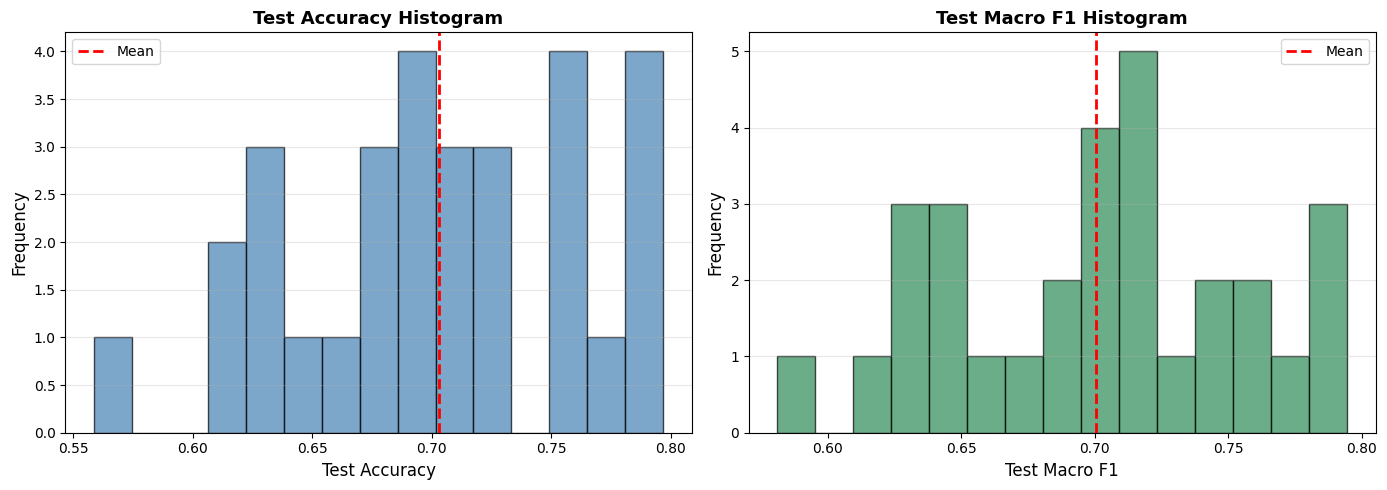

In [26]:
# Plot distributions for temporal front-view runs
plot_multi_run_distributions(multi_run_results_temporal_front, aggregated_stats_temporal_front)


TEMPORAL FRONT VIEW: BEST vs WORST RUN COMPARISON
Best Run:  #8 (seed=50) - Acc: 0.7970, F1: 0.7571
Worst Run: #17 (seed=59) - Acc: 0.5586, F1: 0.5813


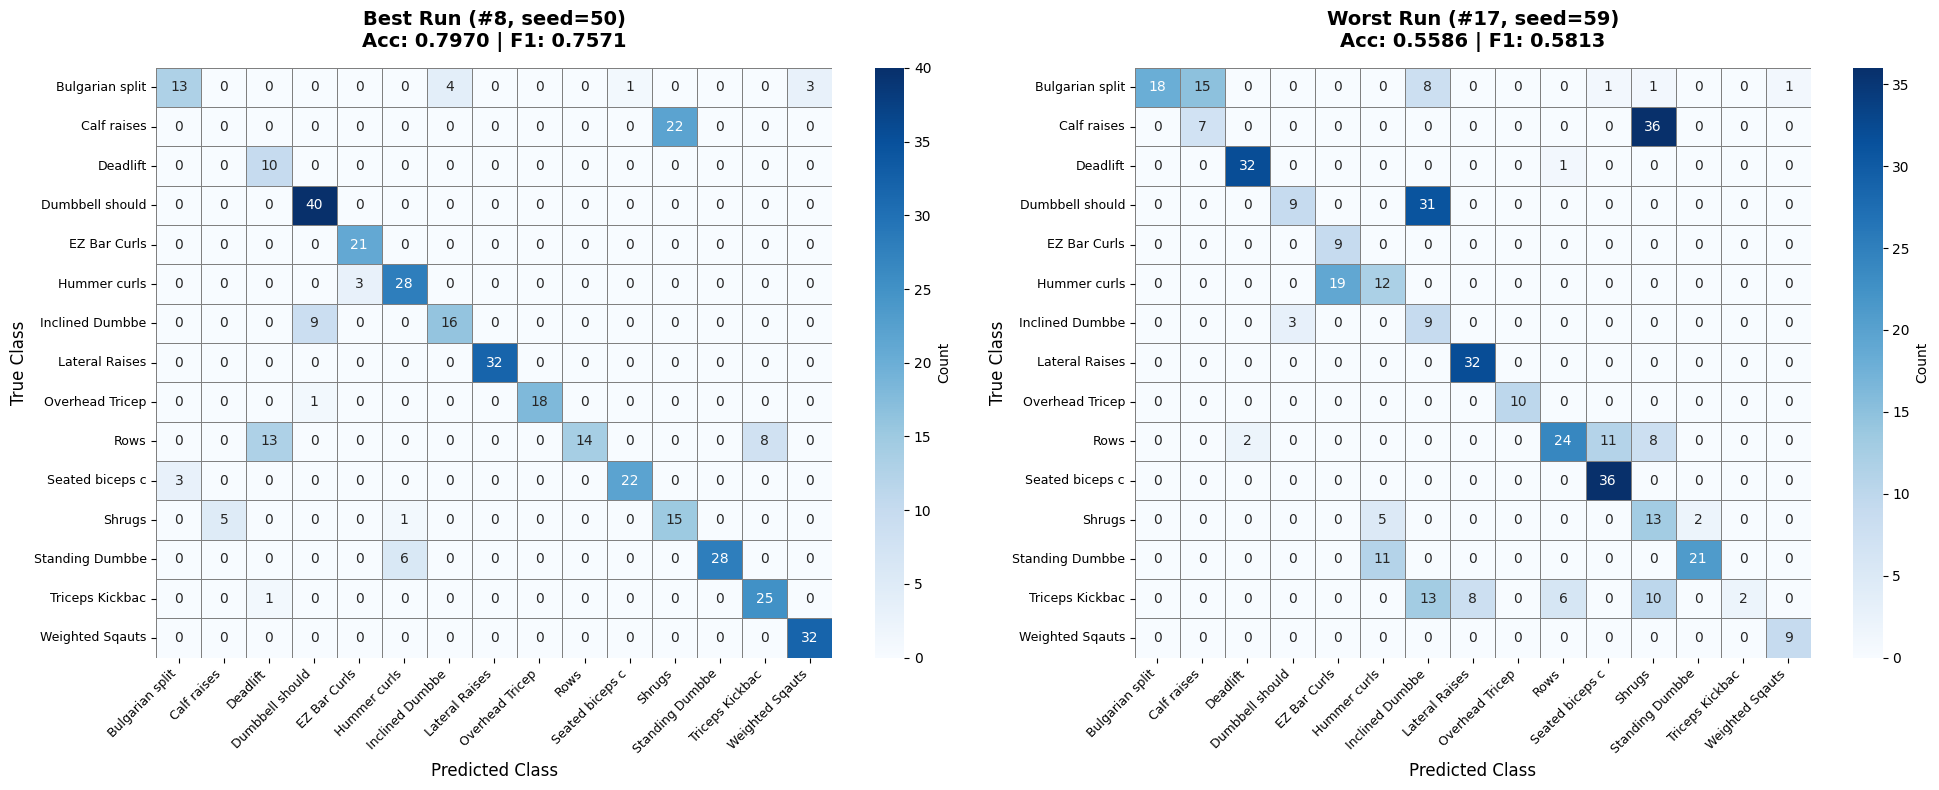


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.7027     0.5806      0.1221
1        0.0000     0.2154     -0.2154
2        0.5882     0.9552     -0.3670
3        0.8889     0.3462      0.5427
4        0.9333     0.4865      0.4468
5        0.8485     0.4068      0.4417
6        0.7111     0.2466      0.4645
7        1.0000     0.8889      0.1111
8        0.9730     1.0000     -0.0270
9        0.5714     0.6316     -0.0602
10       0.9167     0.8571      0.0595
11       0.5172     0.2955      0.2218
12       0.9032     0.7636      0.1396
13       0.8475     0.0976      0.7499
14       0.9552     0.9474      0.0079


In [27]:
# Best vs worst run comparison for temporal front-view
label_names_temporal = sorted(multi_run_results_temporal_front[0]['label_to_int'].keys())
ordered_labels_temporal = sort_labels_by_numeric_prefix(label_names_temporal)

print("\n" + "=" * 80)
print("TEMPORAL FRONT VIEW: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df_temporal_front = plot_best_worst_comparison(multi_run_results_temporal_front, ordered_labels_temporal)

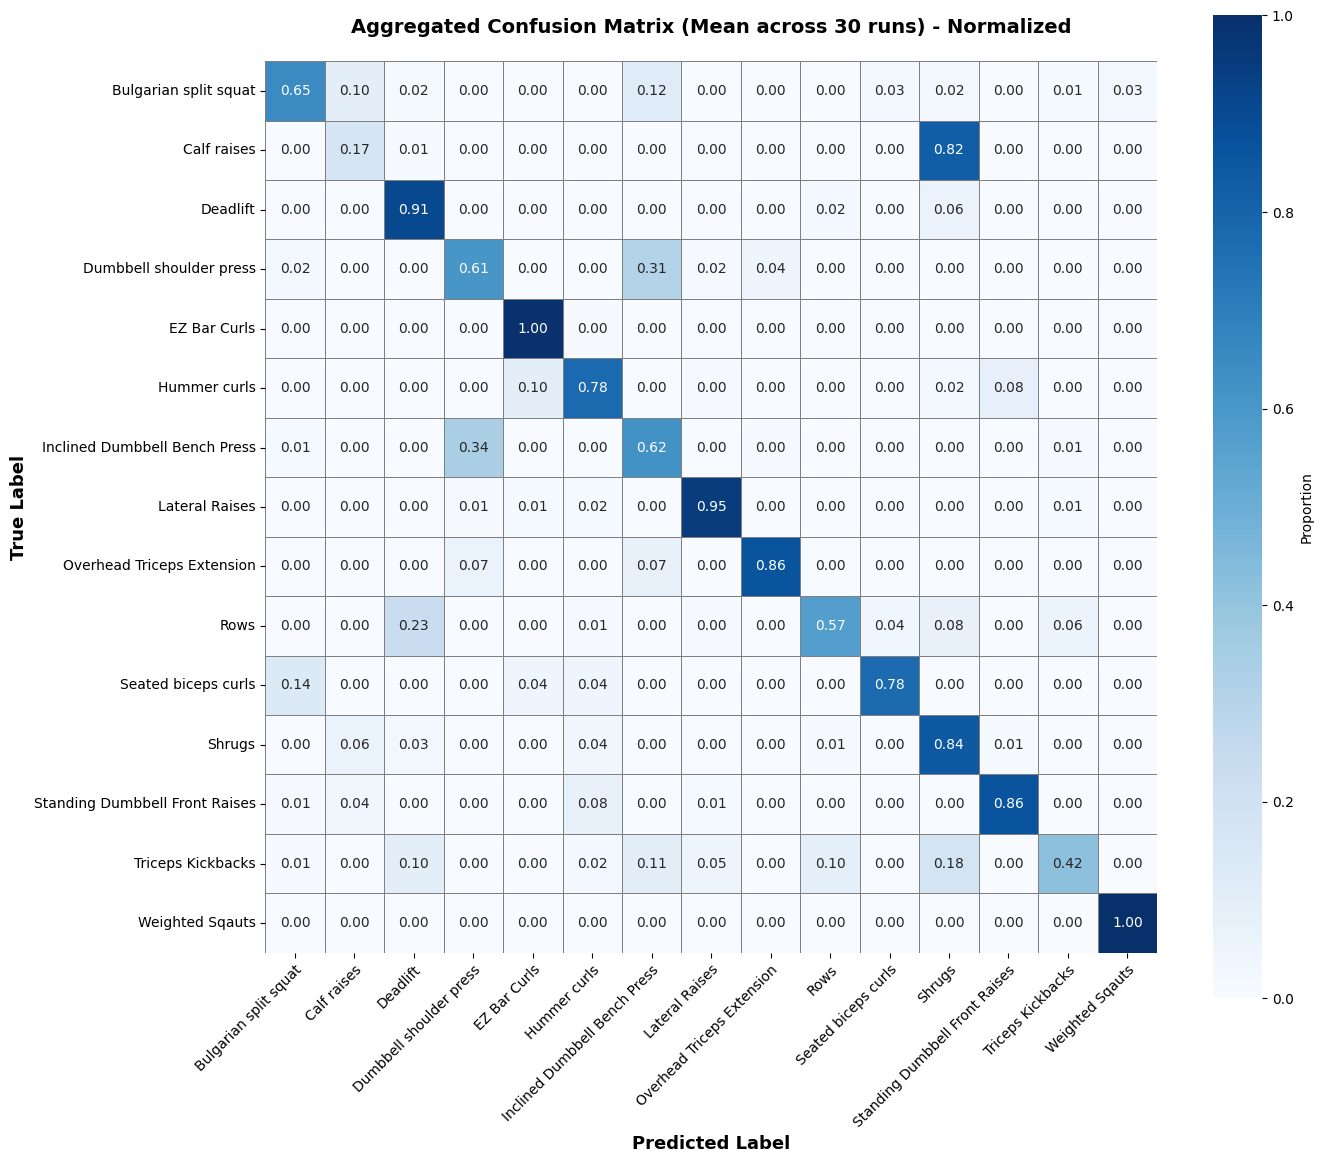

array([[2.53666667e+01, 4.00000000e+00, 7.33333333e-01, 3.33333333e-02,
        3.33333333e-02, 0.00000000e+00, 4.83333333e+00, 0.00000000e+00,
        0.00000000e+00, 1.33333333e-01, 1.30000000e+00, 7.66666667e-01,
        1.33333333e-01, 4.00000000e-01, 1.36666667e+00],
       [0.00000000e+00, 6.26666667e+00, 2.66666667e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.02666667e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.44666667e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.33333333e-02, 0.00000000e+00,
        0.00000000e+00, 6.33333333e-01, 0.00000000e+00, 1.73333333e+00,
        0.00000000e+00, 6.66666667e-02, 0.00000000e+00],
       [8.66666667e-01, 0.00000000e+00, 0.00000000e+00, 2.53000000e+01,
        0.00000000e+00, 0.00000000e+00, 1.28666667e+01, 6.33333333e-01,
        1.86666667e+00, 6.66666667e-0

In [28]:
# Aggregated confusion matrix for temporal front-view
plot_aggregated_confusion_matrix(
    multi_run_results_temporal_front,
    label_names=ordered_labels_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=True
)

## Temporal Side View: Multi-Run Analysis

Detailed analysis of 30 runs for temporal side-view model.

In [29]:
# Display summary table for temporal side-view runs
print("=" * 80)
print("TEMPORAL SIDE VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df_temporal_side = display_multi_run_summary(multi_run_results_temporal_side, aggregated_stats_temporal_side)

TEMPORAL SIDE VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.8926 ± 0.0264
  Min: 0.8378
  Max: 0.9490

Test Macro F1:  0.8774 ± 0.0288
  Min: 0.8116
  Max: 0.9324


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min     max
Class                                
0      0.8938  0.0758  0.6341  1.0000
1      0.9335  0.0343  0.8358  1.0000
2      0.9622  0.0389  0.8696  1.0000
3      0.8612  0.0791  0.6452  0.9867
4      0.8262  0.1061  0.5763  0.9804
5      0.8456  0.0967  0.5778  0.9841
6      0.8769  0.0966  0.5909  1.0000
7      0.9175  0.0769  0.7273  1.0000
8      0.6541  0.1234  0.3448  0.9302
9      0.9601  0.0342  0.8704  1.0000
10     0.9774  0.0348  0.8706  1.0000
11     0.5903  0.1606  0.1429  0.8571
12     0.9498  0.0710  0.8070  1.0000
13     0.9573  0.0382  0.8571  1.0000
14     0.9545  0.0346  0.8824  1.0000


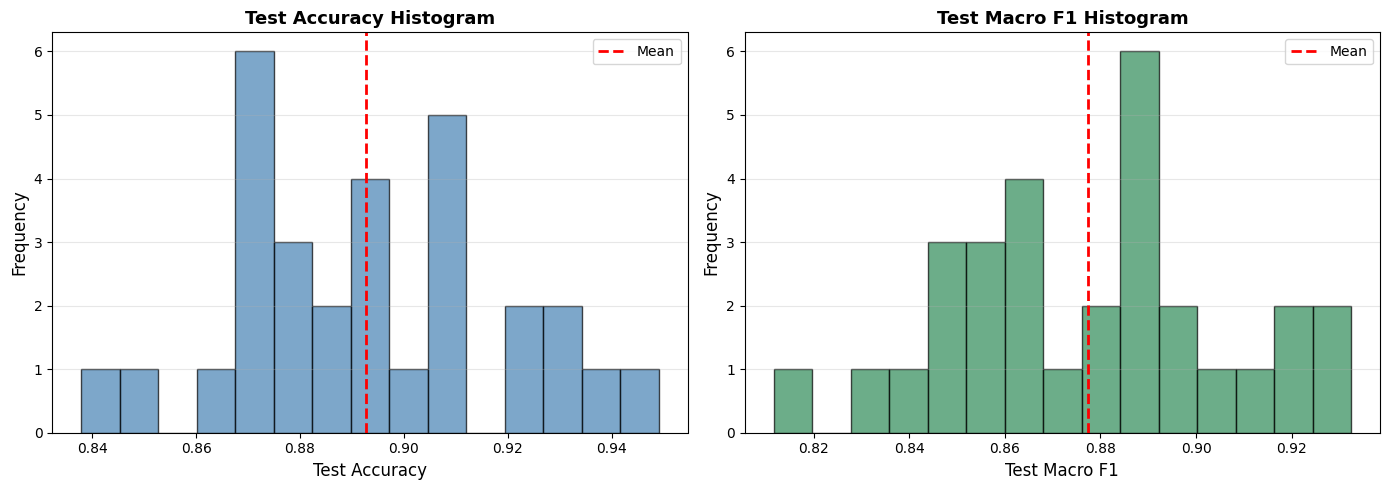

In [30]:
# Plot distributions for temporal side-view runs
plot_multi_run_distributions(multi_run_results_temporal_side, aggregated_stats_temporal_side)


TEMPORAL SIDE VIEW: BEST vs WORST RUN COMPARISON
Best Run:  #14 (seed=56) - Acc: 0.9490, F1: 0.9324
Worst Run: #28 (seed=70) - Acc: 0.8378, F1: 0.8116


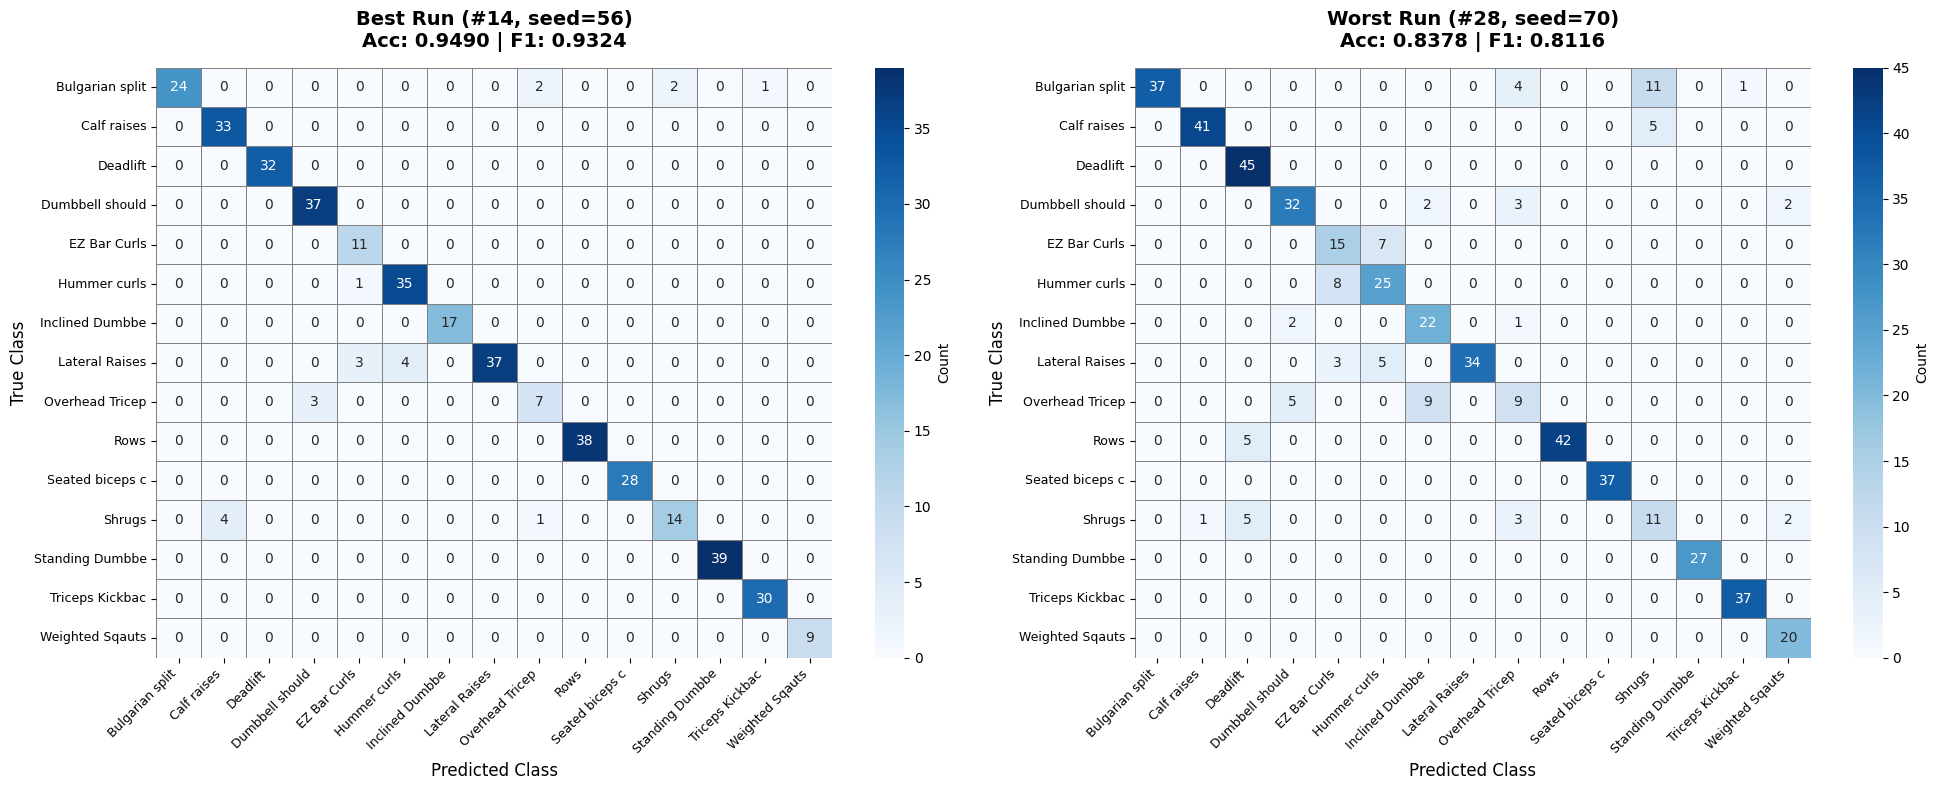


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        0.9057     0.8222      0.0834
1        0.9429     0.9318      0.0110
2        1.0000     0.9000      0.1000
3        0.9610     0.8205      0.1405
4        0.8462     0.6250      0.2212
5        0.9333     0.7143      0.2190
6        1.0000     0.7586      0.2414
7        0.9136     0.8947      0.0188
8        0.7000     0.4186      0.2814
9        1.0000     0.9438      0.0562
10       1.0000     1.0000     -0.0000
11       0.8000     0.4490      0.3510
12       1.0000     1.0000      0.0000
13       0.9836     0.9867     -0.0031
14       1.0000     0.9091      0.0909


In [31]:
# Best vs worst run comparison for temporal side-view
print("\n" + "=" * 80)
print("TEMPORAL SIDE VIEW: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df_temporal_side = plot_best_worst_comparison(multi_run_results_temporal_side, ordered_labels_temporal)

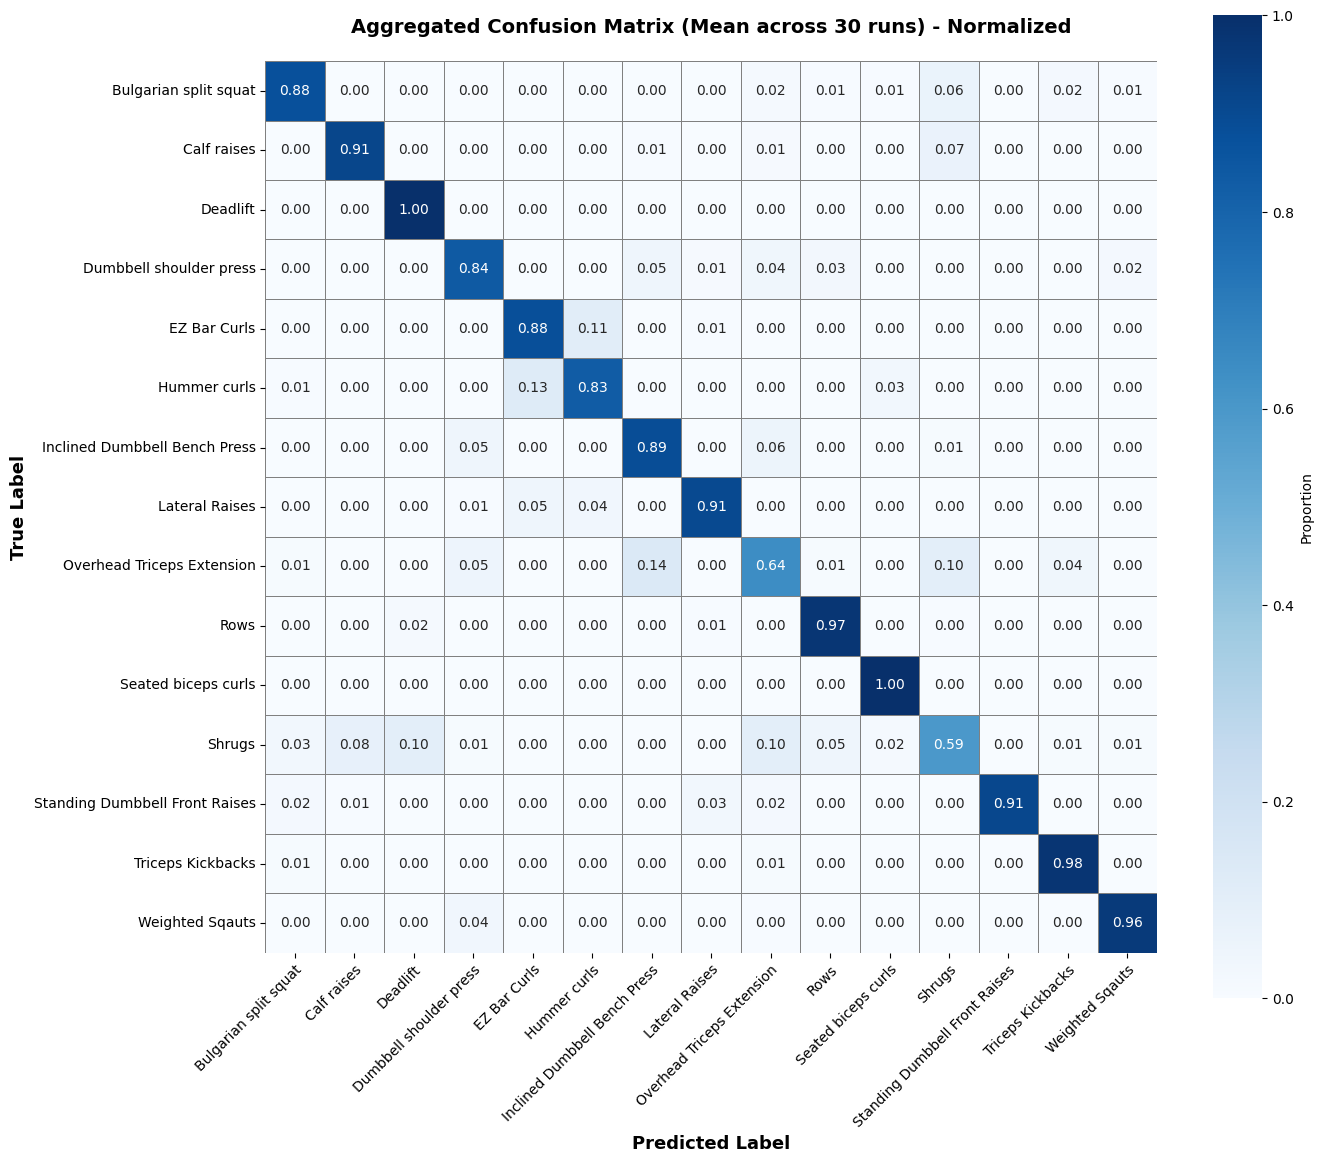

array([[2.88000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.33333333e-01, 2.33333333e-01, 1.66666667e-01, 2.10000000e+00,
        1.00000000e-01, 7.00000000e-01, 2.00000000e-01],
       [0.00000000e+00, 3.61666667e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.00000000e-01, 0.00000000e+00,
        4.66666667e-01, 0.00000000e+00, 0.00000000e+00, 2.70000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.59666667e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.33333333e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.21333333e+01,
        3.33333333e-02, 0.00000000e+00, 1.83333333e+00, 5.66666667e-01,
        1.53333333e+00, 1.06666667e+0

In [32]:
# Aggregated confusion matrix for temporal side-view
plot_aggregated_confusion_matrix(
    multi_run_results_temporal_side,
    label_names=ordered_labels_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=True
)

---

## Cross-Model Visualizations: Temporal Front vs Side

Side-by-side comparisons of best runs from each temporal view.

In [33]:
# Get best runs from each temporal view for detailed comparison
best_run_temporal_front = max(multi_run_results_temporal_front, key=lambda x: x['test_metrics']['macro_f1'])
best_run_temporal_side = max(multi_run_results_temporal_side, key=lambda x: x['test_metrics']['macro_f1'])

print("Best Run Performance (Temporal):")
print(f"  Front View - Accuracy: {best_run_temporal_front['test_metrics']['accuracy']:.4f}, Macro F1: {best_run_temporal_front['test_metrics']['macro_f1']:.4f}")
print(f"  Side View  - Accuracy: {best_run_temporal_side['test_metrics']['accuracy']:.4f}, Macro F1: {best_run_temporal_side['test_metrics']['macro_f1']:.4f}")

Best Run Performance (Temporal):
  Front View - Accuracy: 0.7920, Macro F1: 0.7945
  Side View  - Accuracy: 0.9490, Macro F1: 0.9324


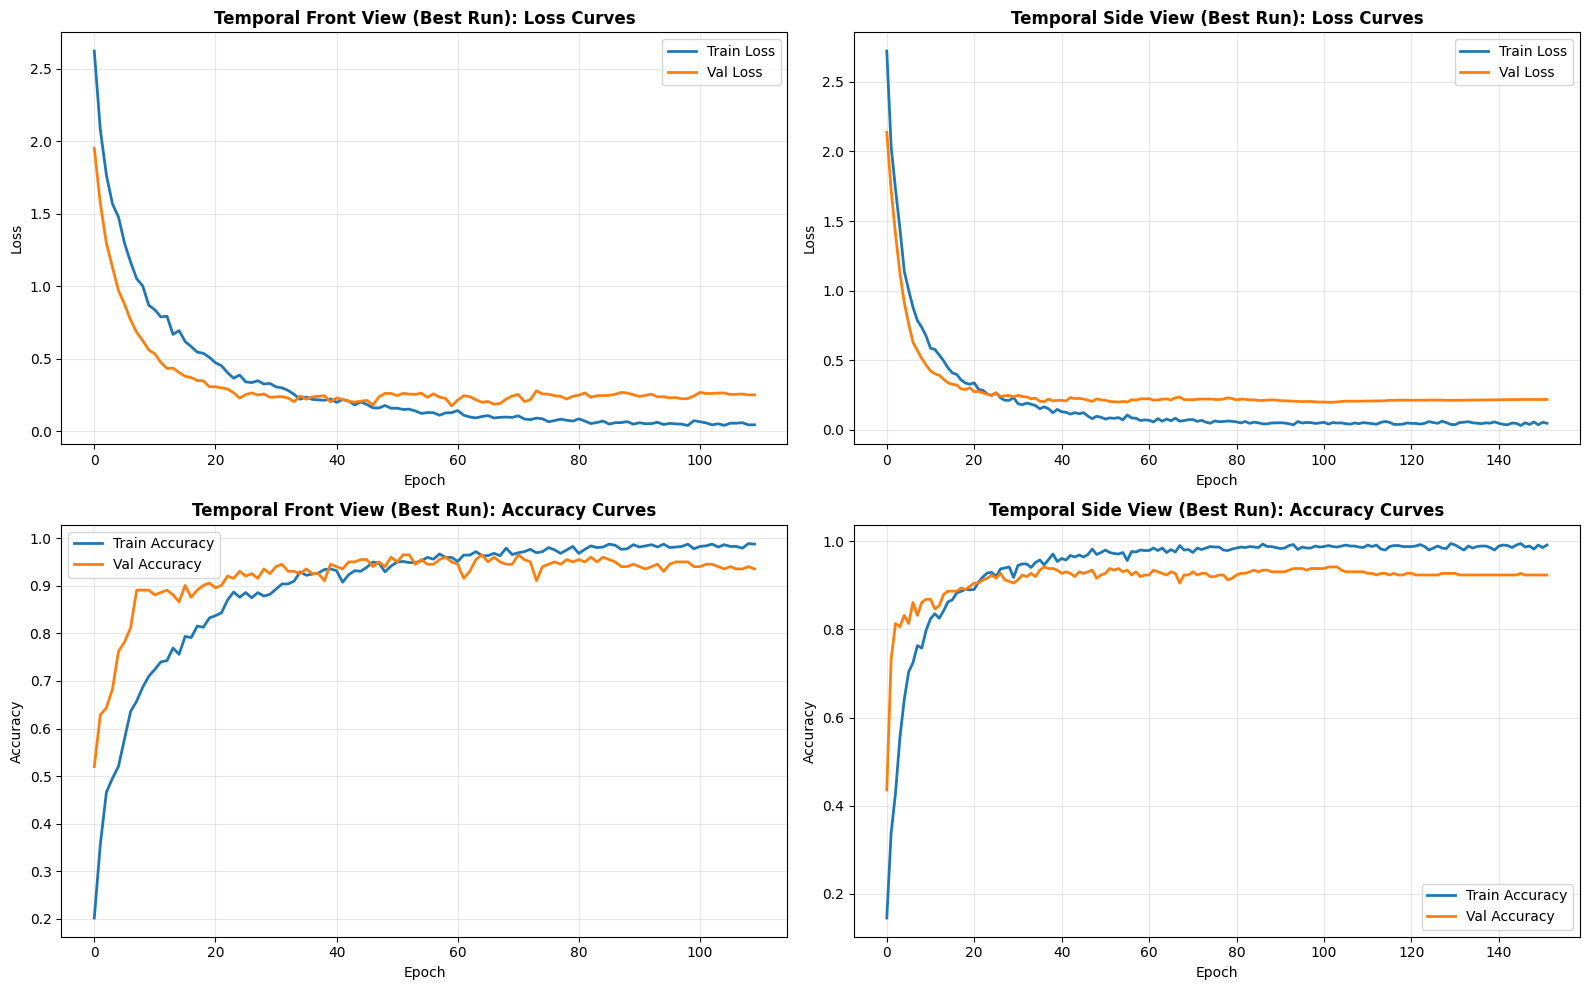

Temporal Front View (Best Run) training: 110 epochs
Temporal Side View (Best Run) training: 152 epochs


In [34]:
# Plot training curves for best temporal runs side-by-side
plot_dual_training_history(
    best_run_temporal_front['history'],
    best_run_temporal_side['history'],
    model_names=['Temporal Front View (Best Run)', 'Temporal Side View (Best Run)']
)

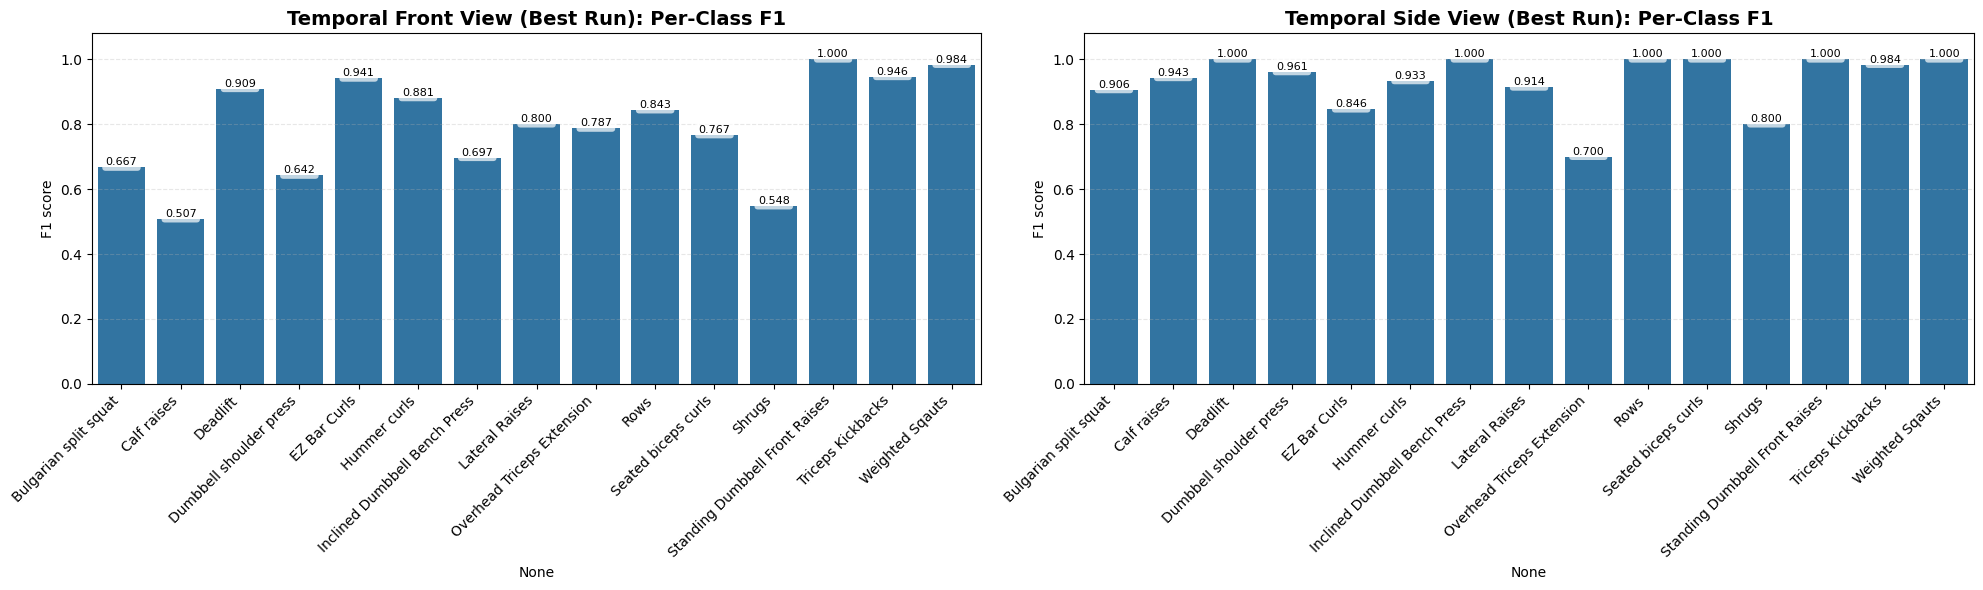

In [35]:
# Side-by-side per-class F1 comparison (best temporal runs)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

idx_to_label_temporal = {int(k): v for k, v in best_run_temporal_front['int_to_label'].items()}

per_class_f1_temporal_front = plot_per_class_f1_scores(
    best_run_temporal_front['test_metrics']['per_class_f1'],
    idx_to_label_temporal,
    desired_class_order=ordered_labels_temporal,
    ax=axes[0]
)
axes[0].set_title('Temporal Front View (Best Run): Per-Class F1', fontsize=14, fontweight='bold')

per_class_f1_temporal_side = plot_per_class_f1_scores(
    best_run_temporal_side['test_metrics']['per_class_f1'],
    idx_to_label_temporal,
    desired_class_order=ordered_labels_temporal,
    ax=axes[1]
)
axes[1].set_title('Temporal Side View (Best Run): Per-Class F1', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

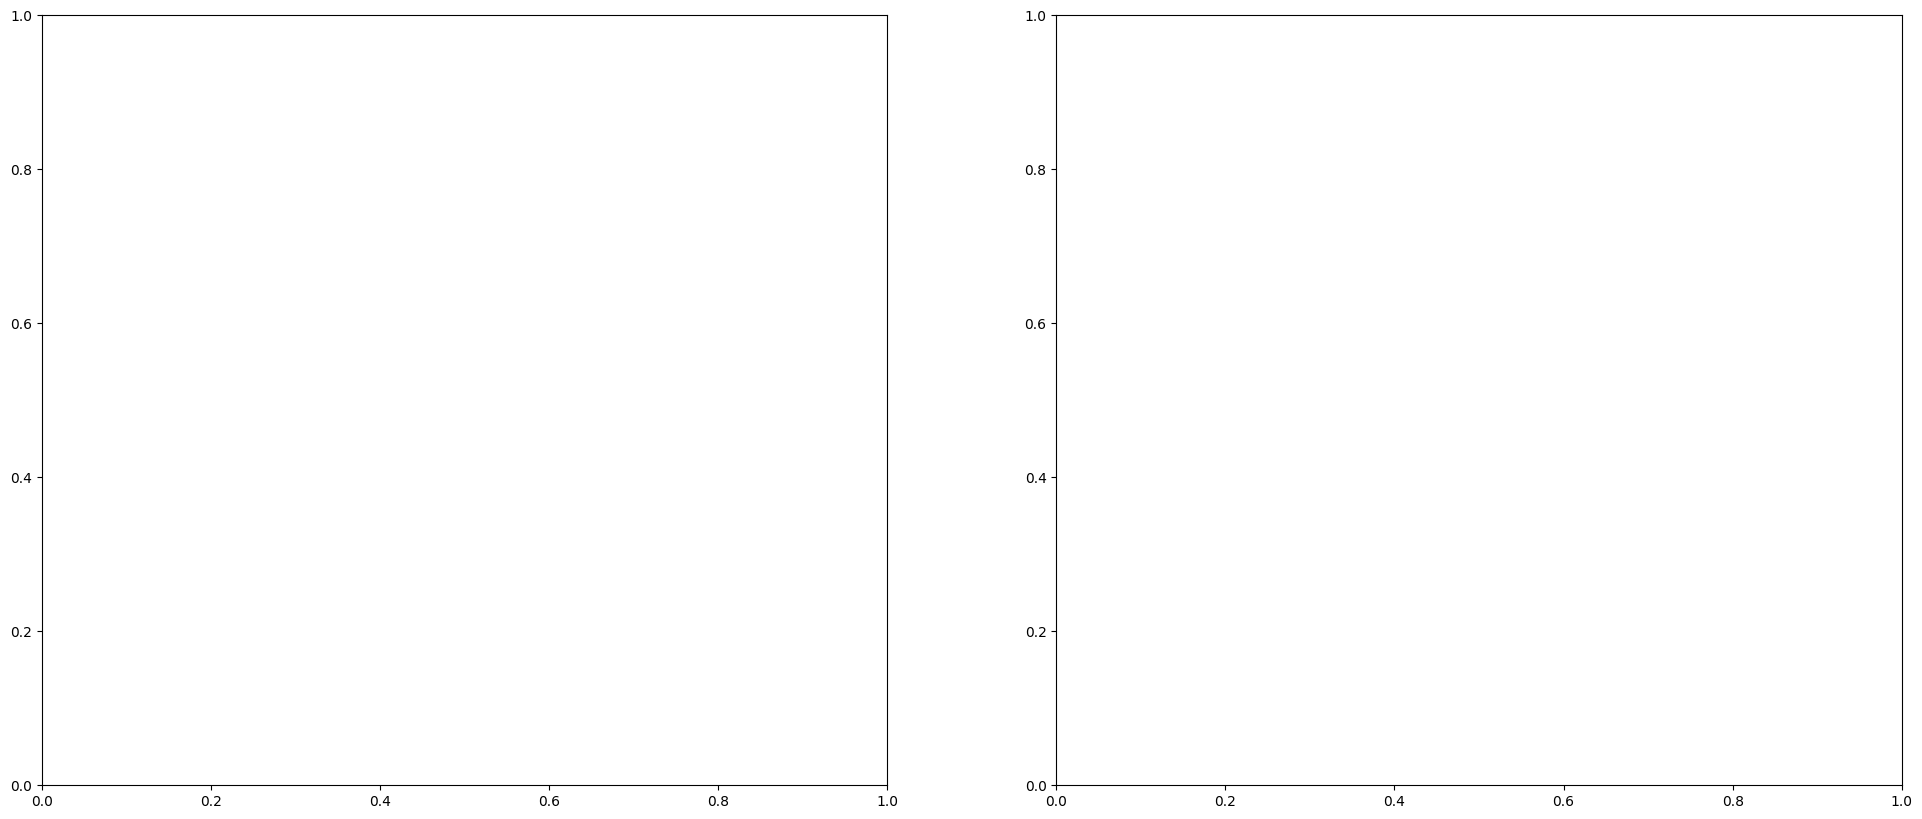

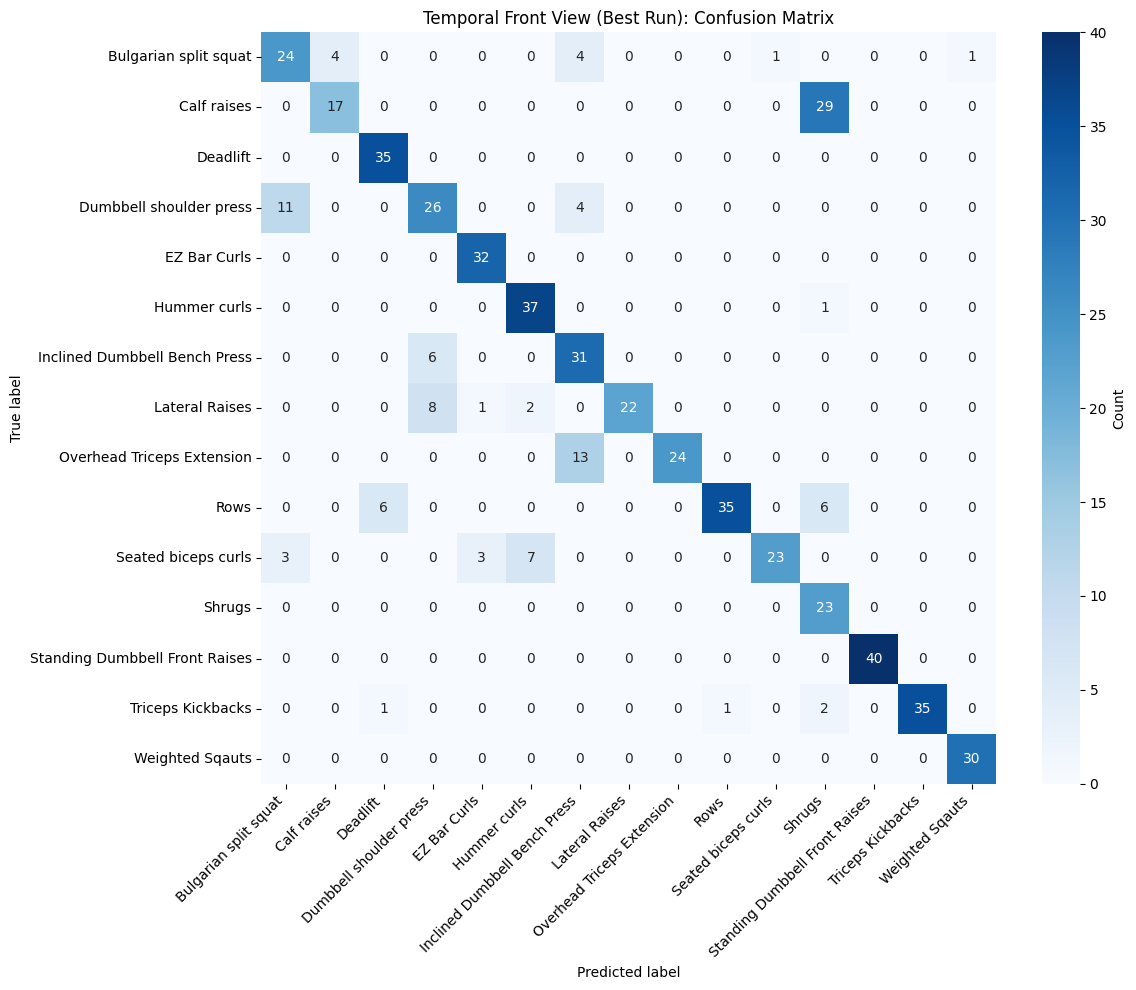

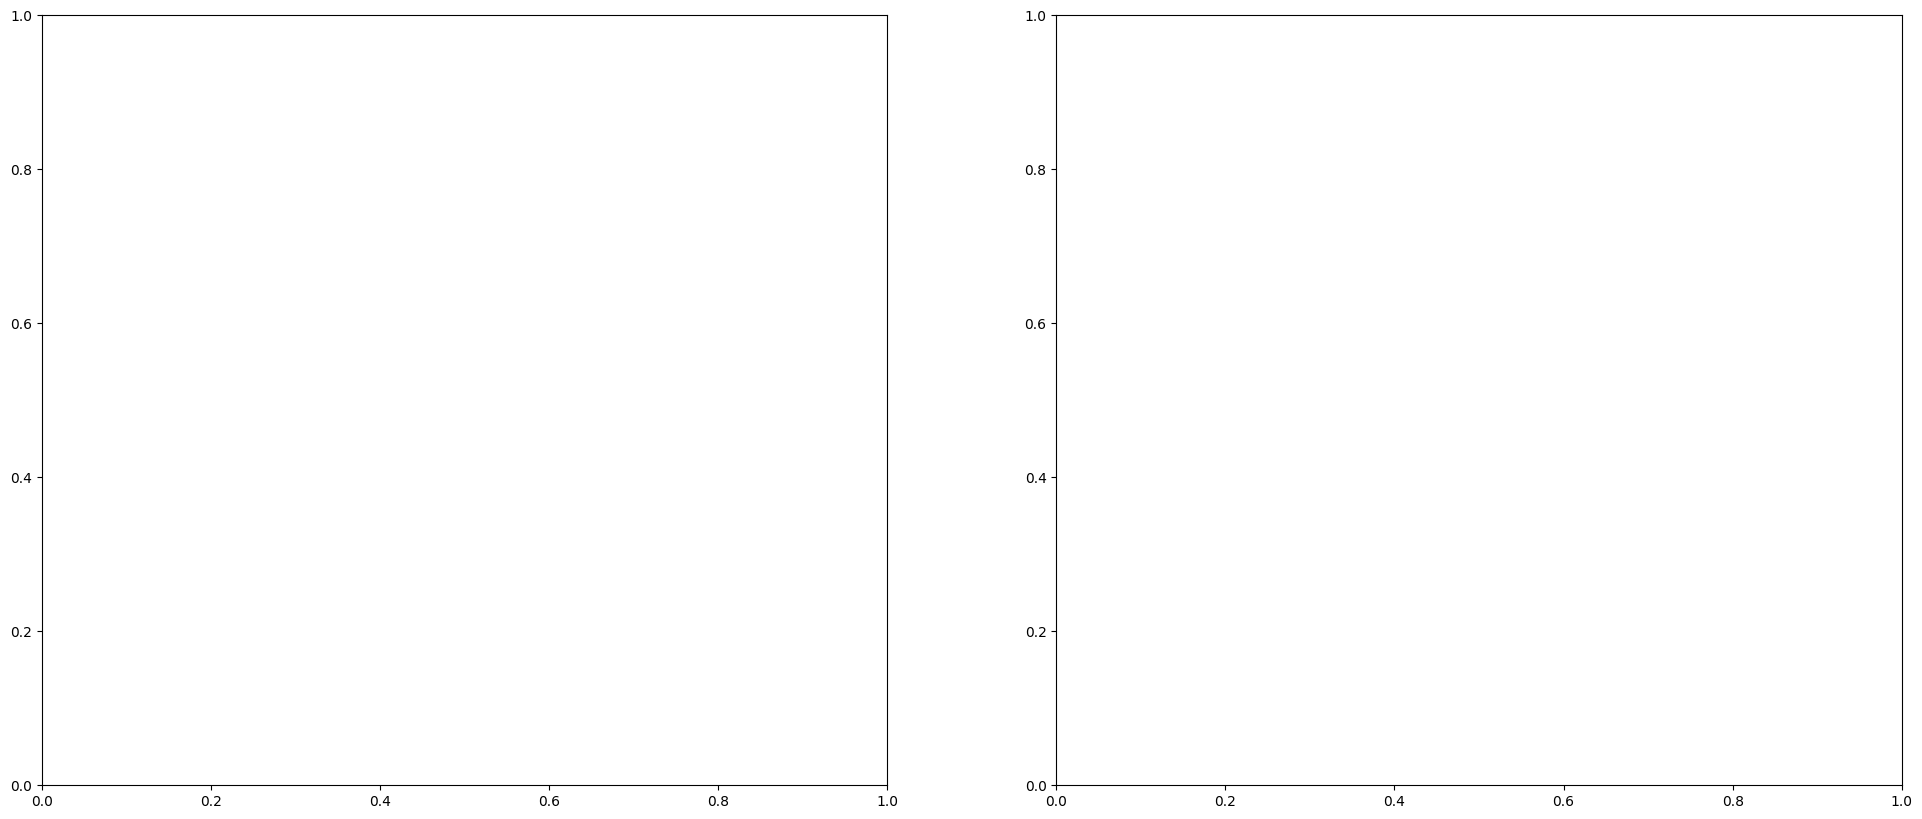

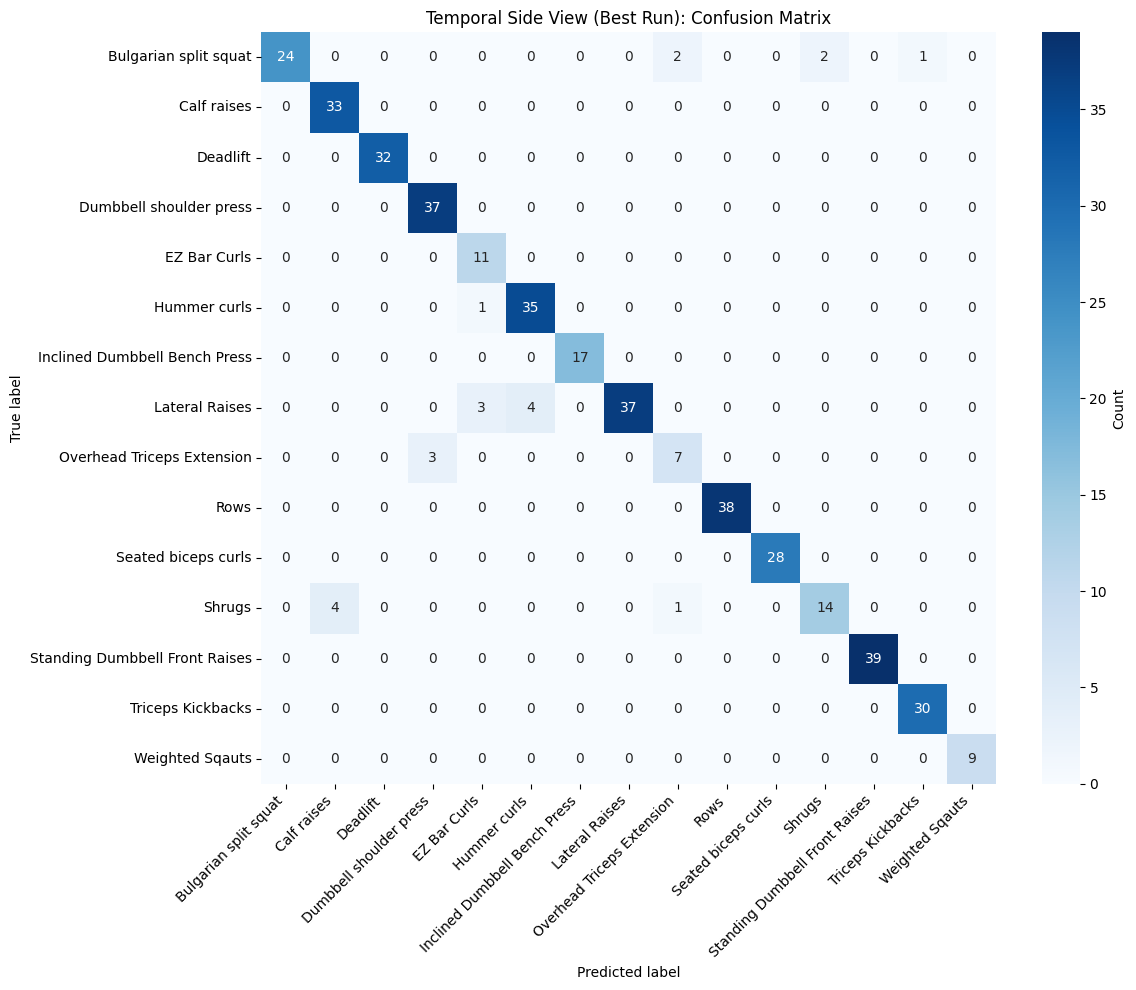

<Figure size 640x480 with 0 Axes>

In [36]:
# Side-by-side confusion matrices (best temporal runs)
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

conf_matrix_temporal_front = np.array(best_run_temporal_front['test_metrics']['confusion_matrix'])
plt.sca(axes[0])
plot_confusion_matrix_from_metrics(
    conf_matrix_temporal_front,
    current_class_order=label_names_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=False,
    title='Temporal Front View (Best Run): Confusion Matrix'
)

conf_matrix_temporal_side = np.array(best_run_temporal_side['test_metrics']['confusion_matrix'])
plt.sca(axes[1])
plot_confusion_matrix_from_metrics(
    conf_matrix_temporal_side,
    current_class_order=label_names_temporal,
    desired_class_order=ordered_labels_temporal,
    normalize=False,
    title='Temporal Side View (Best Run): Confusion Matrix'
)

plt.tight_layout()
plt.show()

---

## Final Comparison: Static vs Temporal Features

This section provides a comprehensive comparison between hand-crafted statistical features (static) and raw temporal sequences (temporal) to understand which feature engineering approach is more effective for the MLP baseline.

In [37]:
# Compare static vs temporal for front view
print("=" * 80)
print("FRONT VIEW: STATIC vs TEMPORAL COMPARISON")
print("=" * 80)
comparison_df_front_static_vs_temporal = compare_multi_run_stats(
    aggregated_stats_front,
    aggregated_stats_temporal_front,
    model_names=['Static Front', 'Temporal Front']
)

FRONT VIEW: STATIC vs TEMPORAL COMPARISON
MULTI-RUN STATISTICAL COMPARISON: Static Front vs Temporal Front

       Metric    Static Front  Temporal Front
Test Accuracy 0.6505 ± 0.0545 0.7032 ± 0.0601
Test Macro F1 0.6478 ± 0.0482 0.7006 ± 0.0546




In [38]:
# Compare static vs temporal for side view
print("\n" + "=" * 80)
print("SIDE VIEW: STATIC vs TEMPORAL COMPARISON")
print("=" * 80)
comparison_df_side_static_vs_temporal = compare_multi_run_stats(
    aggregated_stats_side,
    aggregated_stats_temporal_side,
    model_names=['Static Side', 'Temporal Side']
)


SIDE VIEW: STATIC vs TEMPORAL COMPARISON
MULTI-RUN STATISTICAL COMPARISON: Static Side vs Temporal Side

       Metric     Static Side   Temporal Side
Test Accuracy 0.8270 ± 0.0315 0.8926 ± 0.0264
Test Macro F1 0.8098 ± 0.0319 0.8774 ± 0.0288




In [39]:
# Overall comparison: All 4 models
print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON: ALL MODELS")
print("=" * 80)

all_models_stats = {
    'Static Front': aggregated_stats_front,
    'Static Side': aggregated_stats_side,
    'Temporal Front': aggregated_stats_temporal_front,
    'Temporal Side': aggregated_stats_temporal_side
}

# Create comparison DataFrame
comparison_data = []
for model_name, stats in all_models_stats.items():
    comparison_data.append({
        'Model': model_name,
        'Test Accuracy (Mean)': f"{stats['test_accuracy']['mean']:.4f}",
        'Test Accuracy (Std)': f"{stats['test_accuracy']['std']:.4f}",
        'Test Macro F1 (Mean)': f"{stats['test_macro_f1']['mean']:.4f}",
        'Test Macro F1 (Std)': f"{stats['test_macro_f1']['std']:.4f}",
        'Accuracy Range': f"[{stats['test_accuracy']['min']:.4f}, {stats['test_accuracy']['max']:.4f}]",
        'F1 Range': f"[{stats['test_macro_f1']['min']:.4f}, {stats['test_macro_f1']['max']:.4f}]"
    })

comparison_df_all = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df_all.to_string(index=False))
print("\n")

# Find best model overall
best_model_name = max(all_models_stats.keys(), key=lambda x: all_models_stats[x]['test_macro_f1']['mean'])
best_f1 = all_models_stats[best_model_name]['test_macro_f1']['mean']
print(f"🏆 Best Model (by mean macro F1): {best_model_name} with F1 = {best_f1:.4f}")
print("=" * 80)


COMPREHENSIVE COMPARISON: ALL MODELS


         Model Test Accuracy (Mean) Test Accuracy (Std) Test Macro F1 (Mean) Test Macro F1 (Std)   Accuracy Range         F1 Range
  Static Front               0.6505              0.0545               0.6478              0.0482 [0.5287, 0.8032] [0.5485, 0.7928]
   Static Side               0.8270              0.0315               0.8098              0.0319 [0.7754, 0.8952] [0.7488, 0.8825]
Temporal Front               0.7032              0.0601               0.7006              0.0546 [0.5586, 0.7970] [0.5813, 0.7945]
 Temporal Side               0.8926              0.0264               0.8774              0.0288 [0.8378, 0.9490] [0.8116, 0.9324]


🏆 Best Model (by mean macro F1): Temporal Side with F1 = 0.8774
